In [1]:
import sys
sys.path.append('/var/panoptes/panoptes-utils/src')
# sys.path.append('/var/panoptes/panoptes-pipeline/')
# print(sys.path)

In [2]:
# import sys 
# print(sys.path)

In [3]:
import numpy as np
import math
import pandas as pd
import cv2

from astropy.io import fits
# from panoptes.pipeline.scripts import image as image_processing

from panoptes.utils.images import fits as fits_utils
from panoptes.utils.images import crop_data
from panoptes.utils.images import bayer

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
from panoptes.utils.images import plot
import seaborn as sb
from astropy.coordinates import SkyCoord
from scipy.stats import median_abs_deviation as md

Retrieve image sequence.

In [4]:
sequence_id = 'PAN012_95cdbc_20200226T031944'
base_dir = '/home/jupyter/data'
# sequence_path = sequence_id.replace('_', '/')

In [5]:
# The path for the metadata dataframe if it exists.
images_df_path = f'{base_dir}/{sequence_id}/images-metadata.csv'

In [6]:
# Get the metadata from local file.
images_df = pd.read_csv(images_df_path).sort_values(by='time')

In [8]:
# Get the list of local paths for the downloaded images.
fits_files = images_df.local_file.to_list()
len(fits_files)

35

In [9]:
np.shape(fits_utils.getdata(fits_files[-1]))

(3476, 5208)

Remove bad image (if it exists).

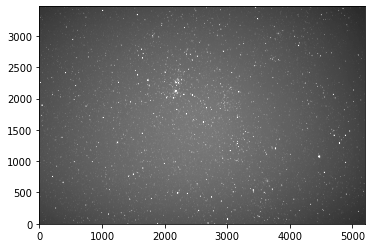

In [12]:
del fits_files[22]
del fits_files[29]
# Inspect image for quality control
plt.imshow(fits_utils.getdata(fits_files[30]), cmap='gray', origin='lower', vmax='4100')

In [13]:
len(fits_files)

33

In [14]:
# Get image data for all FITS and add it to a list
im_data = np.array([fits_utils.getdata(f) for f in fits_files])

In [17]:
def process_images(data=None, stacked_dat=None, channel='green1', target_name='TYC 3697-817-1', stamp_size=(126,126), suppress_output=False):
     """
    A function that plate solves images, extracts postage stamps, and extracts a color channel.
    
    Inputs:
    data (array): The image data to be processed.
    stacked_dat (array): Use if stacking sequence of images.
    channel (string): Specify color channel to be used in extraction.
    target_name: The name of a target to center around.
    stamp_size: Create postage stamp.
    red, green, blue (boolean): Color channels to extract.
    
    Outputs: 
    *color*_arr (array): An image corresponding to an extracted color channel.
    
    """
    
    wcs0 = fits_utils.getwcs(fits_files[6])
    target_name = target_name
    target_coords = SkyCoord.from_name(target_name)
    target_x, target_y = wcs0.all_world2pix(target_coords.ra, target_coords.dec, 1)
    if data is not None:
        num_frames=len(data)
    else:
        num_frames=len(stacked_dat)
    slice0 = bayer.get_stamp_slice(target_x, target_y, stamp_size=stamp_size)
    if stacked_dat is not None:
        stack_sliced = stacked_dat[slice0]
        sliced_im_stack_arr = np.array(stack_sliced)
        
        if suppress_output is False:
            plt.imshow(sliced_im_stack_arr, origin='lower')
            
        im_rgb_full_stack = bayer.get_rgb_data(data=sliced_im_stack_arr, separate_green=True)
        
        if suppress_output is False:
            print(np.shape(im_rgb_full_stack))
        rgb_dat_stack = im_rgb_full_stack[:, ][~im_rgb_full_stack[:,].mask].reshape(4,int(stamp_size[0]/2),-1)
        if channel == 'red':
            rgb_arr = np.array(rgb_dat_stack[0])
        if channel == 'green1':
            rgb_arr = np.array(rgb_dat_stack[1])
        elif channel == 'green2':
            rgb_arr = np.array(rgb_dat_stack[2])
        elif channel == 'blue':
            rgb_arr = np.array(rgb_dat_stack[3])
#         green1_arr = np.array(green1_stack)
        if suppress_output is False:
            print(f'Stacked Image Shape: {np.shape(green1_stack)}')
            fig=plt.figure(figsize=(25,12))
            ax1 = fig.add_subplot(111)
            ax1.imshow(green1_stack, cmap='gray', origin='lower', vmax = 4100)

            # im_idx = 5

            # TODO: Add else condition for non-stacked images
    else:
       # im_idx = 5
        sliced_im_list = []
        for idx in range(len(data)):
            sliced_im_list.append(im_data[idx][slice0])
        sliced_im_arr = np.array(sliced_im_list)
        im_rgb_full = bayer.get_rgb_data(data=sliced_im_arr, separate_green=True)
        rgb_dat_list = []


        for i in range(num_frames):
            rgb_dat_list.append(im_rgb_full[:, i][~im_rgb_full[:,i].mask].reshape(4,int(stamp_size[0]/2), -1))
        rgb_dat_arr = np.array(rgb_dat_list)
        np.shape(rgb_dat_arr)
        # Create green1 channel array
        if channel == 'red':
            rgb_arr = [rgb_dat_list[i][0] for i in range(num_frames)]
        if channel == 'green1':
            rgb_arr = [rgb_dat_list[i][1] for i in range(num_frames)]
        elif channel == 'green2':
            rgb_arr = [rgb_dat_list[i][2] for i in range(num_frames)]
        elif channel == 'blue':
            rgb_arr = [rgb_dat_list[i][3] for i in range(num_frames)]

#         plt.imshow(sliced_im_list[10], origin='lower' )

# plt.savefig('sliced_image.png')
        if suppress_output is False:
            plt.imshow(sliced_im_list[10], origin='lower')
            print(np.shape(im_rgb_full))
            print(f'Stacked Image Shape: {np.shape(rgb_arr)}')
            fig=plt.figure(figsize=(25,12))
            ax1 = fig.add_subplot(111)
            ax1.imshow(rgb_arr, cmap='gray', origin='lower', vmax = 4100)
    return rgb_arr


        
        
   

In [18]:
# Bin and stack data

stack_im_bin1 = np.mean(im_data[:16], axis=0)
stack_im_bin2 = np.mean(im_data[17:-1], axis = 0)

green1_stacked_bin1 = process_images(stacked_dat=stack_im_bin1, stamp_size=(250,250), suppress_output=True)
green1_stacked_bin2 = process_images(stacked_dat=stack_im_bin2, stamp_size=(250,250), suppress_output=True)
green1_bin1 = process_images(data=im_data[:16], stamp_size=(250,250), suppress_output=True)
green1_bin2 = process_images(data=im_data[17:-1], stamp_size=(250,250), suppress_output=True)

2021-12-03 17:34:44.081 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-03 17:34:44.085 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-03 17:34:44.116 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-03 17:34:44.117 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-03 17:34:44.145 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-03 17:34:44.147 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-03 17:34:44.230 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-03 17:34:44.231 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

In [23]:
red1_stacked_bin1 = process_images(channel='red', stacked_dat=stack_im_bin1, stamp_size=(250,250), suppress_output=True)
red1_stacked_bin2 = process_images(channel='red', stacked_dat=stack_im_bin2, stamp_size=(250,250), suppress_output=True)
red1_bin1 = process_images(channel='red', data=im_data[:16], stamp_size=(250,250), suppress_output=True)
red1_bin2 = process_images(channel='red', data=im_data[17:-1], stamp_size=(250,250), suppress_output=True)

2021-12-03 17:39:13.984 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-03 17:39:13.985 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-03 17:39:14.015 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-03 17:39:14.016 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-03 17:39:14.042 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-03 17:39:14.044 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-03 17:39:14.105 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-03 17:39:14.106 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

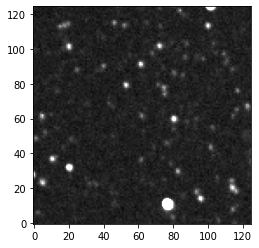

In [26]:
plt.imshow(red1_bin1[1], cmap='gray', origin='lower', vmax = 3300)

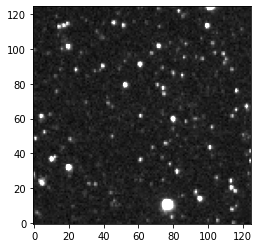

In [28]:
plt.imshow(green1_bin1[1], cmap='gray', origin='lower', vmax = 4100)

Simulate 27 x 27 image

In [30]:
# Draw square around target star for each frame
def get_flux_counts_new(bin=1, channel='green1', mode='real', pt1_1=25, pt1_2=29, pt2_1=29, pt2_2=25, dims=63, spacing_inner=0, spacing_outer=2, ):
    
    """ 
    Perform aperture photometry on a list of channel-extracted image frames.
    This function will count up all of the values within an inner square and subtract the median values * the number of pixels 
    within the inner square. Each square is drawn from pt1 and pt2--a point corresponding to the upper-left corner and a point
    corresponding to the bottom-right corner.
    
    Inputs:
    bin (int): Define bin for processing.
    mode: Define processing mode (real or simulated).
    pt1_1 (int): The x-coordinate for the upper-left corner of the square.
    pt1_2 (int): The y-coordinate for the upper-left corner of the square.
    pt2_1 (int): The x-coordinate for the bottom-right corner of the square.
    pt2_2 (int): The y-coordinate for the bottom-right corner of the square.
    dims (int): The row/column length of the image array.
    spacing_inner (int): Define inner annulus spacing.
    spacing_outer (int): Define outer annulus spacing.
    
    Outputs:
    total_counts (list): A list of the BG-subtracted flux counts for each frame of the sequence.
    frame_square_new (array): An image w/ an overlaid annulus from the sequence.
    """

    outer_list = []
    total_counts = []
    tot_list = []
    outer_med_list = []
    channel_data_list = []
    # TODO: Assign outer square coords to an input param
    num_frames=len(fits_files)
    
    center_x = (pt1_1 + pt2_1) / 2
    center_y = center_x
    pink = [0,255,255]
    
    
    
    # Regenerate simulated image array. This is necessary to "reset" the image each time the function is run.
    green1 = process_images(data=im_data, stamp_size=(126,126), suppress_output=True)
    green2 = process_images(channel = 'green2', data=im_data, stamp_size=(126,126), suppress_output=True)
    red = process_images(channel = 'red', data=im_data, stamp_size=(126,126), suppress_output=True)
    blue = process_images(channel = 'blue', data=im_data, stamp_size=(126,126), suppress_output=True)
    
    sim_im = np.ones((num_frames, dims,dims))*1000
#     stack_im_bin1 = np.median(im_data[:16], axis=0)
#     stack_im_bin2 = np.median(im_data[17:-1], axis = 0)
# #
    green1_stacked_bin1 = process_images(stacked_dat=stack_im_bin1, stamp_size=(250,250), suppress_output=True)
    green1_stacked_bin2 = process_images(stacked_dat=stack_im_bin2, stamp_size=(250,250), suppress_output=True)
    green1_bin1 = process_images(data=im_data[:16], stamp_size=(250,250), suppress_output=True)
    green1_bin2 = process_images(data=im_data[17:-1], stamp_size=(250,250), suppress_output=True)
    
    red1_stacked_bin1 = process_images(channel='red', stacked_dat=stack_im_bin1, stamp_size=(250,250), suppress_output=True)
    red1_stacked_bin2 = process_images(channel='red', stacked_dat=stack_im_bin2, stamp_size=(250,250), suppress_output=True)
    red1_bin1 = process_images(channel='red', data=im_data[:16], stamp_size=(250,250), suppress_output=True)
    red1_bin2 = process_images(channel='red', data=im_data[17:-1], stamp_size=(250,250), suppress_output=True)
    
    if mode == 'real':
        if channel == 'green1':
            channel_data = green1
        elif channel == 'red':
            channel_data = red
        elif channel == 'blue':
            channel_data = blue
        elif channel == 'green2':
            channel_data = green2
    
#         channel_data_list.append(channel_data[i])
    if mode == 'real_bins1':
        if channel == 'green1':
            channel_data = green1_bin1
        elif channel == 'red':
            channel_data = red_bin1
        elif channel == 'blue':
            channel_data = blue_bin1
        elif channel == 'green2':
            channel_data = green2_bin1
#         channel_data_list.append(channel_data[i])
        num_frames = len(channel_data)
    
    if mode == 'real_bins2':
        if channel == 'green1':
            channel_data = green1_bin2
        elif channel == 'red':
            channel_data = red_bin2
        elif channel == 'blue':
            channel_data = blue_bin2
        elif channel == 'green2':
            channel_data = green2_bin2
    #         channel_data_list.append(channel_data[i])
        num_frames = len(channel_data)
        
    if mode == 'stacked':
        if bin == 1:
            if channel == 'green1':
                channel_data = green1_stacked_bin1
            elif channel == 'red':
                channel_data = red_stacked_bin1
            elif channel == 'blue':
                channel_data = blue_stacked_bin1
            elif channel == 'green2':
                channel_data = green2_stacked_bin1
            num_frames=1
            
        elif bin == 2:
            if channel == 'green1':
                channel_data = green1_stacked_bin2
            elif channel == 'red':
                channel_data = red_stacked_bin2
            elif channel == 'blue':
                channel_data = blue_stacked_bin2
            elif channel == 'green2':
                channel_data = green2_stacked_bin2
            num_frames=1
            
    if mode == 'sim': 
        channel_data = sim_im
        
        for i in range(num_frames):
            for j in range(47,52):
                channel_data[i][60][j] = 1500
                channel_data[i][46][j] = 1500
#                 channel_data[i][j][57] = 1500
#     #             channel_data[i][33][j] = 300
#                 channel_data[i][27][j] = 200
            for j in range(5, 10):
#                 channel_data[i][60][j] = 1500
                channel_data[i][45][j] = 1500
#                 channel_data[i][j][30] = 200
#                 channel_data[i][j][31] = 750
            channel_data[i][53][54] = 1500
            channel_data[i][31][30] = 1500
            channel_data[i][29][30] = 1500
            channel_data[i][30][29] = 1500
#             channel_data[i][54][57] = 1500
#             channel_data[i][53][53] = 1500
#             channel_data[i][52][53] = 1500
        
   
    pt1_1 = pt1_1 - spacing_inner
    pt1_2 = pt1_2 + spacing_inner
    pt2_1 = pt2_1 + spacing_inner
    pt2_2 = pt2_2 - spacing_inner

    counter = 0

    # Loop over the number of frames in the observation sequence
    for counter, i in enumerate(range(num_frames)):
        tot = 0
        outer_med = 0
       
        
        #  Loop over rows and columns. If pixels are found within the square, add them up.
        # Note: The multiple conditional statements account for the input x-coords in one corner being larger than the x-coords
        # in another corner and vice-versa.
        for x in range(dims):
            for y in range(dims):
                if pt1_1 < pt2_1 and pt2_2 < pt1_2:
                    if pt2_2 <= x <= pt1_2 and pt1_1 <= y <= pt2_1:
                        if mode == 'stacked':
                            tot+= channel_data[x][y]
                            tot_list.append(channel_data[x][y])
                        else:
                            tot+= channel_data[i][x][y]
                            tot_list.append(channel_data[i][x][y])
#                         print(frame_square[x][y])
#                         channel_data[i][x][y] = 200
#                         cv2.circle(frame_square, (x,y), 1, pink, -1)
#                 elif pt1_1 > pt2_1 and pt1_2 < pt2_2:
#                     if pt2_1 < x < pt1_1 and pt1_2 < y < pt2_2:
#                         tot+= frame_square[x][y]
# #                         if counter == 6:
# #                             print(tot)
#                         tot_list.append(frame_square[x][y])
# #                         cv2.circle(frame_square, (x,y), 1, pink, -1)
#                 elif pt1_1 > pt2_1 and pt1_2 > pt2_2:
#                     if pt2_1 < x < pt1_1 and pt2_2 < y < pt1_2:
#                         tot+= frame_square[x][y]
#                         tot_list.append(frame_square[x][y])
# #                         cv2.circle(frame_square, (x,y), 1, pink, -1)
#                 elif pt1_1 < pt2_1 and pt1_2 < pt2_2:
                    elif pt1_1 <= x <= pt2_1 and pt1_2 <= y <= pt2_2:
                        if mode == 'stacked':
                            tot+= channel_data[x][y]
                            tot_list.append(channel_data[x][y])
                        else:
                            tot+= channel_data[i][x][y]
                            tot_list.append(channel_data[i][x][y])
#                         channel_data[i][x][y] = 200
#                         cv2.circle(frame_square, (x,y), 1, pink, -1)
                # Get the number of pixels within the inner square
                if counter == 0:
                    pix_len = len(tot_list)
                if counter == 0:
                    inner_list = tot_list
        if counter == 0:
            print(f"Inner List: {inner_list}")
            print(f"Inner List Length: {pix_len}")
            print(f"Inner List Median: {np.median(inner_list)}")
            print(f"Inner List Mean: {np.mean(inner_list)}")


        # Draw an outer rectangle that is spaced 2 pixels apart from the inner rectangle
#         if pt1_1 < pt1_2 and pt2_1 > pt2_2:
#         sq_diff = spacing_outer- spacing_inner
        pt1_new = (pt1_1 - spacing_outer, pt1_2 + spacing_outer)
        pt2_new = (pt2_1 + spacing_outer, pt2_2 - spacing_outer)
#         elif pt1_1 > pt1_2 and pt2_1 < pt2_2:
#             pt1 = (pt1_1 + 2, pt1_2 - 2)
#             pt2 = (pt2_1 - 2, pt2_2 + 2)
#         elif pt1_1 > pt1_2 and pt2_1 > pt2_2:
#             pt1 = (pt1_1 + 2, pt1_2 - 2)
#             pt2 = (pt2_1 + 2, pt2_2 - 2)
#         else:
#             pt1 = (pt1_1 - 2, pt1_2 + 2)
#             pt2 = (pt2_1 - 2, pt2_2 + 2)
            
        
      
        for x in range(dims):
            for y in range(dims):
                if  pt1_2 < x <= pt1_new[1] and pt1_1 <= y <= pt2_1:
#                     channel_data[i][x][y] = 200
                    if mode == 'stacked':
                        outer_list.append(channel_data[x][y])
                    else:
                        outer_list.append(channel_data[i][x][y])
# #                     print(pt1_new[1])
                if pt2_new[1] <= x < pt2_2 and pt1_1 <= y <= pt2_1:
                    if mode == 'stacked':
                        outer_list.append(channel_data[x][y])
                    else:
                        outer_list.append(channel_data[i][x][y])
#                 if pt1_1 < y < pt2_1 and pt1_2 < x < pt1_new[1]:
#                 if pt1_1 < y <= pt2_1 and pt1_2 < x < pt1_new[1]:
                if pt2_new[1] <= x <= pt1_new[1] and pt1_new[0] <= y < pt1_1:
                    if mode == 'stacked':
                        outer_list.append(channel_data[x][y])
                    else:
                        outer_list.append(channel_data[i][x][y])
#                     channel_data[i][x][y] = 200
#                     print(np.array(frame_square_new[x][y]))
#                     print(frame_square_new[x][y])
#                     (print(x,y))
#                     outer_list.append(frame_square_new[y][x])
#                     print(outer_list)
#                     print(len(outer_list))
                if pt2_new[1] <= x <= pt1_new[1] and pt2_1 < y <= pt2_new[0]:
#                     channel_data[i][x][y] = 200
                    if mode == 'stacked':
                        outer_list.append(channel_data[x][y])
                    else:
                        outer_list.append(channel_data[i][x][y])
    
        # Print the outer list for one frame (the lists will be the same for all frames).
        if counter == 0:
            print(f"Outer List: {outer_list}")
            print(f"Outer List Length: {len(outer_list)}")
            print(f"Outer List Median: {np.median(outer_list)}")
            print(f"Outer List Mean: {np.mean(outer_list)}")
        outer_med = np.median(outer_list)
        outer_med_fin = np.median(outer_list) * pix_len
        outer_med_list.append(outer_med_fin)
#             outer_list = []
         
        #  Draw a square over the simulated image
        if mode == 'stacked':
            frame_square = cv2.rectangle(channel_data, pt1=(pt1_1, pt1_2), pt2=(pt2_1, pt2_2), color=(0,0,0), thickness=1)
        else:
            frame_square = cv2.rectangle(channel_data[i], pt1=(pt1_1, pt1_2), pt2=(pt2_1, pt2_2), color=(0,0,0), thickness=1)
        frame_square_new = cv2.rectangle(frame_square, pt1=pt1_new, pt2=pt2_new, color=(0,0,0), thickness=1)


        
        channel_data_manip = channel_data

        total_counts.append(tot - outer_med_fin)
        outer_list = []
    
    fig=plt.figure(figsize=(32,18))
    ax1 = fig.add_subplot(111)
    if mode == 'real' or mode == 'real_bins1'  or mode == 'real_bins2':
        ax1.imshow(frame_square_new, origin='lower', cmap='gray', vmin=3100, vmax=4100)
#         plt.savefig('green_channel_images/im_test_star.png')
    if mode == 'sim':
        ax1.imshow(frame_square_new, origin='lower')
#         ax1.imshow(channel_data[i], origin='lower')
        plt.savefig('green_channel_images/test_case_2.png')
    if mode == 'stacked':
        ax1.imshow(frame_square_new, origin='lower', cmap='gray', vmin=3100, vmax=4100)
#         plt.savefig('green_channel_images/stacked_images/stacked_star7.png')

   
    
#     return total_counts, outer_med_list, green1, frame_square_new
    return total_counts, frame_square_new

In [20]:
# A function to calculate SNR.
def snr(output1):
    signal_to_noise = np.median(output1)/md(output1)
    return signal_to_noise
    

### Evaluate Bright Corner Star
An unusually bright star appears in the corner of the image. Examining this star, I found that the outer annulus is zero counts. I will recreate the star on a simulated image to see if the same phenomenon is observed

2021-11-23 03:15:01.293 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-23 03:15:01.294 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792


Inner List: [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1500.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
Inner List Length: 81
Inner List Median: 1000.0
Inner List Mean: 1006.1728395061729
Outer List: [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 10

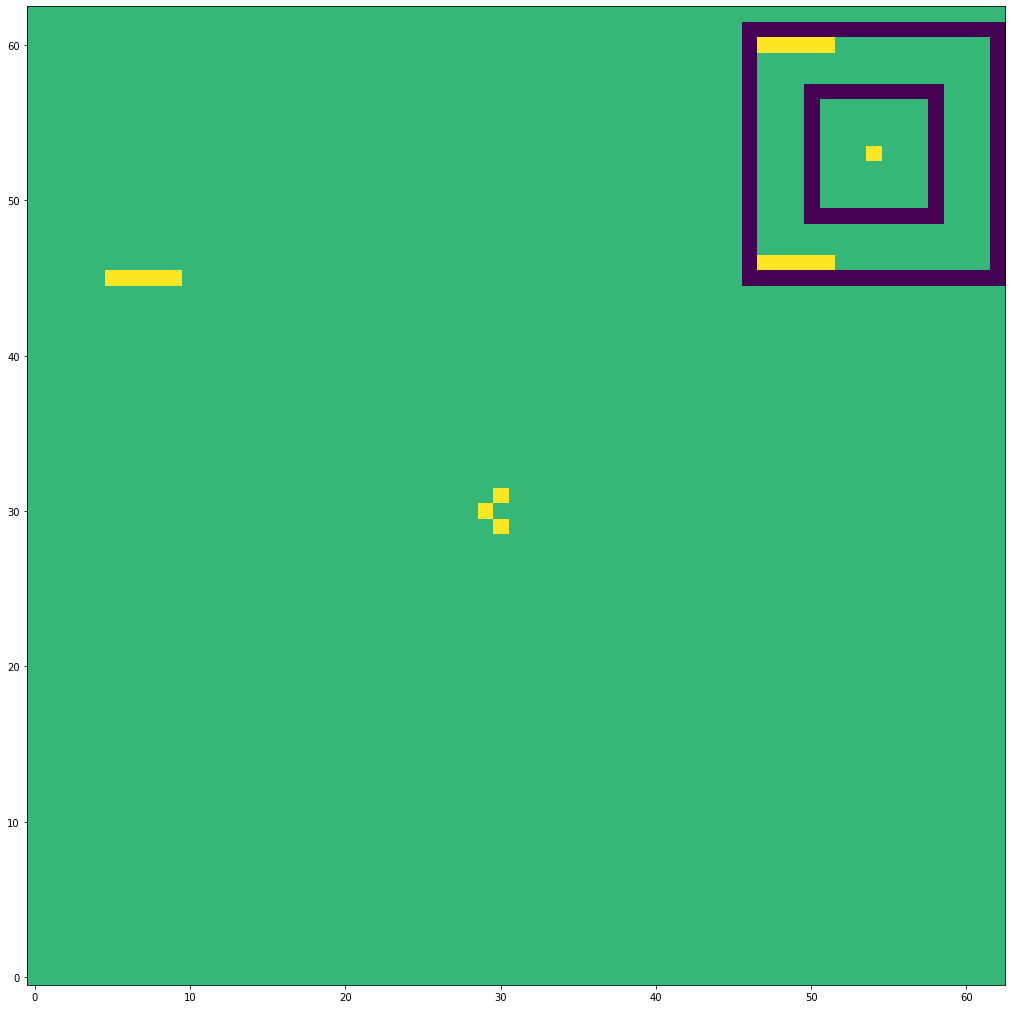

In [77]:
tot_newstar2, fsq_01 = get_flux_counts_new(mode='real', pt1_1=52, pt1_2=55, pt2_1=56, pt2_2=51, spacing_inner=2, spacing_outer=4)

Inner List: [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
Inner List Length: 81
Inner List Median: 1000.0
Inner List Mean: 1000.0
Outer List: [1000.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0

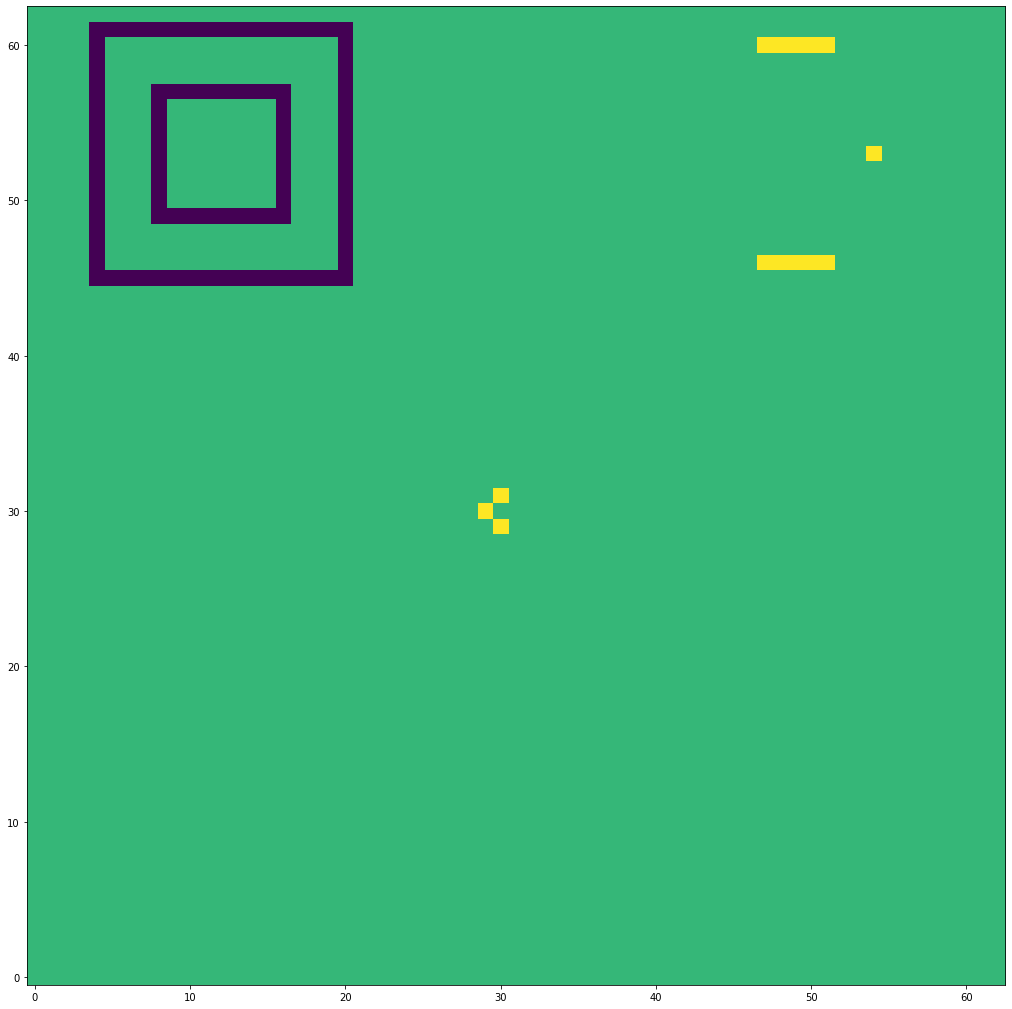

In [985]:
tot_newstar2, med_newstar2, fsq_01 = get_flux_counts_new(mode='sim', pt1_1=10, pt1_2=55, pt2_1=14, pt2_2=51, spacing_inner=2, spacing_outer=4)

## Troubleshoot Algorithm

### Simulated Image

To evaluate the algorithm's performance, I first needed to understand how the algorithm counts values within the inner and outer annuli. I simulated an image and assigned pixels wihin the outer annulus to various values. I then printed the pixel values in the region between the inner and outer annuli that are being counted by the algorithm (<code>print(outer_list)</code>). I then repeated the above process for values within the inner list.

Inner List: [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1500.0, 1000.0, 1000.0, 1000.0, 1500.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1500.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
Inner List Length: 25
Inner List Median: 1000.0
Inner List Mean: 1060.0
Outer List: [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
Outer List Length: 56
Outer List Median: 1000.0
Outer List Mean: 1000.0


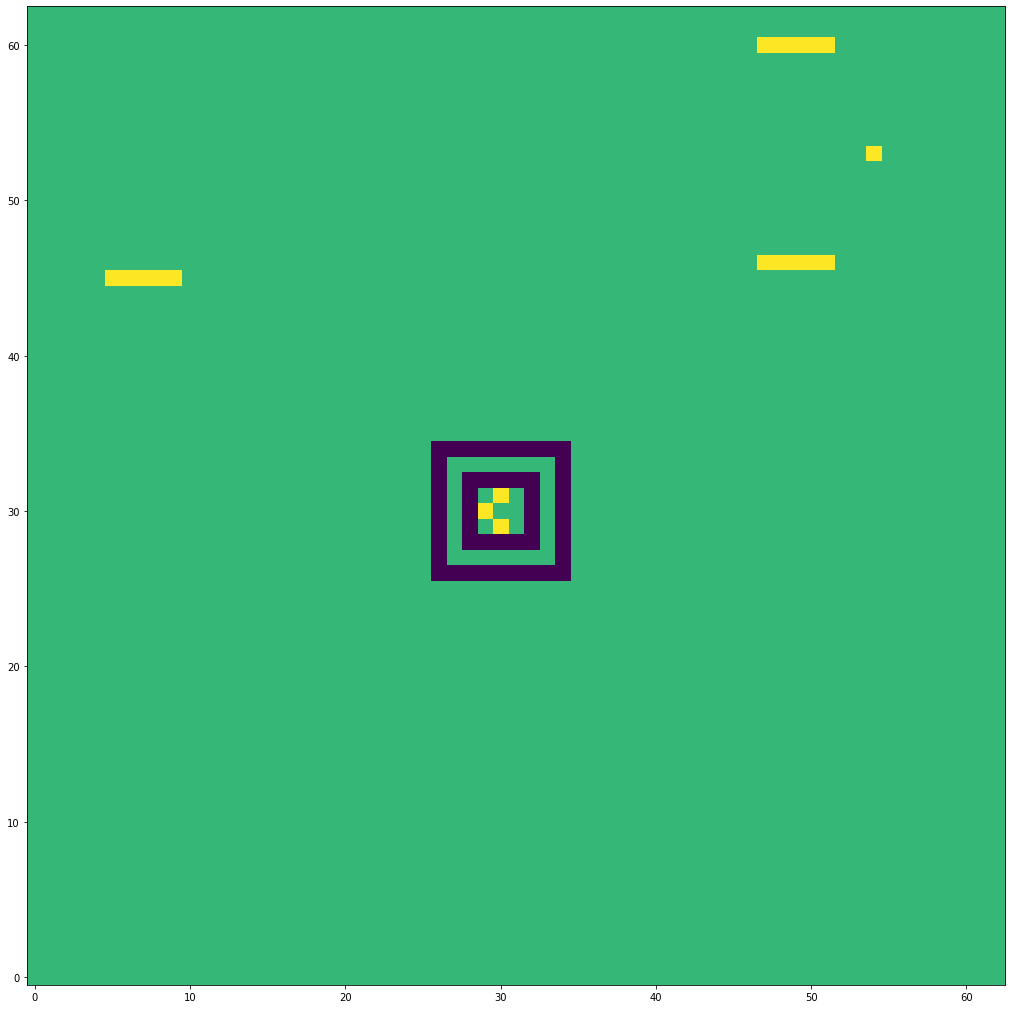

In [986]:
tot_star_sim, outer_list, fsq1, = get_flux_counts_new(mode='sim', pt1_1=28, pt1_2=32, pt2_1=32, pt2_2=28)

# std_counts = np.std(cd)

Inner List: [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1500.0, 1500.0, 1500.0, 1500.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
Inner List Length: 25
Inner List Median: 1000.0
Inner List Mean: 1080.0
Outer List: [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1500.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
Outer List Length: 56
Outer List Median: 1000.0
Outer List Mean: 1008.9285714285714


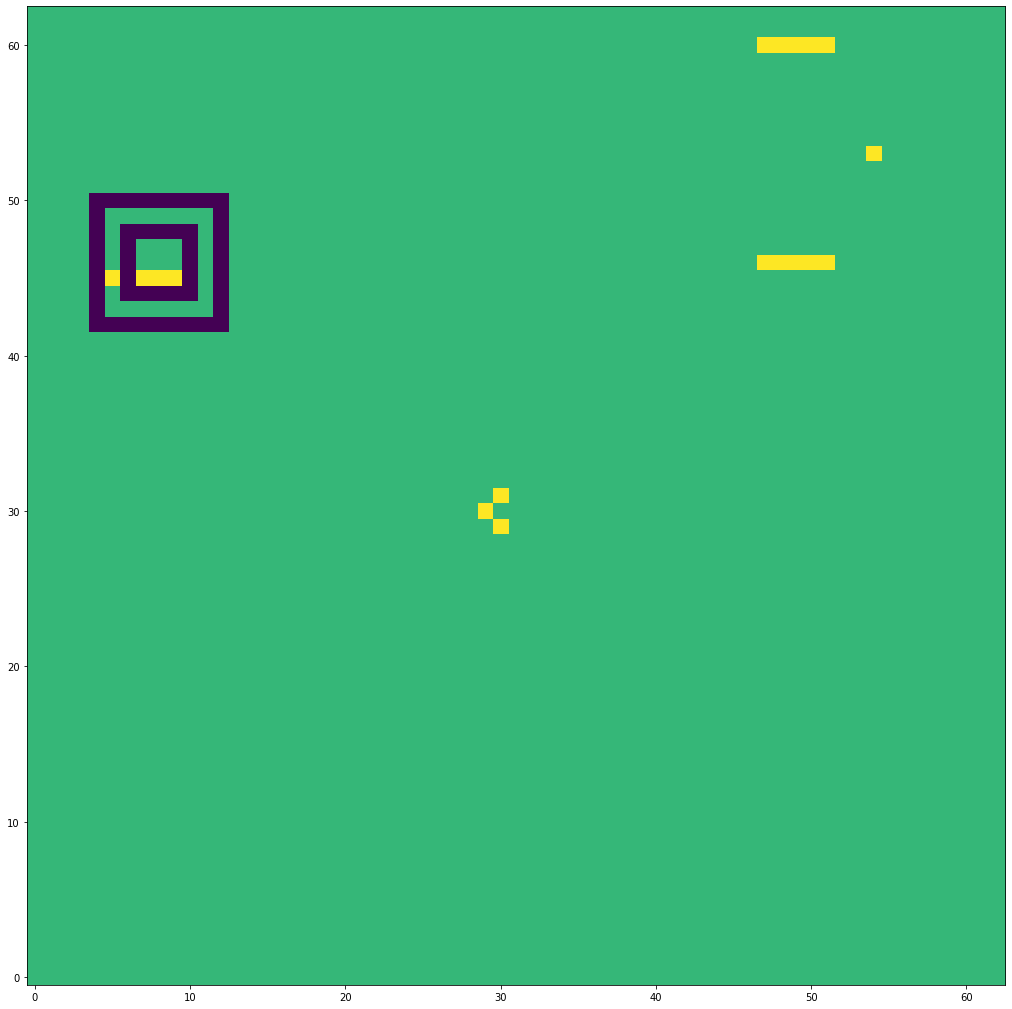

In [987]:
tot_star_sim, outer_list, fsq1, = get_flux_counts_new(mode='sim', pt1_1=6, pt1_2=48, pt2_1=10, pt2_2=44)

# std_counts = np.std(cd)
# fsq1

Inner List: [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
Inner List Length: 25
Inner List Median: 1000.0
Inner List Mean: 1000.0
Outer List: [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
Outer List Length: 56
Outer List Median: 1000.0
Outer List Mean: 1000.0


array([[[3270, 3338, 3340, ..., 3360, 3297, 3359],
        [3304, 3252, 3288, ..., 3290, 3337, 3344],
        [3366, 3313, 3275, ..., 3315, 3331, 3318],
        ...,
        [3273, 3352, 3306, ..., 3331, 3294, 3326],
        [3291, 3310, 3281, ..., 3323, 3343, 3298],
        [3335, 3303, 3342, ..., 3329, 3308, 3362]],

       [[3331, 3331, 3315, ..., 3354, 3238, 3327],
        [3344, 3323, 3310, ..., 3305, 3318, 3319],
        [3344, 3351, 3316, ..., 3374, 3341, 3338],
        ...,
        [3325, 3281, 3353, ..., 3322, 3304, 3287],
        [3331, 3308, 3286, ..., 3341, 3342, 3355],
        [3258, 3288, 3348, ..., 3371, 3346, 3307]],

       [[3316, 3342, 3299, ..., 3327, 3306, 3383],
        [3303, 3344, 3341, ..., 3354, 3348, 3378],
        [3355, 3286, 3282, ..., 3388, 3318, 3365],
        ...,
        [3288, 3326, 3363, ..., 3357, 3311, 3325],
        [3314, 3305, 3300, ..., 3326, 3343, 3329],
        [3290, 3310, 3307, ..., 3345, 3399, 3428]],

       ...,

       [[3431, 3475, 350

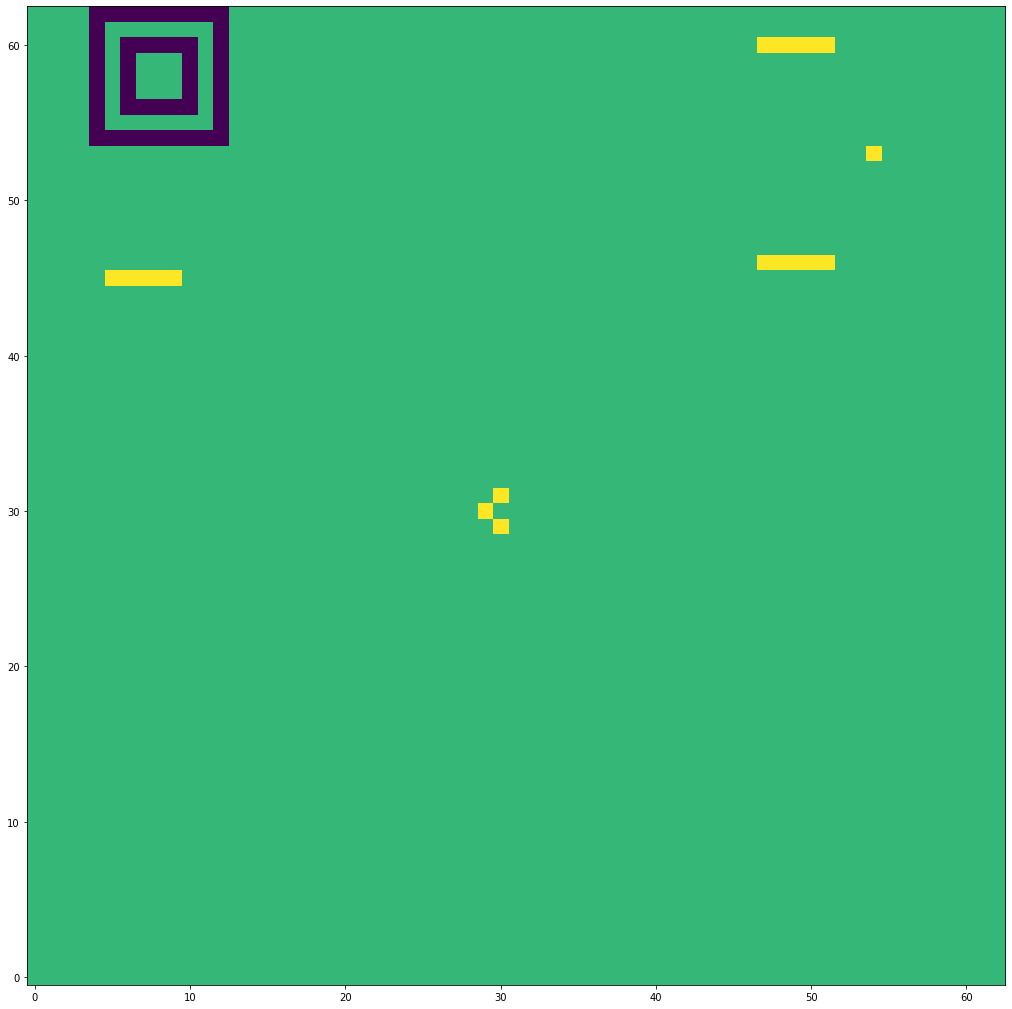

In [988]:
tot_star_sim, outer_list, fsq1, = get_flux_counts_new(mode='sim', pt1_1=6, pt1_2=60, pt2_1=10, pt2_2=56)

# std_counts = np.std(cd)
fsq1

In [989]:
# fig=plt.figure(figsize=(64,36))
# ax1 = fig.add_subplot(2,2,1)
# # ax1.axvline(fsq1[30][30], linewidth=4, color='red')
# cv2.line(fsq1, (0, 30), (63, 30), (0, 255, 0), thickness=1)
# ax1.imshow(fsq1)
# ax2 = fig.add_subplot(2,2,2)
# cv2.line(fsq2, (0, 30), (63, 30), (0, 255, 0), thickness=1)
# ax2.imshow(fsq2)

In [991]:
# Convert DS9 coords to np array coords and return value.
def ds9_coords(x_coord, y_coord, idx=-1, channel_data=fsq1, ):
    coords = (y_coord-1, x_coord-1)
    new_val = channel_data[idx][y_coord-1][x_coord-1]
    return coords, new_val

### Real Image

Now, I compare the real image in Python to the real image displayed in DS9.Note that x and y are flipped in Python vs DS9. Also remember that Python indexes from 0 so <code>frame[-1][61][62]</code> corresponds to coordinate (63, 62) DS9.

In [ ]:
tot_star_real1, fsq1, = get_flux_counts_new(mode='real', pt1_1=19, pt1_2=50, pt2_1=23, pt2_2=46, spacing_inner=1, spacing_outer=2)

In [348]:
print(np.mean(tot_star_real1))
print(np.median(tot_star_real1))
print(np.std(tot_star_real1))
print(md(tot_star_real1))
print(snr(tot_star_real1))

10744.871428571429
10754.5
402.94778716810623
218.0
49.33256880733945


In [343]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq1, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/expanded_annulus/star1.png')

2021-12-03 17:35:35.504 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-03 17:35:35.505 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-03 17:35:35.550 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-03 17:35:35.551 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-03 17:35:35.580 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-03 17:35:35.581 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-03 17:35:35.605 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-03 17:35:35.607 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3302, 3306, 3363, 3343, 3331, 3334, 3299, 3303, 3305, 3337, 3297, 3343, 3326, 3332, 3341, 3318, 3333, 3494, 3438, 3358, 3301, 3258, 3366, 3405, 4340, 3741, 3379, 3326, 3283, 3345, 3381, 3995, 3649, 3385, 3319, 3341, 3320, 3297, 3399, 3324, 3333, 3313, 3298, 3344, 3367, 3308, 3373, 3317, 3293]
Inner List Length: 49
Inner List Median: 3333.0
Inner List Mean: 3385.7755102040815
Outer List: [3417, 3407, 3312, 3275, 3305, 3299, 3353, 3263, 3335, 3311, 3356, 3353, 3358, 3298, 3283, 3304, 3254, 3297, 3323, 3311, 3348, 3291, 3307, 3316, 3323, 3337, 3347, 3352, 3299, 3347, 3353, 3385, 3296, 3354, 3269, 3316, 3329, 3365, 3389, 3326, 3314, 3251, 3384, 3312, 3301, 3311, 3279, 3298, 3300, 3350, 3359, 3303, 3345, 3315, 3246, 3338, 3359, 3490, 3364, 3304, 3316, 3334, 3374, 3358, 3301, 3301, 3357, 3348, 3438, 3382, 3272, 3312]
Outer List Length: 72
Outer List Median: 3319.5
Outer List Mean: 3328.875


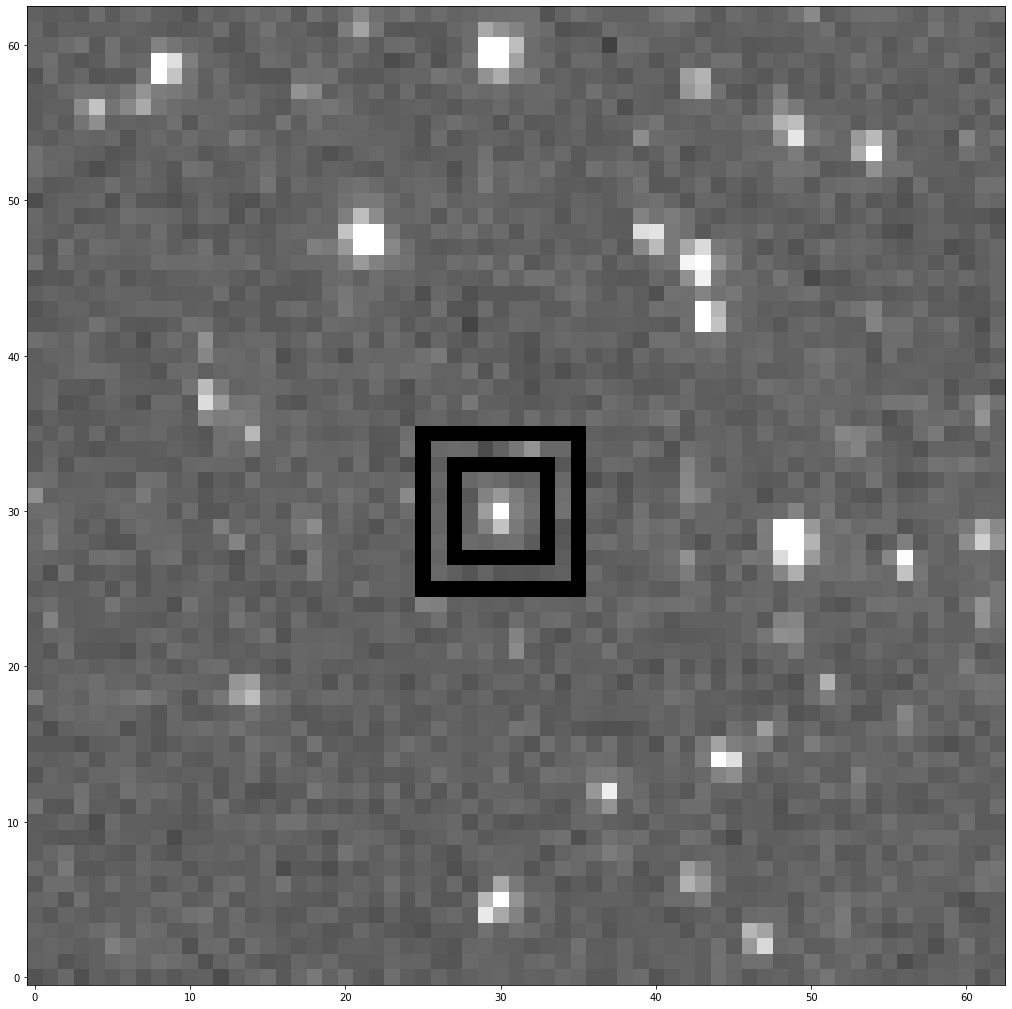

In [21]:
tot_star_real3, fsq3, = get_flux_counts_new(mode='real', pt1_1=28, pt1_2=32, pt2_1=32, pt2_2=28, spacing_inner=1, spacing_outer=2)

In [39]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq2, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/expanded_annulus/star3.png')

In [37]:
print(np.mean(tot_star_real2))
print(np.median(tot_star_real2))
print(np.std(tot_star_real2))
print(md(tot_star_real2))
print(snr(tot_star_real2))

3008.318181818182
3001.5
335.69217993486455
218.0
13.76834862385321


Inner List: [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1500.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
Inner List Length: 25
Inner List Median: 1000.0
Inner List Mean: 1020.0
Outer List: [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
Outer List Length: 56
Outer List Median: 1000.0
Outer List Mean: 1000.0


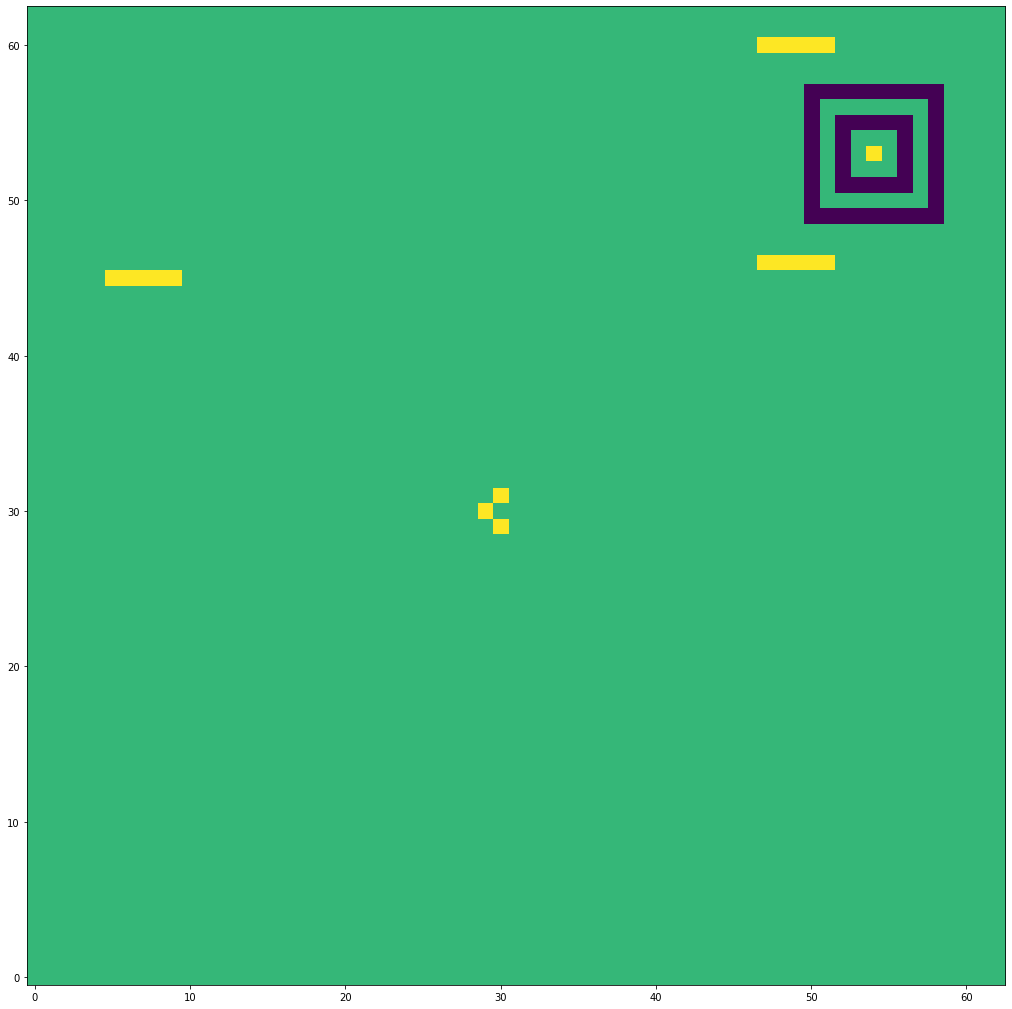

In [1001]:
tot_newstar2, med_newstar2, fsq_01 = get_flux_counts_new(mode='sim', pt1_1=52, pt1_2=55, pt2_1=56, pt2_2=51,)

2021-11-16 00:34:05.170 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-16 00:34:05.171 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-11-16 00:34:06.048 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-16 00:34:06.049 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-16 00:34:06.073 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-16 00:34:06.074 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-16 00:34:06.099 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-16 00:34:06.100 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3360, 3347, 3345, 3357, 3316, 3292, 3355, 3347, 3293, 3317, 3363, 3337, 3327, 3316, 3340, 3356, 3331, 3410, 3395, 3272, 3338, 3306, 3326, 3411, 4047, 3510, 3279, 3293, 3361, 3376, 3396, 4291, 3524, 3350, 3333, 3417, 3284, 3322, 3457, 3348, 3316, 3293, 3383, 3338, 3290, 3330, 3301, 3334, 3309]
Inner List Length: 49
Inner List Median: 3338.0
Inner List Mean: 3380.387755102041
Outer List: [3352, 3340, 3316, 3312, 3369, 3289, 3325, 3292, 3300, 3325, 3279, 3311, 3287, 3289, 3344, 3265, 3330, 3334, 3304, 3340, 3289, 3304, 3331, 3339, 3297, 3349, 3351, 3336, 3262, 3298, 3413, 3349, 3275, 3268, 3376, 3354, 3328, 3301, 3751, 3459, 3343, 3304, 4005, 3523, 3344, 3321, 3552, 3345, 3327, 3272, 3335, 3308, 3313, 3300, 3284, 3363, 3306, 3292, 3295, 3310, 3286, 3336, 3293, 3315, 3335, 3334, 3325, 3332, 3310, 3336, 3291, 3331]
Outer List Length: 72
Outer List Median: 3325.0
Outer List Mean: 3341.652777777778


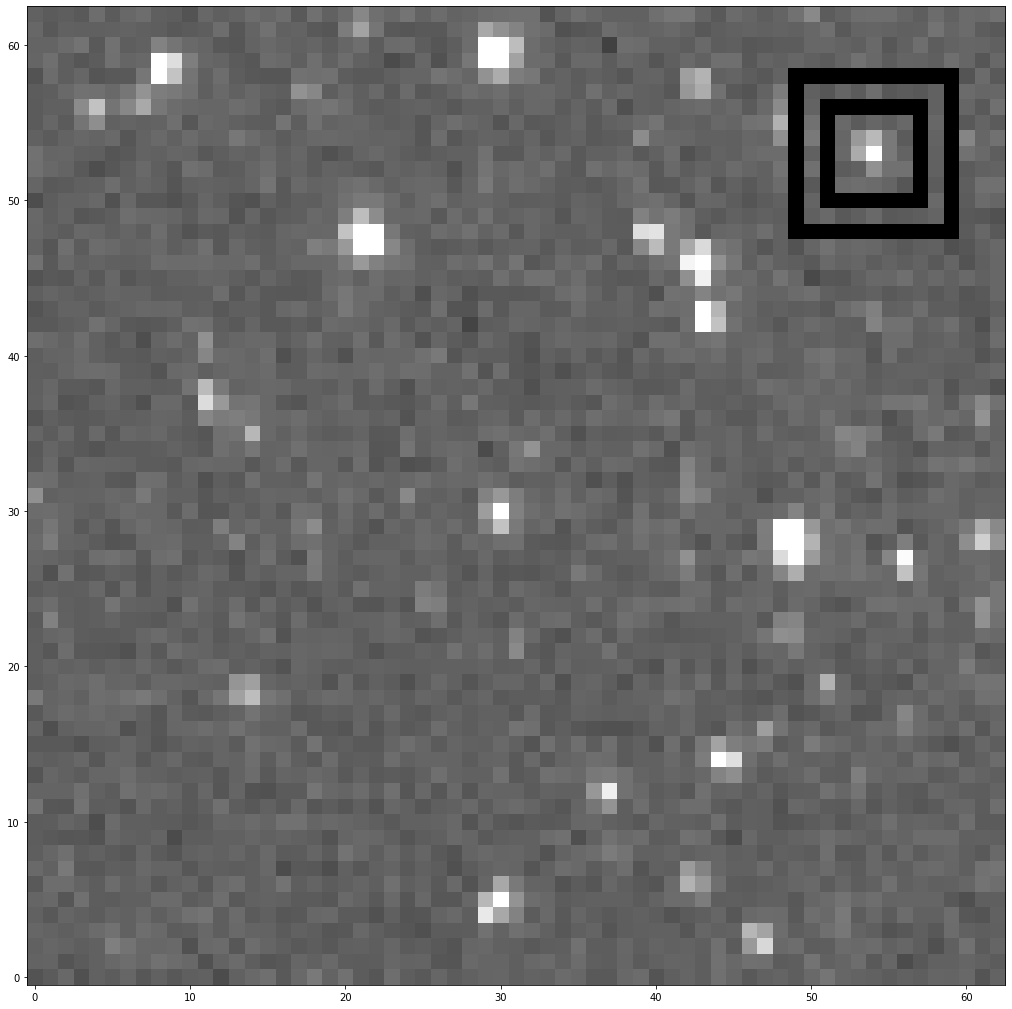

In [43]:
tot_star_real4, fsq4 = get_flux_counts_new(mode='real', pt1_1=52, pt1_2=55, pt2_1=56, pt2_2=51, spacing_inner=1, spacing_outer=2)
# print(md(tot_newstar2))

In [44]:
print(np.mean(tot_star_real4))
print(np.median(tot_star_real4))
print(np.std(tot_star_real4))
print(md(tot_star_real4))
print(snr(tot_star_real4))

2674.151515151515
2621.5
297.89744230870457
223.0
11.75560538116592


In [46]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq4, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/expanded_annulus/star4.png')

In [ ]:
tot_star_sim3, fsq1, = get_flux_counts_new(mode='real', pt1_1=19, pt1_2=50, pt2_1=23, pt2_2=46,spacing_inner=2, spacing_outer=4)

# std_counts = np.std(cd)
# cv2.circle(fsq1, (0,0), 1, [0,0,255], -1)

# fsq1[0][0] = 0
# print(md(tot_star_sim))
# tot_star_sim

In [ ]:
tot_newstar3, med_newstar3, outlist_newstar3 = get_flux_counts_new_real(channel_data=green1, pt1_1=20, pt1_2=50, pt2_1=24, pt2_2=46,spacing_inner=2, spacing_outer=4)

In [ ]:
tot_newobj5, med_newobj5, outlist_newobj5, fsqnew1 = get_flux_counts_new_real(channel_data=green1, pt1_1=52, pt1_2=47, pt2_1=56, pt2_2=43,)

In [ ]:
tot_newobj6, med_newobj6, outlist_newobj6, fsqnew2 = get_flux_counts_new_real(channel_data=green1, pt1_1=6, pt1_2=47, pt2_1=10, pt2_2=43,)

In [ ]:
tot_newobj7, med_newobj7, outlist_newobj7, fsqnew3 = get_flux_counts_new_real(channel_data=green1, pt1_1=6, pt1_2=10, pt2_1=10, pt2_2=6,)

In [ ]:
tot_newobj8, tot_inner_list8, outlist_newobj8, fsqnew4 = get_flux_counts_new_real(channel_data=green1, pt1_1=55, pt1_2=10, pt2_1=59, pt2_2=6,)

In [ ]:
tot_star_real2, fsq2 = get_flux_counts_new(mode='real', pt1_1=35, pt1_2=14, pt2_1=39, pt2_2=10, spacing_inner=1, spacing_outer=2)

In [48]:
print(np.mean(tot_star_real2))
print(np.median(tot_star_real2))
print(np.std(tot_star_real2))
print(md(tot_star_real2))
print(snr(tot_star_real2))

1546.5151515151515
1530.5
283.66966183072674
195.5
7.828644501278772


In [ ]:
fig=plt.figure(figsize=(32,18))
ax1 = fig.add_subplot(111)
ax1.imshow(fsq2, origin='lower', cmap='gray', vmin=3100, vmax=4100)
plt.savefig('green_channel_images/expanded_annulus/star2.png')

In [ ]:
#  # Get observation times, exposure time 
# header_times = np.array([fits_utils.getheader(f)['DATE-OBS'] for f in fits_files])
# header_times = np.array([s.replace('T', ' ') for s in header_times])
# header_times = [np.datetime64(i) for i in header_times]

# fig = plt.figure(figsize=(16,9))
# ax = fig.add_subplot(111)

# # ax.plot(header_times, tot_1,'ro-', label='Simulated Background')
# # ax.plot(header_times, tot_2, 'go-', label='Real Background (bottom left)')
# # ax.plot(header_times, tot_3, 'bo-', label='Real Background (upper left)')
# ax.plot(header_times, ratio1, 'go-', label=f"target/reference star (mean: {round(np.mean(ratio1),2)})")
# ax.plot(header_times, ratio2, 'bo-', label=f"reference/target star (mean: {round(np.mean(ratio2),2)})")



# # ax.plot(header_times, total_counts3, 'bo-', label='Radius(Inner, Outer): (4,6)')



# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# ax.set_xlabel('Observation Time', fontsize=20)
# ax.set_ylabel('Flux Ratio', fontsize=20)
# ax.set_title('Background Subtracted Photometry (G)', fontsize=20)
# ax.legend(fontsize=14)
# plt.show()
# # fig.savefig('bg_subtract_gnew.png')

In [49]:
star4 =tot_newstar2
new_div_lc2 = [i/j for i,j in zip(star3, star4)]
np.median(new_div_lc2)

1.1613412228796844

In [51]:
new_div_lc = [i/j for i,j in zip(star4, star2)]
np.median(new_div_lc)


1.8814279643008924

## Examine Flux Ratios

In [ ]:
 # Get observation times, exposure time 
header_times = np.array([fits_utils.getheader(f)['DATE-OBS'] for f in fits_files])
header_times = np.array([s.replace('T', ' ') for s in header_times])
header_times = [np.datetime64(i) for i in header_times]

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

# ax.plot(header_times, tot_1,'ro-', label='Simulated Background')
# ax.plot(header_times, tot_2, 'go-', label='Real Background (bottom left)')
# ax.plot(header_times, tot_3, 'bo-', label='Real Background (upper left)')
# ax.plot(header_times, tot_star_sim3, 'ro-', label=f"Star 1")
star4 = tot_newstar2
# new_div_lc = [i/j for i,j in zip(tot_newstar2, star2)]
new_div_lc1 = [i/j for i,j in zip(star1, star2)]
# new_div_lc2 = [i/j for i,j in zip(star3, star4)]


ax.plot(header_times, new_div_lc2, 'go-',)



# ax.plot(header_times, total_counts3, 'bo-', label='Radius(Inner, Outer): (4,6)')



plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlabel('Observation Time', fontsize=20)
ax.set_ylabel('Flux Ratio', fontsize=20)
ax.set_title('Background Subtracted Flux Ratio (Star 3 / Star 4) (G)', fontsize=20)
# ax.legend(fontsize=14)
plt.show()
fig.savefig('green_channel_plots/bg_subtr_flux_ratio_3over4.png')

In [ ]:
# np.median(new_div_lc)
np.median(new_div_lc1)

In [ ]:
 # Get observation times, exposure time 
header_times = np.array([fits_utils.getheader(f)['DATE-OBS'] for f in fits_files])
header_times = np.array([s.replace('T', ' ') for s in header_times])
header_times = [np.datetime64(i) for i in header_times]

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

# ax.plot(header_times, tot_1,'ro-', label='Simulated Background')
# ax.plot(header_times, tot_2, 'go-', label='Real Background (bottom left)')
# ax.plot(header_times, tot_3, 'bo-', label='Real Background (upper left)')
ax.plot(header_times, tot_newstar2, 'go-', label=f"Star 4")
# ax.plot(header_times, tot_newstar4, 'bo-', label=f"Star 2")



# ax.plot(header_times, total_counts3, 'bo-', label='Radius(Inner, Outer): (4,6)')



plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlabel('Observation Time', fontsize=20)
ax.set_ylabel('Flux Counts', fontsize=20)
ax.set_title('Background Subtracted Photometry (G)', fontsize=20)
ax.legend(fontsize=14)
plt.show()
fig.savefig('green_channel_plots/bg_photom_star4.png')

In [ ]:
#  # Get observation times, exposure time 
# header_times = np.array([fits_utils.getheader(f)['DATE-OBS'] for f in fits_files])
# header_times = np.array([s.replace('T', ' ') for s in header_times])
# header_times = [np.datetime64(i) for i in header_times]

# fig = plt.figure(figsize=(16,9))
# ax = fig.add_subplot(111)

# # ax.plot(header_times, tot_1,'ro-', label='Simulated Background')
# # ax.plot(header_times, tot_2, 'go-', label='Real Background (bottom left)')
# # ax.plot(header_times, tot_3, 'bo-', label='Real Background (upper left)')
# # ax.plot(header_times, outlist_newstar3, 'go-', label=f"Star 1")
# ax.plot(header_times, outlist_newstar, 'ro-', label=f"Star 3")



# # ax.plot(header_times, total_counts3, 'bo-', label='Radius(Inner, Outer): (4,6)')



# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# ax.set_xlabel('Observation Time', fontsize=20)
# ax.set_ylabel('Flux Counts', fontsize=20)
# ax.set_title('Counts in "Background" Annulus', fontsize=20)
# ax.legend(fontsize=14)
# plt.show()
# fig.savefig('green_channel_plots/bg_photom_background_annulus_centralstar.png')

In [ ]:
#  # Get observation times, exposure time 
# header_times = np.array([fits_utils.getheader(f)['DATE-OBS'] for f in fits_files])
# header_times = np.array([s.replace('T', ' ') for s in header_times])
# header_times = [np.datetime64(i) for i in header_times]

# fig = plt.figure(figsize=(16,9))
# ax = fig.add_subplot(111)

# # ax.plot(header_times, tot_1,'ro-', label='Simulated Background')
# # ax.plot(header_times, tot_2, 'go-', label='Real Background (bottom left)')
# # ax.plot(header_times, tot_3, 'bo-', label='Real Background (upper left)')
# ax.plot(header_times, tot_newobj5, 'ro-', label=f"Residual Background Flux 1")
# ax.plot(header_times, tot_newobj6, 'bo-', label=f"Residual Background Flux 2")
# # ax.plot(header_times, mean_resid_vals, 'go-', label=f"Mean Residual Background Flux")

# ax.axhline(y=0, color='g')



# # ax.plot(header_times, total_counts3, 'bo-', label='Radius(Inner, Outer): (4,6)')



# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# ax.set_xlabel('Observation Time', fontsize=20)
# ax.set_ylabel('Flux Counts ', fontsize=20)
# ax.set_title('Background Subtracted Photometry (G)', fontsize=20)
# ax.legend(fontsize=14)
# plt.show()
# fig.savefig('green_channel_plots/resid_bg_flux1.png')

In [ ]:
#  # Get observation times, exposure time 
# header_times = np.array([fits_utils.getheader(f)['DATE-OBS'] for f in fits_files])
# header_times = np.array([s.replace('T', ' ') for s in header_times])
# header_times = [np.datetime64(i) for i in header_times]

# fig = plt.figure(figsize=(16,9))
# ax = fig.add_subplot(111)

# # ax.plot(header_times, tot_1,'ro-', label='Simulated Background')
# # ax.plot(header_times, tot_2, 'go-', label='Real Background (bottom left)')
# # ax.plot(header_times, tot_3, 'bo-', label='Real Background (upper left)')
# ax.plot(header_times, tot_newobj5, 'ro-', label=f"Residual Background Flux 3")
# ax.plot(header_times, tot_newobj6, 'bo-', label=f"Residual Background Flux 4")
# # ax.plot(header_times, mean_resid_vals, 'go-', label=f"Residual Background Flux 2")

# ax.axhline(y=0, color='g')



# # ax.plot(header_times, total_counts3, 'bo-', label='Radius(Inner, Outer): (4,6)')



# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# ax.set_xlabel('Observation Time', fontsize=20)
# ax.set_ylabel('Flux Counts ', fontsize=20)
# ax.set_title('Background Subtracted Photometry (G)', fontsize=20)
# ax.legend(fontsize=14)
# plt.show()
# fig.savefig('green_channel_plots/resid_bg_flux2.png')

In [ ]:
#  # Get observation times, exposure time 
# header_times = np.array([fits_utils.getheader(f)['DATE-OBS'] for f in fits_files])
# header_times = np.array([s.replace('T', ' ') for s in header_times])
# header_times = [np.datetime64(i) for i in header_times]

# fig = plt.figure(figsize=(16,9))
# ax = fig.add_subplot(111)

# # ax.plot(header_times, tot_1,'ro-', label='Simulated Background')
# # ax.plot(header_times, tot_2, 'go-', label='Real Background (bottom left)')
# # ax.plot(header_times, tot_3, 'bo-', label='Real Background (upper left)')
# # ax.plot(header_times, tot_newobj5, 'ro-', label=f"Residual Background Flux 1")
# # ax.plot(header_times, tot_newobj6, 'bo-', label=f"Residual Background Flux 2")
# ax.plot(header_times, mean_resid_vals, 'ro-', label=f"Mean Residual Background Flux (Region 1 and Region 2)")

# ax.axhline(y=0, color='g')



# # ax.plot(header_times, total_counts3, 'bo-', label='Radius(Inner, Outer): (4,6)')



# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# ax.set_xlabel('Observation Time', fontsize=20)
# ax.set_ylabel('Flux Counts ', fontsize=20)
# ax.set_title('Background Subtracted Photometry (G)', fontsize=20)
# ax.legend(fontsize=14)
# plt.show()
# fig.savefig('green_channel_plots/mean_resid_bg_flux1.png')

In [ ]:
#  # Get observation times, exposure time 
# header_times = np.array([fits_utils.getheader(f)['DATE-OBS'] for f in fits_files])
# header_times = np.array([s.replace('T', ' ') for s in header_times])
# header_times = [np.datetime64(i) for i in header_times]

# fig = plt.figure(figsize=(16,9))
# ax = fig.add_subplot(111)

# # ax.plot(header_times, tot_1,'ro-', label='Simulated Background')
# # ax.plot(header_times, tot_2, 'go-', label='Real Background (bottom left)')
# # ax.plot(header_times, tot_3, 'bo-', label='Real Background (upper left)')
# ax.plot(header_times, outlist_newobj7, 'ro-', label=f"Region 3")
# ax.plot(header_times, outlist_newobj8, 'bo-', label=f"Region 4")
# # ax.plot(header_times, mean_resid_vals, 'go-', label=f"Residual Background Flux 2")

# # ax.axhline(y=0, color='g')



# # ax.plot(header_times, total_counts3, 'bo-', label='Radius(Inner, Outer): (4,6)')



# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# ax.set_xlabel('Observation Time', fontsize=20)
# ax.set_ylabel('Flux Counts ', fontsize=20)
# ax.set_title('Counts in "Background" Annulus (G)', fontsize=20)
# ax.legend(fontsize=14)
# plt.show()
# fig.savefig('green_channel_plots/bg_ann_reg3and4.png')

In [ ]:
#  # Get observation times, exposure time 
# header_times = np.array([fits_utils.getheader(f)['DATE-OBS'] for f in fits_files])
# header_times = np.array([s.replace('T', ' ') for s in header_times])
# header_times = [np.datetime64(i) for i in header_times]

# fig = plt.figure(figsize=(16,9))
# ax = fig.add_subplot(111)

# # ax.plot(header_times, tot_1,'ro-', label='Simulated Background')
# # ax.plot(header_times, tot_2, 'go-', label='Real Background (bottom left)')
# # ax.plot(header_times, tot_3, 'bo-', label='Real Background (upper left)')
# ax.plot(header_times, outlist_newobj7, 'ro-', label=f"Region 3")
# # ax.plot(header_times, tot_newobj6, 'bo-', label=f"Residual Background Flux 4")
# # ax.plot(header_times, mean_resid_vals, 'go-', label=f"Residual Background Flux 2")

# # ax.axhline(y=0, color='g')



# # ax.plot(header_times, total_counts3, 'bo-', label='Radius(Inner, Outer): (4,6)')



# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# ax.set_xlabel('Observation Time', fontsize=20)
# ax.set_ylabel('Flux Counts ', fontsize=20)
# ax.set_title('Counts in "Background" Annulus (G)', fontsize=20)
# ax.legend(fontsize=14)
# plt.show()
# # fig.savefig('green_channel_plots/resid_bg_flux2.png')

In [ ]:
#  # Get observation times, exposure time 
# frame_num = np.array([i for i in range(num_frames)])

# fig = plt.figure(figsize=(16,9))
# ax = fig.add_subplot(111)

# ax.plot(frame_num, total_counts1,'ro-', label='Radius(1,2): (2,4)')
# ax.plot(frame_num, total_counts2, 'go-', label='Radius(1,2): (3,5)')

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.xticks(frame_num)
# plt.vlines(frame_num, 0, total_counts2, linestyle="dashed", alpha=0.3)
# ax.set_xlabel('Frame Number', fontsize=20)
# ax.set_ylabel('Pixel Counts', fontsize=20)
# ax.set_title('Pixel Counts for Different Annuli', fontsize=20)
# ax.legend(fontsize=14)
# plt.show()
# fig.savefig('frames_plot_new.png')

## Stack Images
Here, we are binning the data into two groups of images. 

In [203]:
# # Stack images 
# fits_files = images_df.local_file.to_list()
# del fits_files[22]
# del fits_files[29]


In [204]:
len(fits_files)

33

In [205]:
# im_data = np.array([fits_utils.getdata(f) for f in fits_files])
# # len(im_data)/2
# # np.shape(im_data)

# stack_im_bin1 = np.median(im_data[:16], axis=0)
# stack_im_bin2 = np.median(im_data[17:-1], axis = 0)
# data_bin1 = im_data[:16]
# data_bin2 = im_data[17:-1]

In [225]:
stack_im_bin2

array([[2924., 2637., 2915., ..., 2583., 2824., 2593.],
       [2493., 2895., 2501., ..., 2810., 2449., 2838.],
       [2908., 2627., 2930., ..., 2592., 2860., 2625.],
       ...,
       [2471., 2852., 2457., ..., 2796., 2433., 2807.],
       [2604., 2582., 2829., ..., 2562., 2779., 2591.],
       [2452., 2863., 2464., ..., 2769., 2427., 2816.]])

In [56]:
green1_stack_arr2 = process_images(stacked_dat=stack_im_bin2, stamp_size=(250,250), suppress_output=True)
# np.shape(green1_stack_arr)
np.shape(green1_stack_arr2)

2021-11-12 13:39:28.642 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-12 13:39:28.643 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854


(125, 125)

In [111]:
# green1 = np.array([rgb_dat_list[i][1] for i in range(num_frames)])
np.shape(green1)

2021-11-12 17:54:07.892 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-12 17:54:07.893 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854


(16, 125, 125)

In [21]:
def snr(output1):
    signal_to_noise = np.median(output1)/np.std(output1)
    return signal_to_noise
    

In [18]:
# green1_bin1 = process_images(data=im_data[:16], stamp_size=(250,250), suppress_output=True)
# green1_bin2 = process_images(data=im_data[17:-1], stamp_size=(250,250), suppress_output=True)
# green1_stacked_bin1 = process_images(stacked_dat=stack_im_bin1, suppress_output=True)
# green1_stacked_bin2 = process_images(stacked_dat=stack_im_bin2, suppress_output=True)

In [230]:
np.shape(green1_stacked_bin2)

(63, 63)

In [64]:
# # Co-add FITS images in fours

# i = 0
# stacked_im_data = []
# while i<(len(im_data)-1):
#     stacked_im_data.append((im_data[i]+im_data[i+1] + im_data[i+2] + im_data[i+3])/4) 
#     i+=4
# stacked_im_data = np.array(stacked_im_data)

In [740]:
# hdu = fits.PrimaryHDU(stacked_im_dat)
# hdu.header.update(wcs0.to_header())
# # hdu.writeto('stacked.fits', overwrite=True)

# hdu1 = fits.PrimaryHDU(fits_utils.getdata(fits_files[6]))
# hdu1.header.update(wcs0.to_header())
# # hdu1.writeto('test_im.fits', overwrite=True)


In [755]:
# # Image index 
# # im_idx = 5
# # rgb_dat_list_stack = []

# # Display only unmasked values for each array and reshape it such that arr[0] = RED, arr[1] = GREEN1, etc...
# # for i in range(num_frames):
# rgb_dat_stack = im_rgb_full_stack[:, ][~im_rgb_full_stack[:,].mask].reshape(4,63,-1)
# # rgb_dat_stack_arr = np.array(rgb_dat_list_stack)
# # np.shape(rgb_dat_stack_arr)
# # Create green1 channel array
# green1_stack = rgb_dat_stack[1]
# # red = rgb_dat[0]
# # blue = rgb_dat[3]
# # # # Create green2 channel array
# # # # green2 = im_rgb[2]

# fig = plt.figure(figsize=(16,9))
# plt.imshow(green1_stack, origin='lower', cmap='gray', vmin=3500, vmax=4100)
# plt.savefig('green_channel_images/green_im_stacked_scaled1.png')

## Evaluate different stars in bins 1, 2.

2021-12-01 19:49:32.578 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 19:49:32.579 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 19:49:32.628 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 19:49:32.629 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 19:49:32.651 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 19:49:32.653 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 19:49:32.676 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 19:49:32.678 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3375.0625, 3380.25, 3375.0, 3344.5625, 3351.1875, 3344.4375, 3365.8125, 3386.5625, 3388.25, 3379.75, 3355.5, 3423.8125, 3861.875, 3476.75, 3378.5625, 3357.5625, 3535.5625, 4487.6875, 3590.3125, 3400.375, 3338.875, 3410.625, 3582.0625, 3451.875, 3360.375]
Inner List Length: 25
Inner List Median: 3380.25
Inner List Mean: 3468.1075
Outer List: [3333.375, 3375.75, 3338.5, 3335.5625, 3357.75, 3399.125, 3361.875, 3358.3125, 3324.4375, 3348.3125, 3409.1875, 3359.0625, 3361.5, 3358.375, 3347.625, 3338.1875, 3356.5625, 3335.5, 3369.3125, 3360.5, 3348.875, 3326.25, 3335.375, 3363.5, 3368.75, 3328.0, 3349.4375, 3368.1875, 3354.375, 3361.1875, 3342.125, 3372.0, 3352.4375, 3341.125, 3355.0, 3339.4375, 3355.6875, 3358.9375, 3340.625, 3359.1875, 3357.1875, 3342.375, 3358.625, 3378.25, 3346.125, 3352.1875, 3358.75, 3347.5, 3359.625, 3348.0625, 3334.0625, 3364.9375, 3359.875, 3362.0625, 3337.875, 3356.9375]
Outer List Length: 56
Outer List Median: 3356.125
Outer List Mean: 3353.81696428571

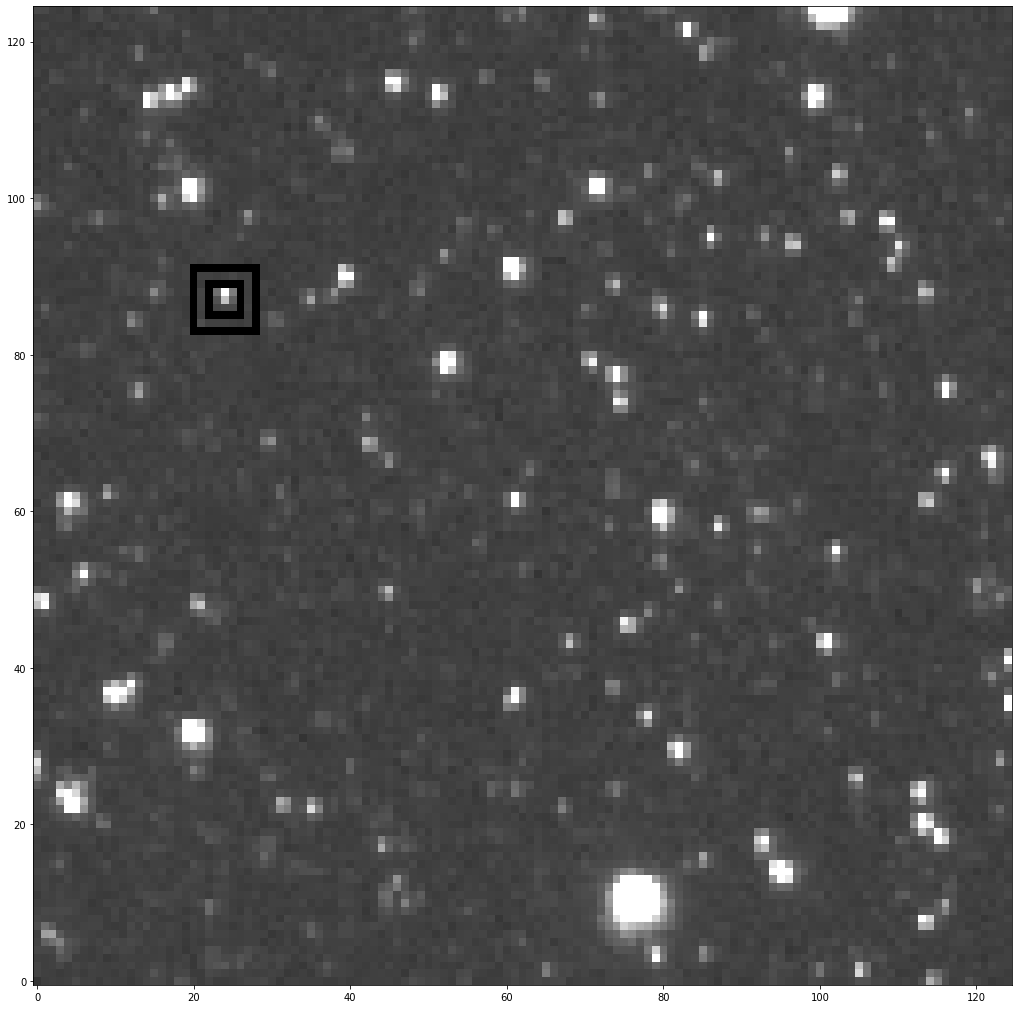

In [652]:
tot_staraneww_bin1, fsq1 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=22, pt1_2=89, pt2_1=26, pt2_2=85, dims=125,)


2021-12-01 19:49:37.777 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 19:49:37.779 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 19:49:37.822 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 19:49:37.823 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 19:49:37.846 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 19:49:37.848 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 19:49:37.871 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 19:49:37.872 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3473.266666666667, 3489.866666666667, 3469.4, 3450.6, 3443.5333333333333, 3453.866666666667, 3457.3333333333335, 3495.866666666667, 3474.6666666666665, 3487.5333333333333, 3464.2, 3557.3333333333335, 4023.5333333333333, 3567.0, 3467.733333333333, 3463.266666666667, 3656.733333333333, 4466.333333333333, 3630.0666666666666, 3506.866666666667, 3444.133333333333, 3519.6666666666665, 3655.4666666666667, 3538.9333333333334, 3465.866666666667]
Inner List Length: 25
Inner List Median: 3487.5333333333333
Inner List Mean: 3564.922666666667
Outer List: [3436.0, 3477.6666666666665, 3430.6, 3433.2, 3449.9333333333334, 3511.733333333333, 3458.3333333333335, 3455.0, 3415.866666666667, 3455.4, 3517.4, 3453.6666666666665, 3474.4, 3471.6, 3467.266666666667, 3427.733333333333, 3462.5333333333333, 3450.6666666666665, 3465.9333333333334, 3455.0, 3454.3333333333335, 3426.6, 3426.2, 3445.266666666667, 3465.5333333333333, 3444.4, 3447.4, 3470.8, 3455.0666666666666, 3456.266666666667, 3460.5333333

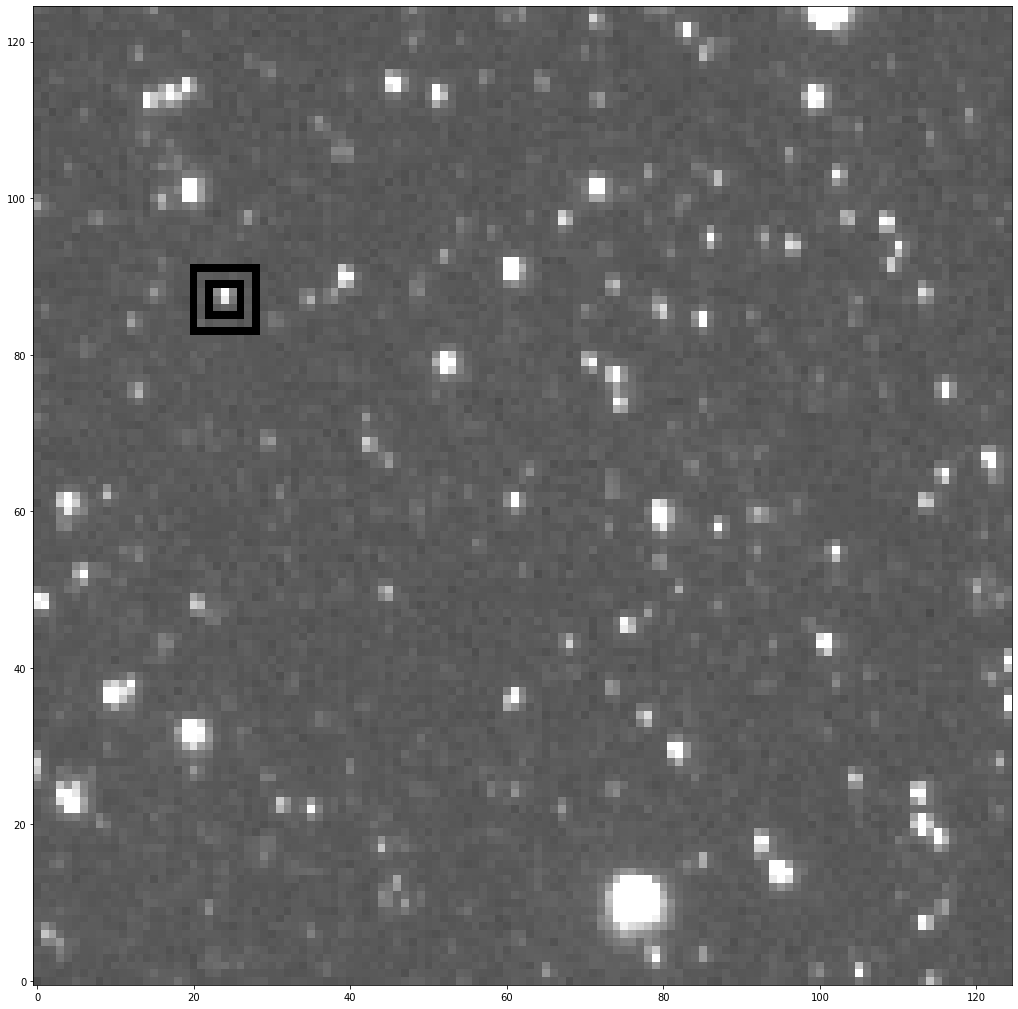

In [653]:
tot_staraneww_bin2, fsq1 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=22, pt1_2=89, pt2_1=26, pt2_2=85, dims=125,)


In [654]:
bin1_a = np.array(tot_staraneww_bin1)
bin2_a = np.array(tot_staraneww_bin2)
print(bin1_a)
print(bin2_a)
# diff1_a = abs(bin1_avg_a - bin2_avg_a)
# diff1_a
rel_change_a = np.abs(bin1_a-bin2_a)/np.mean([bin1_a, bin2_a])
rel_change_a

[2799.5625]
[2756.4]


array([0.01553736])

In [254]:
tot_staraneww_bin2

[2640.5]

In [532]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq1, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/im_stack_starA_NEW.png')

2021-12-01 05:31:30.264 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 05:31:30.266 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 05:31:30.366 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 05:31:30.368 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 05:31:30.417 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 05:31:30.419 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 05:31:30.463 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 05:31:30.465 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3357.75, 3390.625, 3369.9375, 3371.875, 3358.1875, 3354.4375, 3390.375, 3476.25, 3426.5625, 3382.3125, 3375.8125, 3504.5625, 4348.625, 3588.5625, 3412.0625, 3385.5, 3511.125, 4133.125, 3585.5625, 3405.6875, 3363.125, 3383.125, 3419.375, 3370.375, 3376.8125]
Inner List Length: 25
Inner List Median: 3390.375
Inner List Mean: 3481.67
Outer List: [3412.625, 3363.9375, 3321.4375, 3349.75, 3336.3125, 3356.25, 3341.4375, 3360.8125, 3343.75, 3366.375, 3356.25, 3366.0625, 3400.5625, 3370.3125, 3383.1875, 3378.0, 3365.1875, 3349.9375, 3381.625, 3337.75, 3363.4375, 3340.625, 3376.0, 3369.875, 3369.625, 3309.375, 3371.0625, 3342.8125, 3362.6875, 3384.25, 3377.4375, 3370.75, 3363.75, 3353.75, 3361.75, 3347.3125, 3337.375, 3344.4375, 3357.9375, 3357.0, 3365.8125, 3354.375, 3366.125, 3419.4375, 3384.3125, 3359.1875, 3337.375, 3359.75, 3369.1875, 3349.9375, 3311.875, 3358.9375, 3422.9375, 3534.375, 3396.0, 3363.25]
Outer List Length: 56
Outer List Median: 3362.96875
Outer List Mean: 3365.

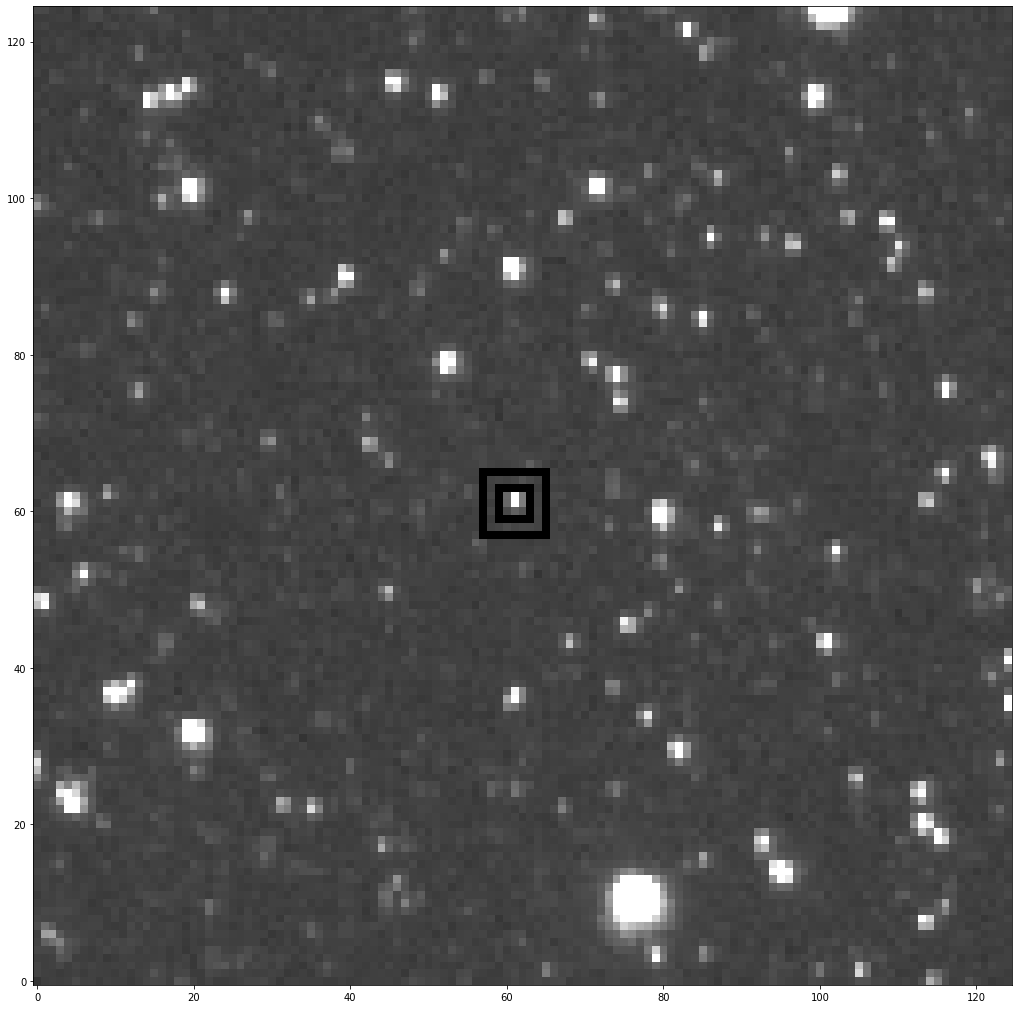

In [620]:
ref_star_bin1, fsqref = get_flux_counts_new(bin=1, mode='stacked', pt1_1=59, pt1_2=63, pt2_1=63, pt2_2=59, dims=125, )

In [ ]:
ref_star_bin1_r, fsqref = get_flux_counts_new(bin=1, mode='stacked', pt1_1=59, pt1_2=63, pt2_1=63, pt2_2=59, dims=125, )

2021-12-01 05:31:31.367 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 05:31:31.369 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 05:31:31.430 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 05:31:31.432 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 05:31:31.467 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 05:31:31.469 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 05:31:31.504 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 05:31:31.506 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3455.866666666667, 3485.5333333333333, 3491.733333333333, 3469.0, 3456.9333333333334, 3469.8, 3495.133333333333, 3634.8, 3533.733333333333, 3455.4, 3473.0, 3651.9333333333334, 4464.666666666667, 3640.8, 3506.6666666666665, 3482.4666666666667, 3618.9333333333334, 4104.333333333333, 3600.866666666667, 3489.5333333333333, 3465.133333333333, 3505.133333333333, 3502.9333333333334, 3455.0, 3480.8]
Inner List Length: 25
Inner List Median: 3491.733333333333
Inner List Mean: 3575.605333333334
Outer List: [3487.6666666666665, 3458.2, 3421.4666666666667, 3436.733333333333, 3447.133333333333, 3445.6, 3436.0666666666666, 3470.133333333333, 3443.5333333333333, 3459.866666666667, 3455.8, 3466.2, 3484.6, 3469.5333333333333, 3455.0666666666666, 3471.3333333333335, 3466.6666666666665, 3444.9333333333334, 3479.866666666667, 3428.0666666666666, 3460.133333333333, 3442.9333333333334, 3475.266666666667, 3464.133333333333, 3485.4666666666667, 3406.4, 3478.4666666666667, 3432.0, 3464.933333333333

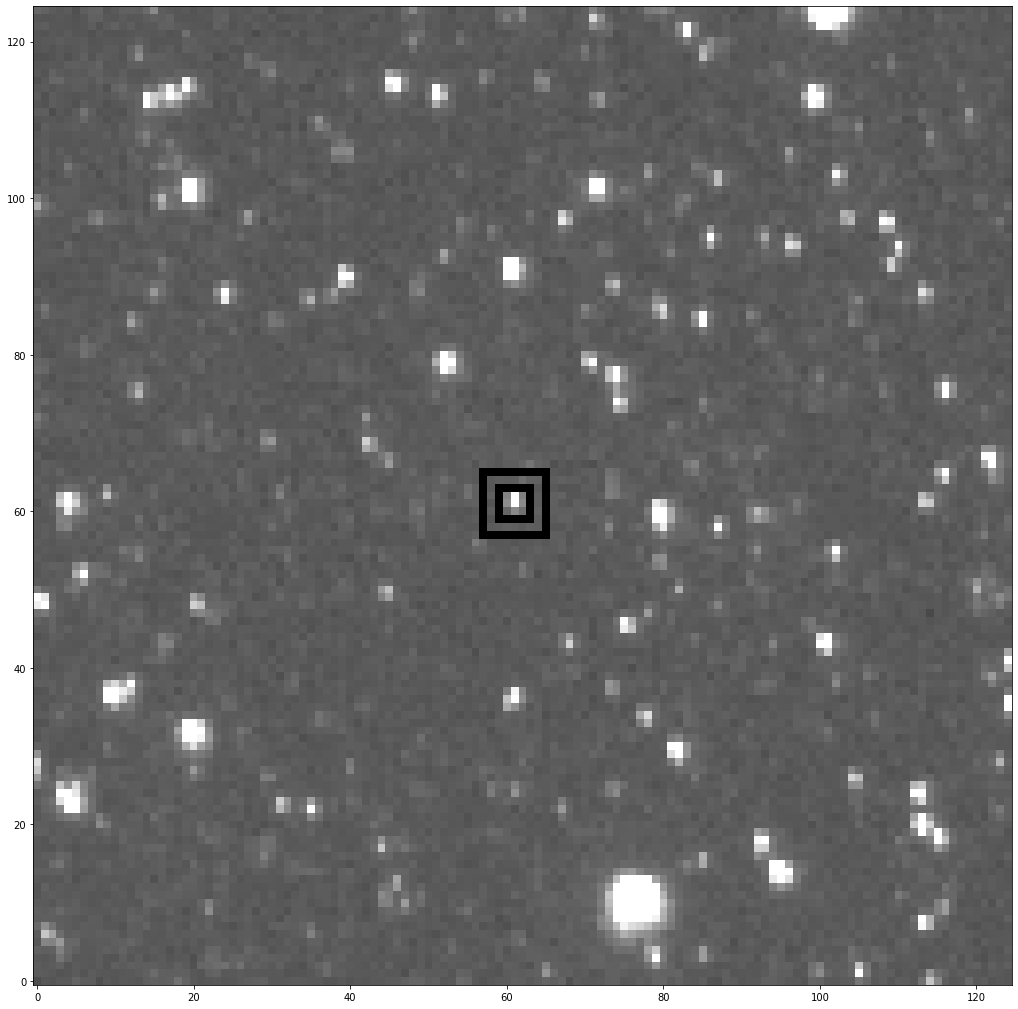

In [621]:
ref_star_bin2, fsqref = get_flux_counts_new(bin=2, mode='stacked', pt1_1=59, pt1_2=63, pt2_1=63, pt2_2=59, dims=125, )

In [622]:
bin1_ref = np.mean(ref_star_bin1)
bin2_ref = np.mean(ref_star_bin2)
diff1_b = abs(bin1_ref - bin2_ref)
rel_change_b = diff1_b / np.mean([bin1_ref, bin2_ref])
# rel_change_b
print(bin1_ref)
print(bin2_ref)
print(rel_change_b)

2967.53125
2770.133333333346
0.06880775751167177


In [212]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq2, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/im_stack_starB.png')

2021-12-01 04:05:03.255 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:05:03.256 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:05:03.295 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:05:03.296 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:05:03.319 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:05:03.320 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:05:03.343 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:05:03.344 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3360.125, 3380.5, 3417.375, 3380.3125, 3400.4375, 3343.8125, 3462.0, 4148.5625, 3570.4375, 3392.0625, 3355.25, 3547.125, 4968.375, 3667.75, 3395.625, 3354.8125, 3408.3125, 3616.9375, 3449.5625, 3375.5, 3356.0625, 3360.4375, 3375.8125, 3355.375, 3349.5]
Inner List Length: 25
Inner List Median: 3392.0625
Inner List Mean: 3511.6825
Outer List: [3339.8125, 3333.4375, 3360.75, 3346.0, 3364.0625, 3360.0, 3368.0625, 3376.25, 3373.125, 3346.5625, 3337.3125, 3362.8125, 3350.5625, 3362.5625, 3373.625, 3357.4375, 3372.9375, 3374.5625, 3375.125, 3355.3125, 3340.8125, 3366.0, 3370.0625, 3368.875, 3398.75, 3370.9375, 3359.3125, 3344.75, 3383.6875, 3364.9375, 3372.0, 3330.8125, 3359.6875, 3380.0, 3342.0625, 3339.1875, 3350.3125, 3355.1875, 3336.6875, 3338.5, 3366.5625, 3379.625, 3339.125, 3372.375, 3381.1875, 3359.1875, 3347.75, 3342.0, 3326.8125, 3372.5, 3352.5, 3355.5625, 3354.25, 3356.625, 3345.5, 3366.125]
Outer List Length: 56
Outer List Median: 3359.5
Outer List Mean: 3358.58147321

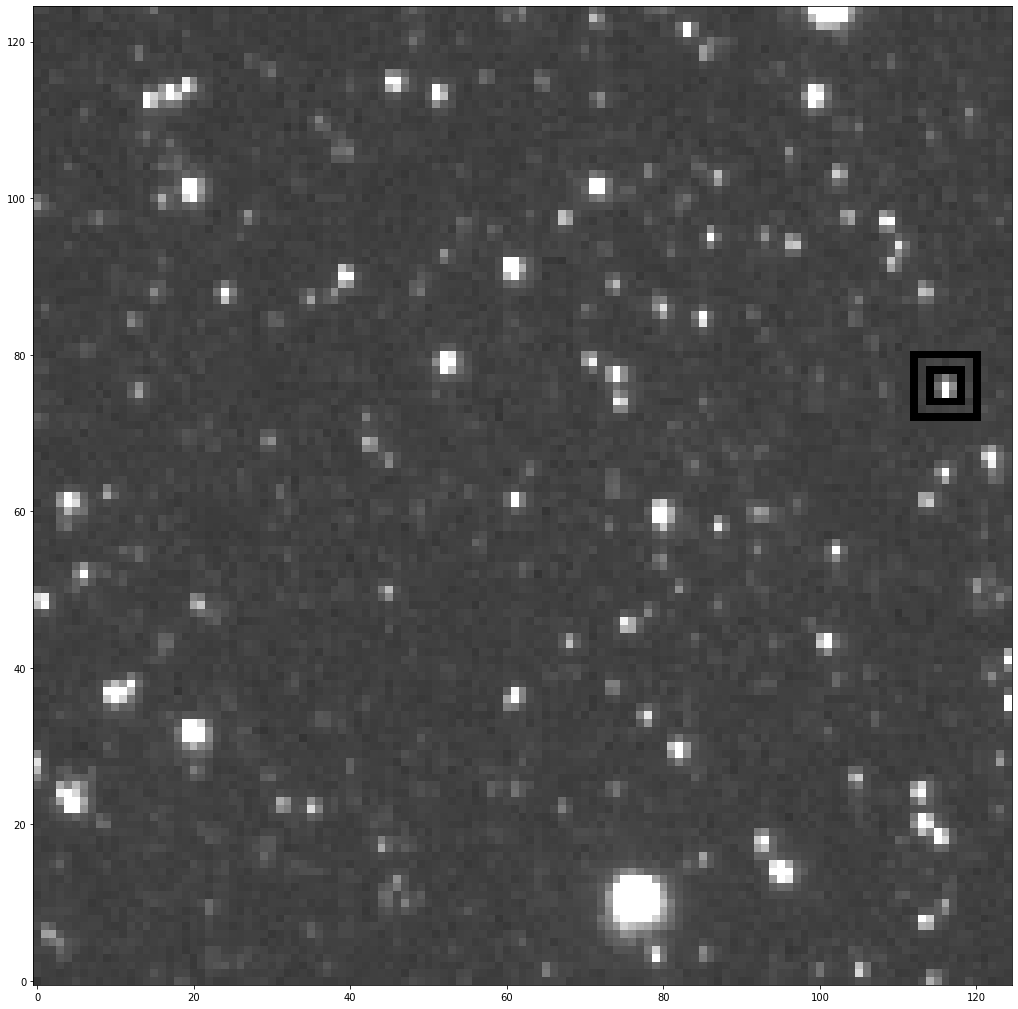

In [533]:
tot_starc_bin1, fsq3 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=114, pt1_2=78, pt2_1=118, pt2_2=74, dims=125, )

2021-12-01 04:05:22.300 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:05:22.301 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:05:22.342 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:05:22.343 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:05:22.365 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:05:22.367 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:05:22.387 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:05:22.388 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3459.133333333333, 3491.733333333333, 3562.8, 3476.6, 3500.3333333333335, 3445.266666666667, 3607.133333333333, 4500.066666666667, 3646.266666666667, 3481.2, 3458.133333333333, 3666.133333333333, 4755.666666666667, 3667.133333333333, 3482.3333333333335, 3445.866666666667, 3509.5333333333333, 3626.266666666667, 3513.866666666667, 3463.6666666666665, 3453.4666666666667, 3458.4, 3462.8, 3461.2, 3446.733333333333]
Inner List Length: 25
Inner List Median: 3482.3333333333335
Inner List Mean: 3601.6693333333333
Outer List: [3433.733333333333, 3423.133333333333, 3451.266666666667, 3450.3333333333335, 3461.866666666667, 3455.4666666666667, 3473.3333333333335, 3460.0666666666666, 3463.6666666666665, 3442.4, 3444.866666666667, 3447.5333333333333, 3457.0, 3469.4, 3475.2, 3459.3333333333335, 3473.133333333333, 3475.133333333333, 3460.0666666666666, 3453.4666666666667, 3438.4666666666667, 3462.5333333333333, 3455.133333333333, 3453.6, 3492.5333333333333, 3446.866666666667, 3447.93333333

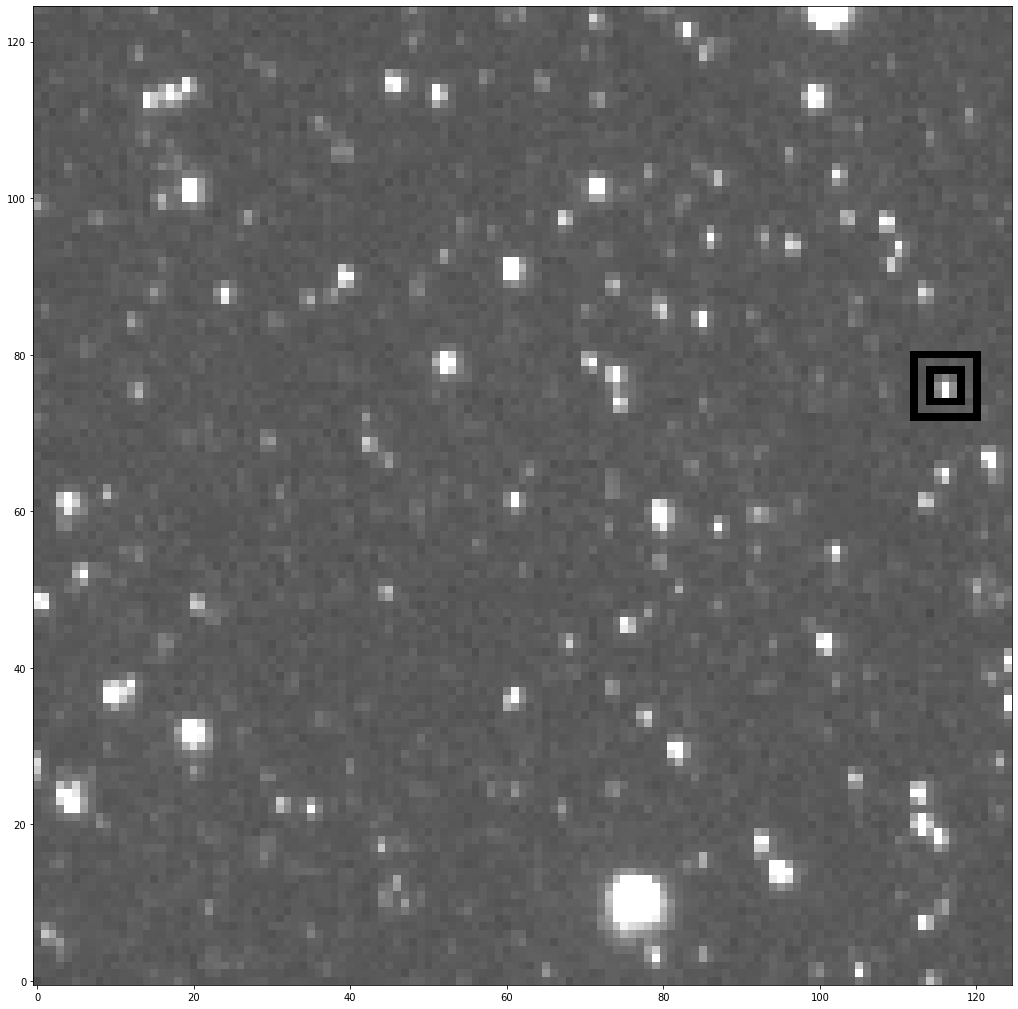

In [534]:
tot_starc_bin2, fsq3 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=114, pt1_2=78, pt2_1=118, pt2_2=74, dims=125, )

In [536]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq3, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/im_stack_starC.png')

In [537]:
bin1_avg_c = np.mean(tot_starc_bin1)
bin2_avg_c = np.mean(tot_starc_bin2)
diff1_c = abs(bin1_avg_c - bin2_avg_c)
print(bin1_avg_c)
print(bin2_avg_c)
print(rel_change_c)
rel_change_c = diff1_c / np.mean([bin1_avg_c, bin2_avg_c])

3804.5625
3683.399999999994
0.043468005526165046


2021-12-01 04:06:58.914 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:06:58.915 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:06:58.955 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:06:58.956 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:06:58.979 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:06:58.981 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:06:59.004 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:06:59.005 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3360.5625, 3389.6875, 3374.4375, 3398.6875, 3365.375, 3348.75, 3465.125, 3652.4375, 3424.125, 3406.6875, 3369.875, 3909.25, 5071.125, 3562.4375, 3443.5, 3364.8125, 3777.625, 4390.6875, 3506.6875, 3420.75, 3452.875, 3423.75, 3428.5, 3388.4375, 3378.9375]
Inner List Length: 25
Inner List Median: 3423.75
Inner List Mean: 3563.005
Outer List: [3334.3125, 3334.25, 3345.8125, 3358.5625, 3379.9375, 3501.6875, 3428.25, 3371.625, 3353.3125, 3358.8125, 3360.625, 3375.6875, 3354.0625, 3384.5625, 3391.6875, 3373.25, 3382.75, 3366.125, 3354.3125, 3337.25, 3370.625, 3358.8125, 3348.4375, 3337.875, 3378.4375, 3368.1875, 3340.125, 3350.3125, 3383.3125, 3368.1875, 3377.0, 3361.3125, 3376.5625, 3371.0, 3353.75, 3384.5, 3359.875, 3359.0, 3360.125, 3423.3125, 3478.6875, 3369.25, 3383.6875, 3364.0625, 3360.4375, 3372.9375, 3351.4375, 3352.4375, 3361.0, 3359.5625, 3346.0, 3391.75, 3407.75, 3342.125, 3365.875, 3345.1875]
Outer List Length: 56
Outer List Median: 3362.6875
Outer List Mean: 3370.17

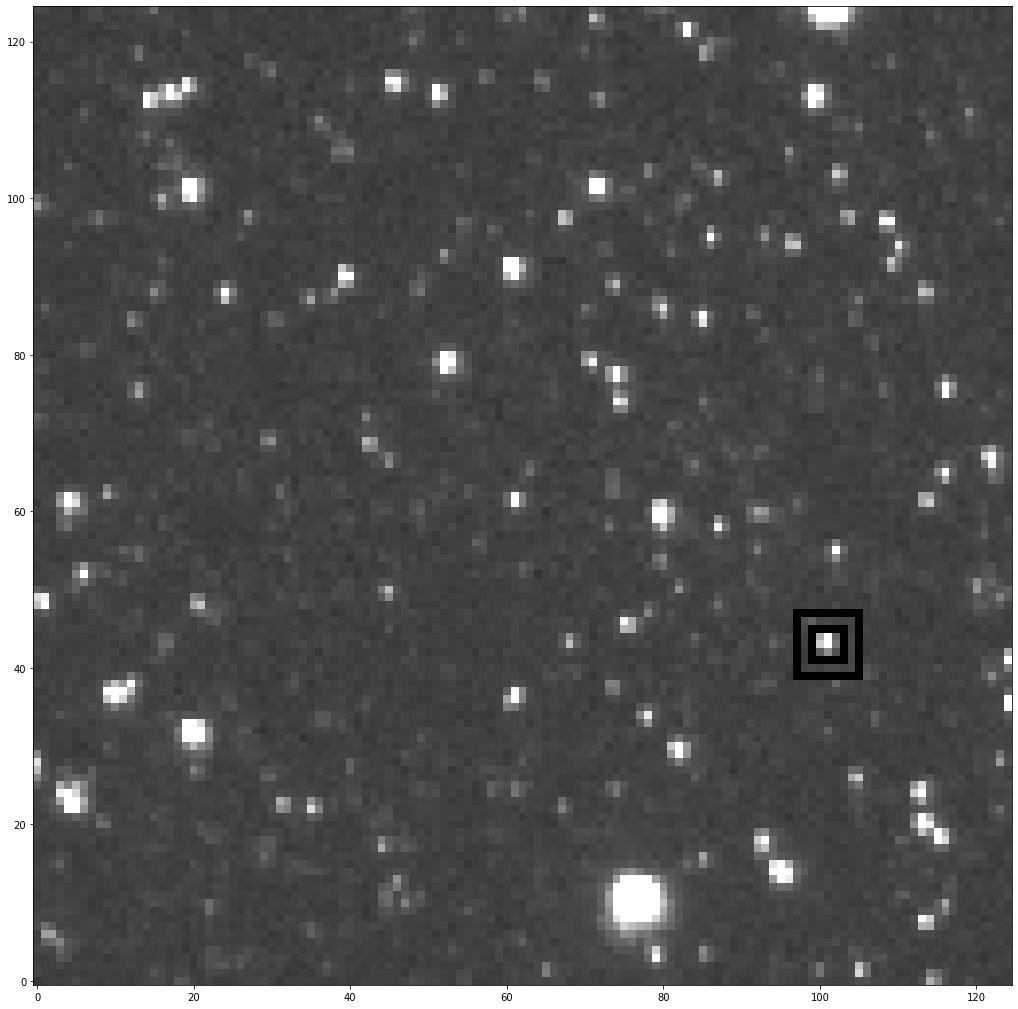

In [538]:
tot_stard_bin1, fsq4 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=99, pt1_2=45, pt2_1=103, pt2_2=41, dims=125, )

2021-12-01 04:07:24.701 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:07:24.704 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:07:24.745 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:07:24.747 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:07:24.770 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:07:24.771 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:07:24.802 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:07:24.803 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3459.9333333333334, 3490.3333333333335, 3475.266666666667, 3505.4, 3459.866666666667, 3444.4, 3635.2, 3905.0, 3525.5333333333333, 3499.6, 3479.733333333333, 4190.266666666666, 4959.666666666667, 3611.2, 3529.6, 3479.4, 3972.0666666666666, 4183.733333333334, 3560.3333333333335, 3512.4, 3563.3333333333335, 3538.2, 3512.8, 3468.4666666666667, 3469.133333333333]
Inner List Length: 25
Inner List Median: 3512.8
Inner List Mean: 3657.2346666666667
Outer List: [3421.4, 3446.866666666667, 3453.0, 3463.0666666666666, 3478.266666666667, 3570.866666666667, 3501.6666666666665, 3462.5333333333333, 3451.6, 3453.5333333333333, 3455.0, 3480.133333333333, 3473.5333333333333, 3489.5333333333333, 3473.9333333333334, 3469.0666666666666, 3483.3333333333335, 3470.6666666666665, 3444.866666666667, 3431.4, 3479.4666666666667, 3442.4666666666667, 3446.133333333333, 3425.4666666666667, 3473.9333333333334, 3465.133333333333, 3429.133333333333, 3448.9333333333334, 3478.6666666666665, 3463.8, 3464.0, 3

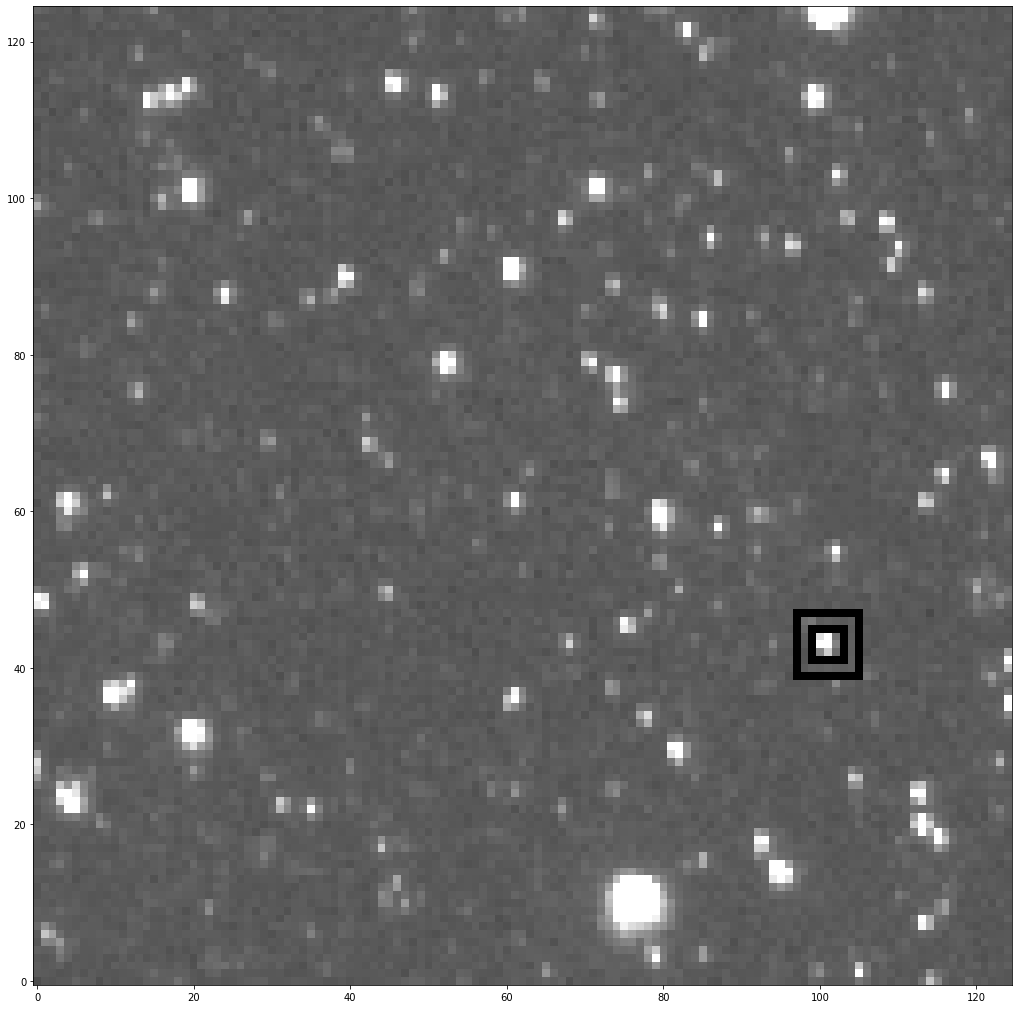

In [539]:
tot_stard_bin2, fsq4 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=99, pt1_2=45, pt2_1=103, pt2_2=41, dims=125, )

In [541]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq4, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/im_stack_starD.png')

In [542]:
bin1_avg_d = np.mean(tot_stard_bin1)
bin2_avg_d = np.mean(tot_stard_bin2)
diff1_d = abs(bin1_avg_d - bin2_avg_d)
print(bin1_avg_d)
print(bin2_avg_d)
print(rel_change_d)
rel_change_d = diff1_d / np.mean([bin1_avg_d, bin2_avg_d])

5007.9375
4845.0333333332965
0.029913114378169032


2021-12-01 04:08:37.904 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:08:37.905 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:08:37.947 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:08:37.949 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:08:37.970 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:08:37.971 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:08:37.991 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:08:37.993 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3375.4375, 3424.6875, 3449.0625, 3371.8125, 3370.8125, 3394.5625, 3785.8125, 3982.9375, 3519.1875, 3419.375, 3399.4375, 4418.3125, 4501.1875, 3607.6875, 3410.875, 3369.9375, 3641.625, 3611.625, 3466.125, 3388.1875, 3369.9375, 3344.625, 3356.75, 3374.6875, 3346.0625]
Inner List Length: 25
Inner List Median: 3410.875
Inner List Mean: 3548.03
Outer List: [3365.375, 3370.875, 3363.5, 3350.3125, 3372.6875, 3339.875, 3358.375, 3372.3125, 3353.0625, 3347.75, 3371.625, 3349.9375, 3389.0, 3381.6875, 3366.75, 3360.5625, 3341.5625, 3403.8125, 3347.375, 3333.125, 3355.0625, 3460.6875, 3368.5625, 3350.0625, 3376.375, 3423.125, 3375.5, 3375.625, 3367.125, 3393.875, 3360.0625, 3348.4375, 3368.5625, 3370.125, 3342.125, 3327.0, 3362.9375, 3353.375, 3372.125, 3330.6875, 3340.4375, 3346.75, 3341.0, 3360.5, 3368.5625, 3373.375, 3358.875, 3350.9375, 3367.0, 3348.5625, 3367.0625, 3354.0625, 3348.125, 3417.0625, 3370.4375, 3366.375]
Outer List Length: 56
Outer List Median: 3363.21875
Outer List 

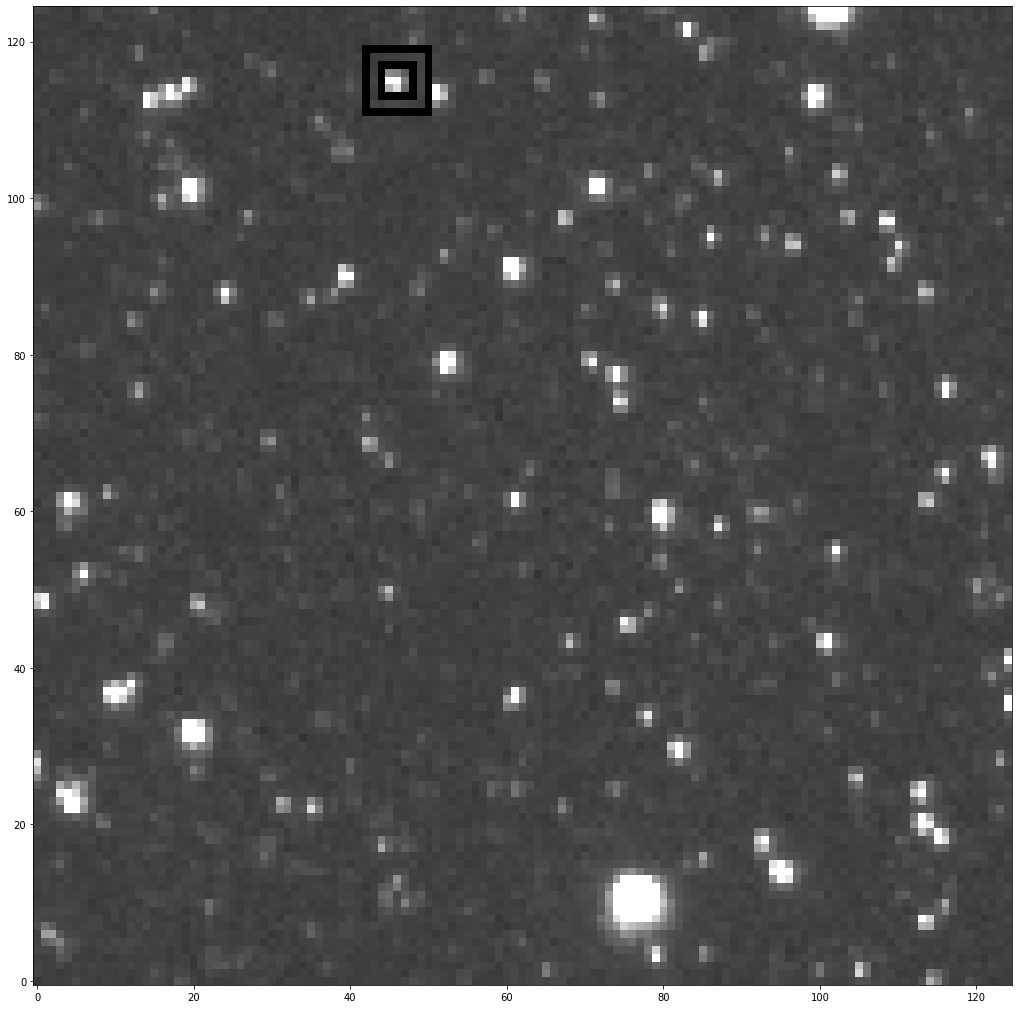

In [543]:
tot_starenew_bin1, fsq5 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=44, pt1_2=117, pt2_1=48, pt2_2=113, dims=125, )

2021-12-01 04:08:38.559 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:08:38.560 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:08:38.596 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:08:38.598 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:08:38.619 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:08:38.620 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:08:38.640 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:08:38.641 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3483.266666666667, 3541.4666666666667, 3570.5333333333333, 3474.266666666667, 3487.8, 3500.0666666666666, 3977.733333333333, 4106.866666666667, 3611.733333333333, 3501.266666666667, 3501.2, 4538.133333333333, 4392.8, 3660.9333333333334, 3494.2, 3477.4666666666667, 3749.0, 3656.3333333333335, 3532.4, 3490.133333333333, 3478.5333333333333, 3444.266666666667, 3452.266666666667, 3465.9333333333334, 3442.9333333333334]
Inner List Length: 25
Inner List Median: 3501.2
Inner List Mean: 3641.261333333334
Outer List: [3468.4, 3462.4, 3454.733333333333, 3460.6, 3464.4666666666667, 3442.9333333333334, 3466.0666666666666, 3472.0666666666666, 3457.0666666666666, 3447.9333333333334, 3474.0666666666666, 3451.8, 3488.866666666667, 3487.4666666666667, 3479.866666666667, 3448.733333333333, 3435.0, 3501.6, 3460.4, 3438.5333333333333, 3444.4, 3564.733333333333, 3460.6, 3456.866666666667, 3474.6, 3523.3333333333335, 3471.5333333333333, 3458.3333333333335, 3471.3333333333335, 3503.133333333333, 

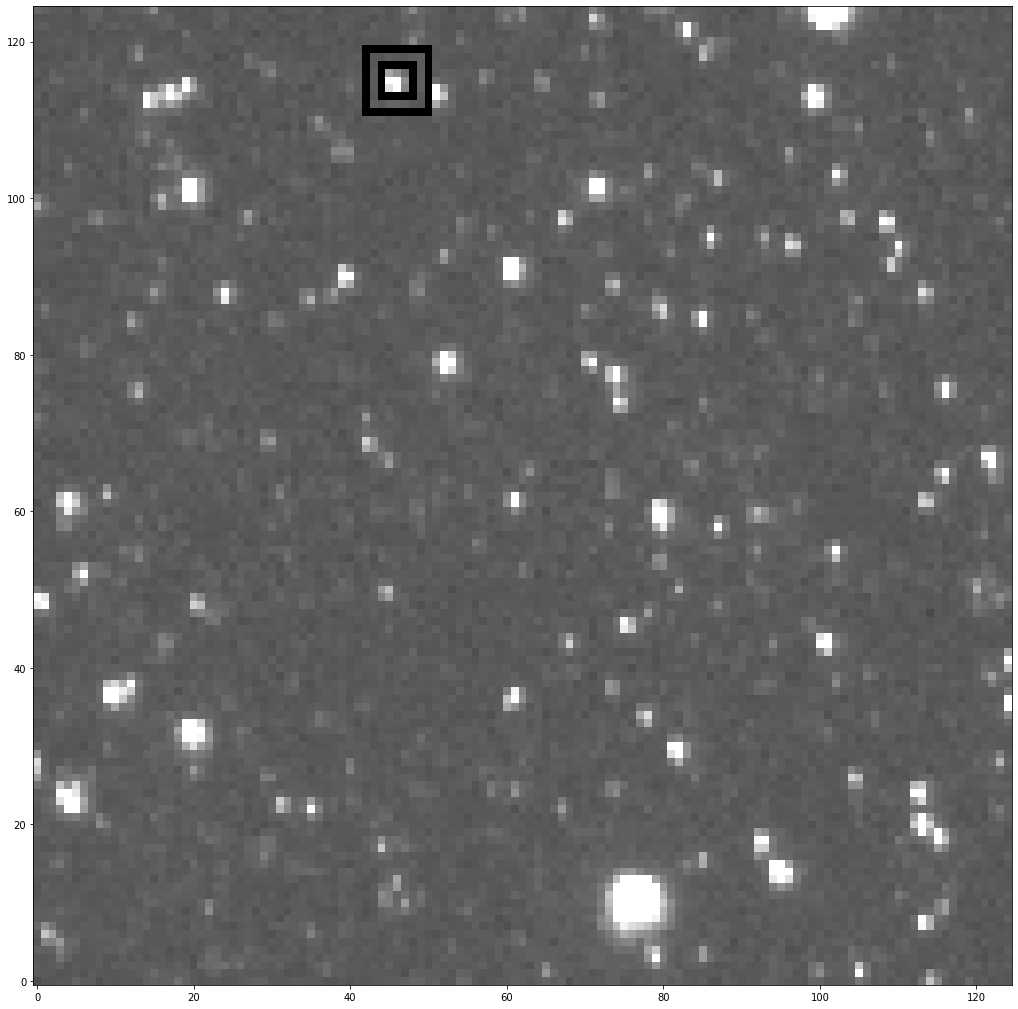

In [544]:
tot_starenew_bin2, fsq5 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=44, pt1_2=117, pt2_1=48, pt2_2=113, dims=125, )

In [545]:
bin1_avg_e = np.mean(tot_starenew_bin1)
bin2_avg_e = np.mean(tot_starenew_bin2)
diff1_e = abs(bin1_avg_e - bin2_avg_e)
print(bin1_avg_e)
print(bin2_avg_e)
# print(diff1_e)
rel_change_e = diff1_e / np.mean([bin1_avg_e, bin2_avg_e])
print(rel_change_e)

4620.28125
4536.533333333326
0.018291932397344217


In [547]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq5, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/im_stack_starE_NEW.png')

2021-12-01 04:10:06.546 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:10:06.547 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:10:06.591 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:10:06.592 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:10:06.615 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:10:06.617 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:10:06.641 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:10:06.642 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3370.125, 3376.5625, 3393.8125, 3404.5, 3416.8125, 3375.9375, 3443.9375, 3589.4375, 3456.6875, 3406.3125, 3360.375, 3688.6875, 5153.9375, 3668.0625, 3408.375, 3375.4375, 3876.5625, 5393.25, 3697.6875, 3436.8125, 3359.0625, 3455.25, 3562.8125, 3437.3125, 3429.875]
Inner List Length: 25
Inner List Median: 3436.8125
Inner List Mean: 3621.505
Outer List: [3352.125, 3348.125, 3332.5, 3364.0625, 3360.125, 3361.875, 3385.125, 3366.9375, 3361.3125, 3362.875, 3346.0625, 3365.1875, 3358.5, 3362.25, 3352.625, 3461.75, 3387.625, 3341.5, 3366.0625, 3370.25, 3413.5625, 3358.375, 3364.5, 3368.8125, 3391.5625, 3375.875, 3362.0, 3363.6875, 3384.3125, 3380.875, 3360.1875, 3345.8125, 3388.75, 3369.625, 3355.125, 3366.0, 3387.25, 3353.125, 3400.6875, 3367.625, 3350.0625, 3396.1875, 3385.3125, 3373.4375, 3372.375, 3349.1875, 3367.9375, 3684.3125, 3404.125, 3369.0625, 3361.9375, 3333.0625, 3432.5, 3392.0, 3353.875, 3353.875]
Outer List Length: 56
Outer List Median: 3365.59375
Outer List Mean: 3

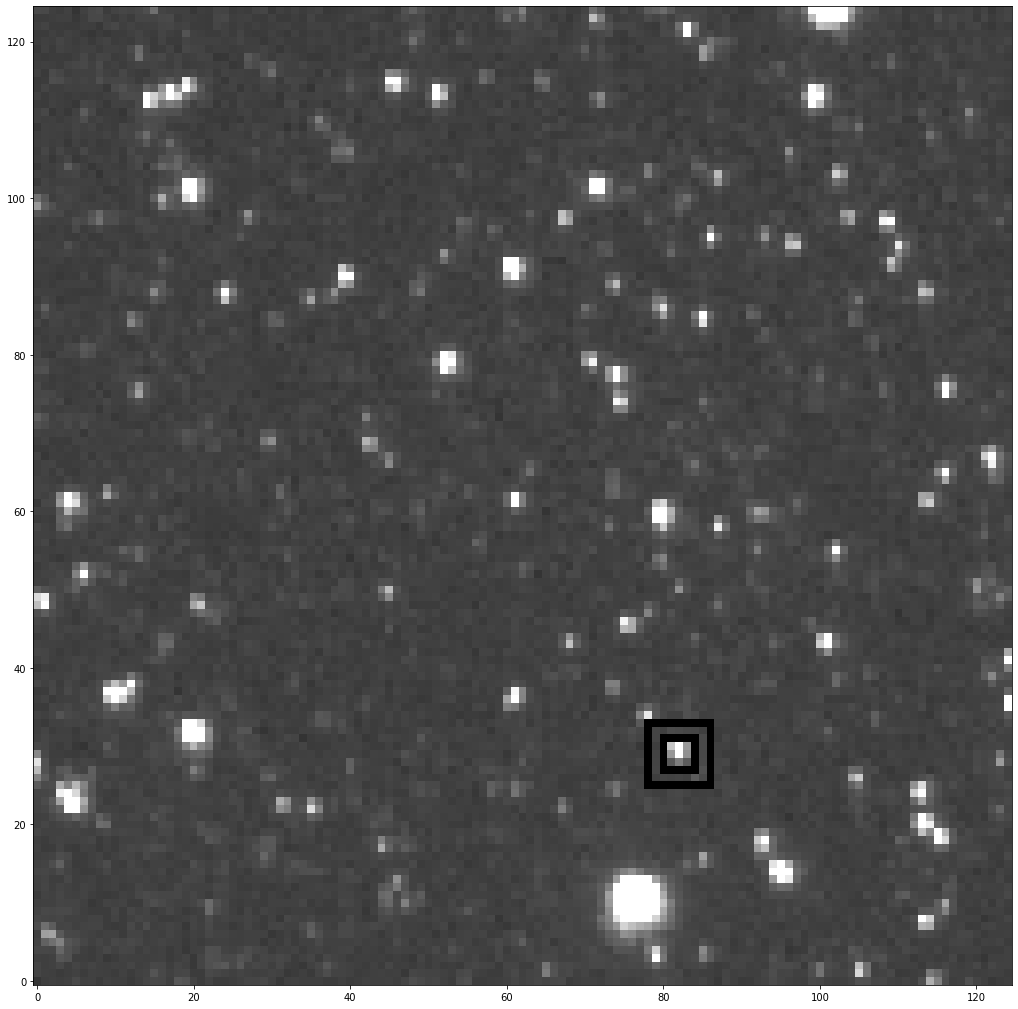

In [548]:
tot_starfnew_bin1, fsq6 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=80, pt1_2=31, pt2_1=84, pt2_2=27, dims=125, )

2021-12-01 04:10:07.597 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:10:07.598 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:10:07.638 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:10:07.639 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:10:07.663 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:10:07.664 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:10:07.687 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:10:07.689 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3463.866666666667, 3466.5333333333333, 3522.6666666666665, 3510.0, 3515.733333333333, 3467.4666666666667, 3572.4, 3784.133333333333, 3532.4, 3510.6666666666665, 3455.0, 3960.5333333333333, 5284.6, 3676.4, 3495.133333333333, 3482.0, 4127.2, 5032.533333333334, 3668.9333333333334, 3519.8, 3458.733333333333, 3582.3333333333335, 3626.0, 3508.6666666666665, 3506.266666666667]
Inner List Length: 25
Inner List Median: 3519.8
Inner List Mean: 3709.2
Outer List: [3442.133333333333, 3423.5333333333333, 3437.266666666667, 3455.6666666666665, 3445.0666666666666, 3456.733333333333, 3490.0666666666666, 3465.6, 3462.0666666666666, 3462.4, 3439.266666666667, 3454.266666666667, 3445.8, 3481.3333333333335, 3456.266666666667, 3562.733333333333, 3461.733333333333, 3433.3333333333335, 3451.266666666667, 3459.6666666666665, 3509.8, 3466.6666666666665, 3448.4666666666667, 3451.266666666667, 3478.0, 3452.0, 3456.8, 3459.3333333333335, 3482.733333333333, 3468.0666666666666, 3459.6666666666665, 3459

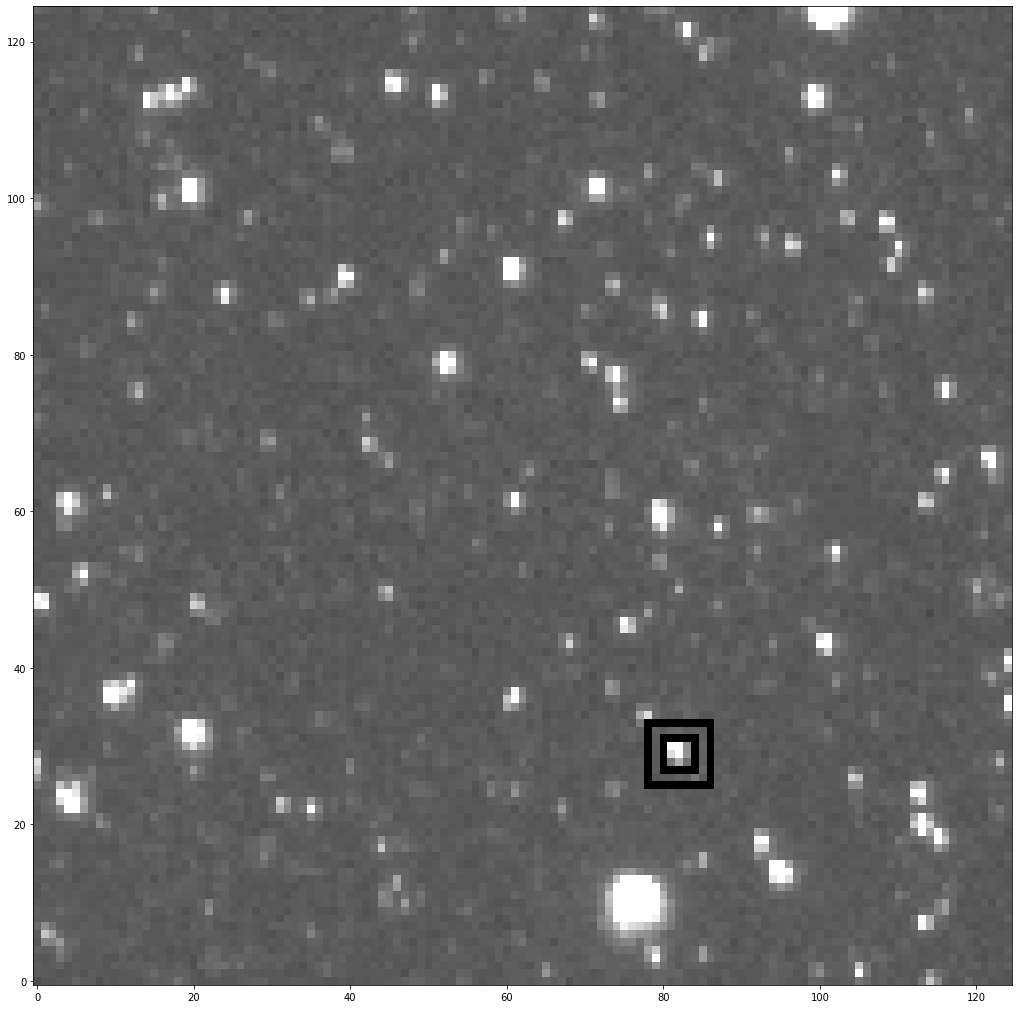

In [549]:
tot_starfnew_bin2, fsq6 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=80, pt1_2=31, pt2_1=84, pt2_2=27, dims=125, )

In [550]:
bin1_avg_f = np.mean(tot_starfnew_bin1)
bin2_avg_f = np.mean(tot_starfnew_bin2)
diff1_f = abs(bin1_avg_f - bin2_avg_f)
print(bin1_avg_f)
print(bin2_avg_f)
rel_change_f = diff1_f / np.mean([bin1_avg_f, bin2_avg_f])
rel_change_f

6397.78125
6182.500000000015


0.034225188725408695

In [552]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq6, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/im_stack_starF_NEW.png')

2021-12-01 04:12:15.668 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:12:15.669 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:12:15.752 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:12:15.754 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:12:15.778 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:12:15.780 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:12:15.806 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:12:15.807 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3353.0625, 3397.6875, 3405.6875, 3364.0, 3337.0, 3403.8125, 3659.125, 3474.0625, 3421.1875, 3337.4375, 3460.6875, 4354.875, 3855.875, 3396.9375, 3352.25, 3423.125, 4192.3125, 3700.0625, 3437.8125, 3353.6875, 3393.875, 3449.625, 3401.8125, 3396.5625, 3368.0625]
Inner List Length: 25
Inner List Median: 3403.8125
Inner List Mean: 3507.625
Outer List: [3348.9375, 3339.5625, 3355.375, 3346.5, 3369.0, 3335.875, 3338.4375, 3333.75, 3354.25, 3340.625, 3329.375, 3338.5, 3372.4375, 3361.4375, 3358.3125, 3351.1875, 3359.625, 3353.875, 3358.375, 3372.3125, 3350.8125, 3345.5, 3360.5625, 3341.5625, 3351.0, 3339.75, 3370.8125, 3355.0625, 3340.125, 3360.1875, 3419.375, 3376.375, 3323.0625, 3357.0625, 3410.875, 3367.125, 3344.125, 3379.125, 3388.1875, 3368.5625, 3370.125, 3357.5, 3366.5625, 3355.4375, 3358.8125, 3359.375, 3363.25, 3346.0625, 3362.9375, 3353.375, 3361.9375, 3358.9375, 3343.3125, 3351.4375, 3363.5, 3341.875]
Outer List Length: 56
Outer List Median: 3356.25
Outer List Mean: 3

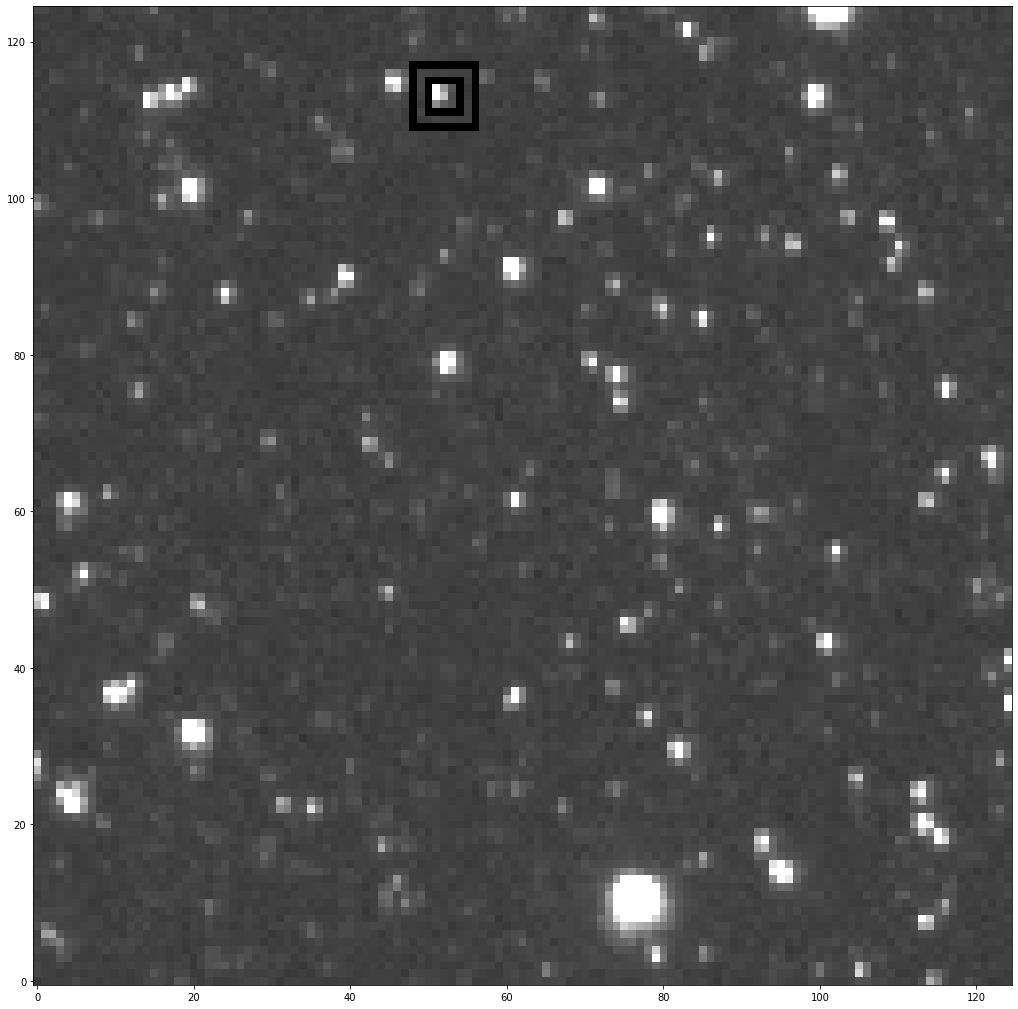

In [553]:
tot_stargnew_bin1, fsq7 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=50, pt1_2=115, pt2_1=54, pt2_2=111, dims=125, )

2021-12-01 04:12:16.469 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:12:16.471 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:12:16.513 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:12:16.514 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:12:16.539 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:12:16.540 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:12:16.562 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:12:16.564 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3457.0666666666666, 3498.5333333333333, 3498.2, 3486.6, 3437.866666666667, 3501.6, 3778.4666666666667, 3578.2, 3508.0666666666666, 3441.5333333333333, 3564.733333333333, 4488.933333333333, 3860.0, 3490.8, 3441.8, 3523.3333333333335, 4173.4, 3693.733333333333, 3513.3333333333335, 3456.6, 3503.133333333333, 3535.2, 3489.6666666666665, 3484.133333333333, 3462.866666666667]
Inner List Length: 25
Inner List Median: 3501.6
Inner List Mean: 3594.712
Outer List: [3435.4, 3440.866666666667, 3440.4666666666667, 3430.4, 3473.866666666667, 3434.0, 3448.6666666666665, 3430.133333333333, 3470.2, 3436.3333333333335, 3433.9333333333334, 3440.266666666667, 3483.733333333333, 3457.866666666667, 3442.4666666666667, 3444.0666666666666, 3473.2, 3457.733333333333, 3466.0666666666666, 3472.0666666666666, 3442.4666666666667, 3436.4666666666667, 3448.733333333333, 3435.0, 3440.866666666667, 3434.2, 3487.8, 3444.4, 3453.4666666666667, 3443.133333333333, 3501.266666666667, 3474.6, 3432.9333333333334

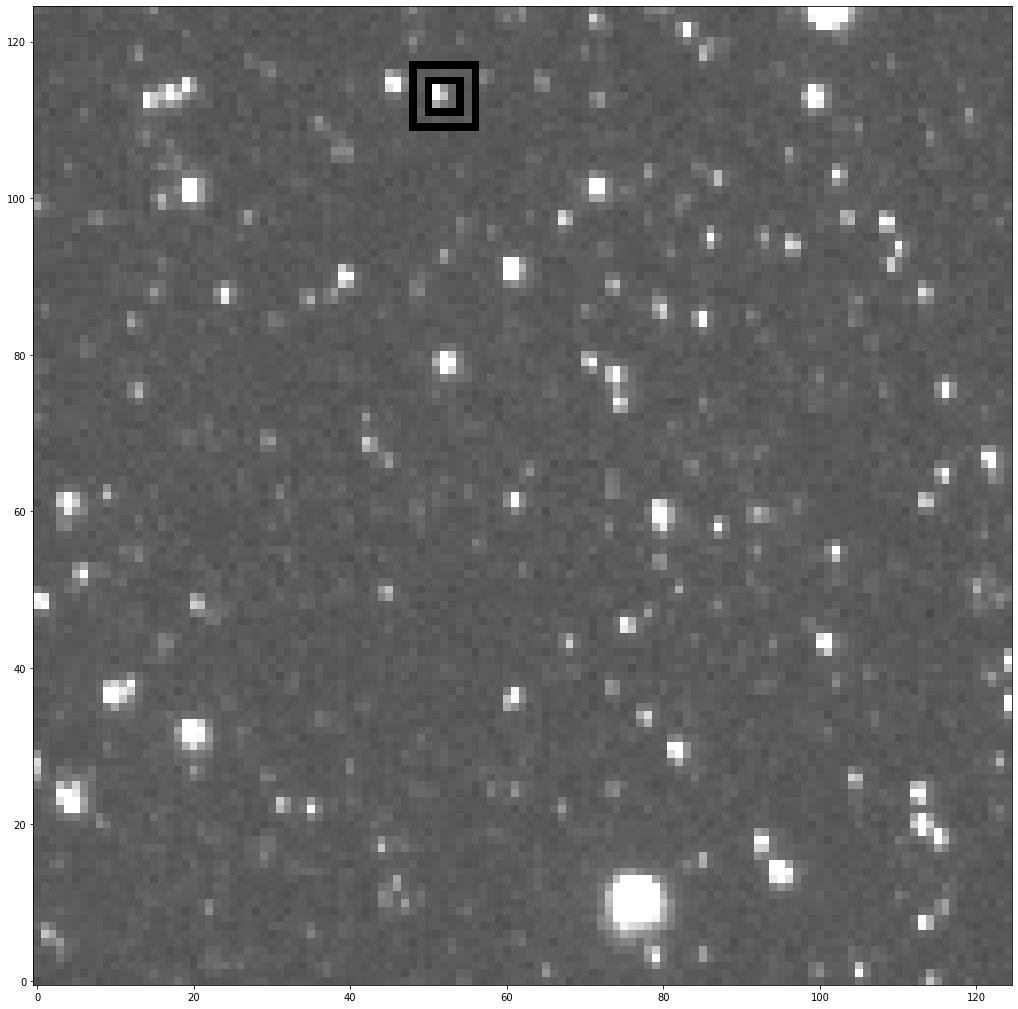

In [554]:
tot_stargnew_bin2, fsq7 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=50, pt1_2=115, pt2_1=54, pt2_2=111, dims=125, )

In [555]:
bin1_avg_g = np.median(tot_stargnew_bin1)
bin2_avg_g = np.median(tot_stargnew_bin2)
diff1_g = abs(bin1_avg_g - bin2_avg_g)
print(bin1_avg_g)
print(bin2_avg_g)
# print(diff1_g)
rel_change_g = diff1_g / np.median([bin1_avg_g, bin2_avg_g])
rel_change_g

3784.375
3592.800000000003


0.05193722529287892

In [132]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq7, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/im_stack_starG_NEW.png')

2021-12-01 04:13:38.082 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:13:38.083 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:13:38.127 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:13:38.128 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:13:38.152 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:13:38.153 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:13:38.178 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:13:38.179 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3363.8125, 3401.0625, 3440.75, 3400.9375, 3372.25, 3380.375, 3481.875, 3568.625, 3398.875, 3357.625, 3373.625, 3749.0, 3895.5, 3398.25, 3348.3125, 3378.3125, 3517.75, 3505.25, 3387.4375, 3393.0625, 3325.25, 3349.75, 3372.1875, 3383.625, 3340.3125]
Inner List Length: 25
Inner List Median: 3387.4375
Inner List Mean: 3435.3525
Outer List: [3356.375, 3338.9375, 3367.1875, 3378.3125, 3423.6875, 3382.1875, 3338.0, 3340.75, 3361.9375, 3347.5, 3336.25, 3341.4375, 3405.0, 3403.5, 3366.5, 3362.3125, 3372.875, 3388.3125, 3360.5625, 3341.0625, 3388.5625, 3400.3125, 3358.25, 3343.9375, 3358.8125, 3371.8125, 3357.8125, 3352.125, 3354.5, 3332.6875, 3348.8125, 3351.9375, 3334.875, 3324.75, 3364.0, 3329.4375, 3348.0, 3358.1875, 3344.375, 3366.25, 3333.5625, 3366.8125, 3348.0, 3329.375, 3348.1875, 3330.1875, 3365.9375, 3372.1875, 3347.25, 3353.3125, 3358.9375, 3340.8125, 3347.125, 3364.75, 3348.4375, 3352.0]
Outer List Length: 56
Outer List Median: 3353.90625
Outer List Mean: 3357.303571428

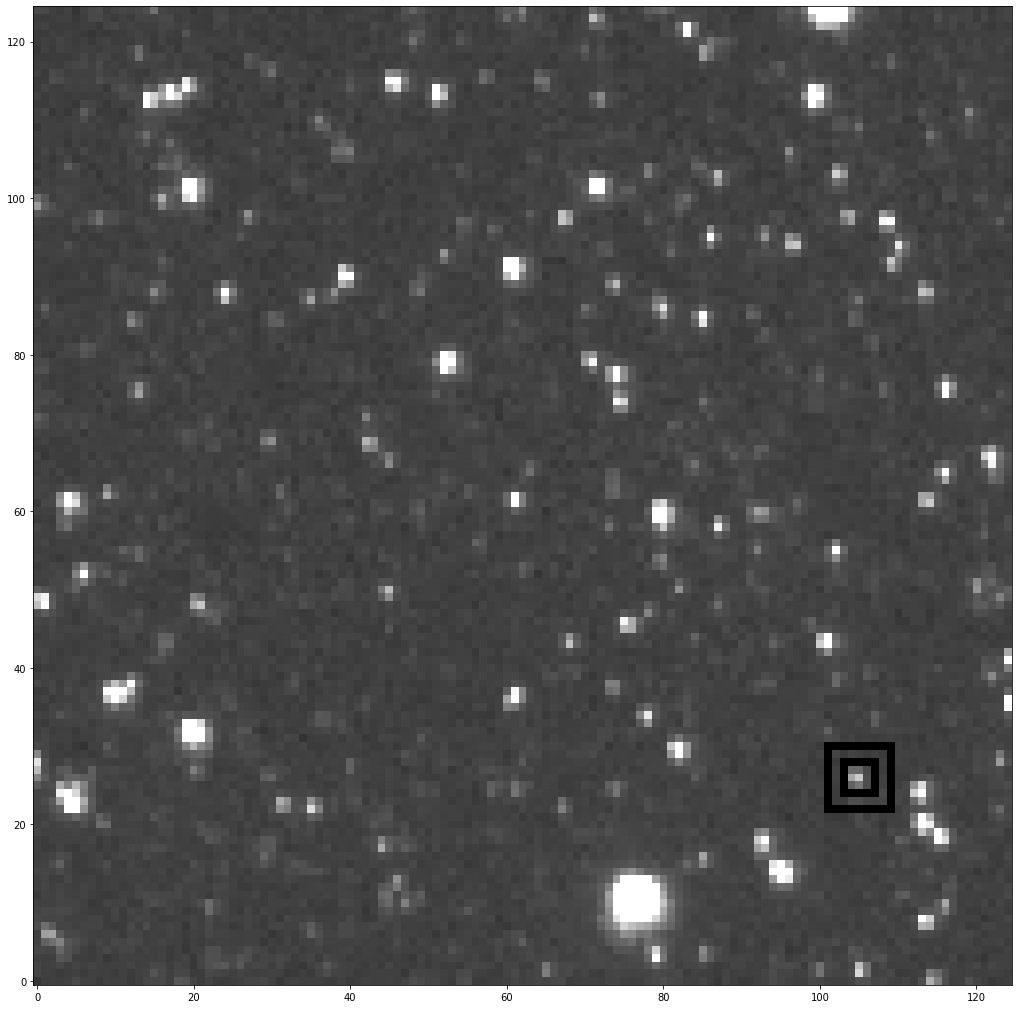

In [556]:
tot_starhnew_bin1, fsq8 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=103, pt1_2=28, pt2_1=107, pt2_2=24, dims=125, )

2021-12-01 04:13:41.813 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:13:41.815 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:13:41.857 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:13:41.859 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:13:41.881 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:13:41.882 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:13:41.906 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:13:41.907 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3447.6666666666665, 3503.866666666667, 3514.733333333333, 3488.133333333333, 3464.6, 3475.3333333333335, 3663.4666666666667, 3670.733333333333, 3482.8, 3465.0, 3472.6666666666665, 3925.4666666666667, 3836.4666666666667, 3461.2, 3464.5333333333333, 3478.6666666666665, 3623.0666666666666, 3531.0, 3477.0, 3491.3333333333335, 3430.133333333333, 3448.0, 3456.133333333333, 3477.4, 3443.266666666667]
Inner List Length: 25
Inner List Median: 3477.4
Inner List Mean: 3527.706666666667
Outer List: [3439.8, 3456.4, 3446.6, 3457.8, 3515.133333333333, 3466.8, 3434.0, 3433.4, 3465.733333333333, 3437.133333333333, 3442.2, 3437.0666666666666, 3508.266666666667, 3508.9333333333334, 3453.5333333333333, 3464.733333333333, 3485.0666666666666, 3495.733333333333, 3458.733333333333, 3439.866666666667, 3503.2, 3469.5333333333333, 3441.5333333333333, 3450.5333333333333, 3440.2, 3464.4, 3445.2, 3449.866666666667, 3448.5333333333333, 3435.866666666667, 3452.733333333333, 3451.9333333333334, 3437.1333

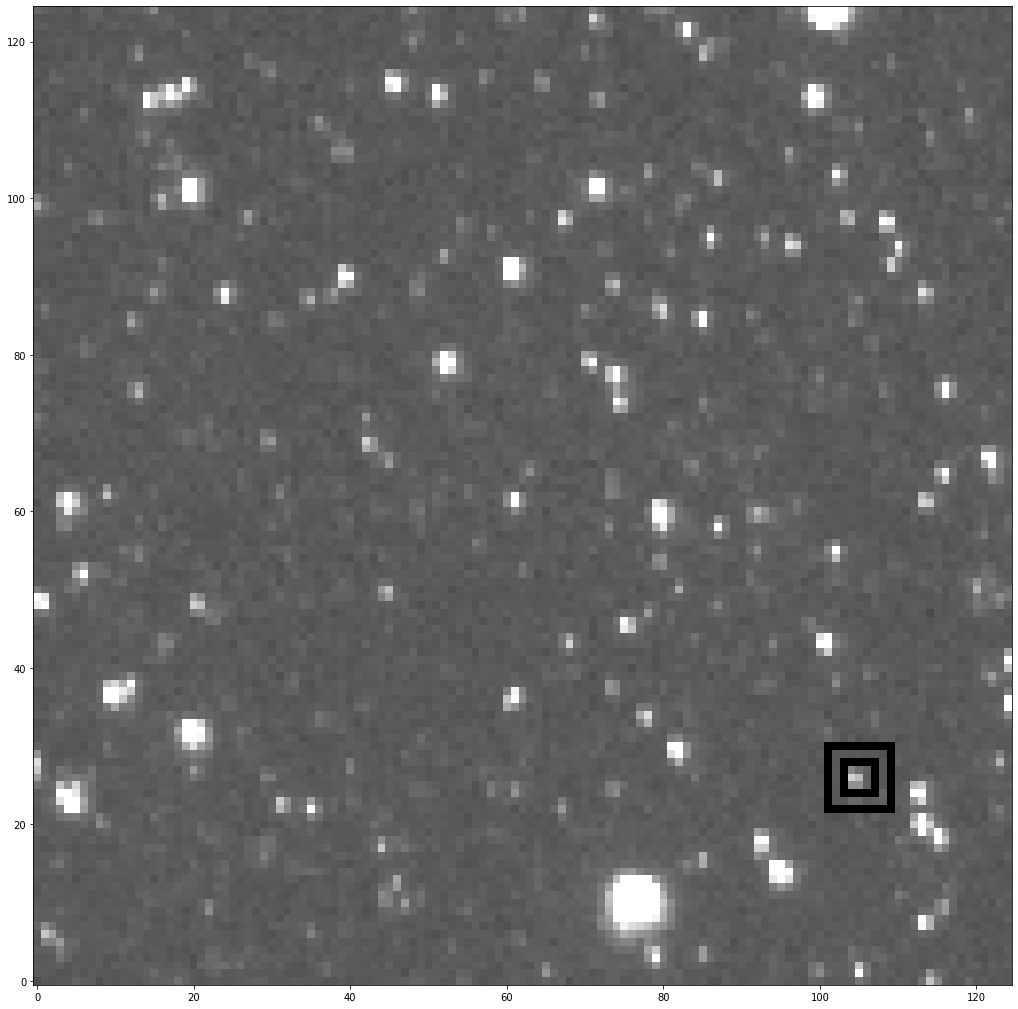

In [557]:
tot_starhnew_bin2, fsq8 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=103, pt1_2=28, pt2_1=107, pt2_2=24, dims=125, )

In [558]:
bin1_avg_h = np.mean(tot_starhnew_bin1)
bin2_avg_h = np.mean(tot_starhnew_bin2)
diff1_h = abs(bin1_avg_h - bin2_avg_h)
rel_change_h = diff1_h / np.mean([bin1_avg_h, bin2_avg_h])
print(bin1_avg_h)
print(bin2_avg_h)
print(rel_change_h)

2036.15625
1911.8333333332994
0.06298036711724776


In [560]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq8, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/im_stack_starH_NEW.png')

2021-12-01 04:15:19.062 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:15:19.063 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:15:19.106 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:15:19.107 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:15:19.130 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:15:19.131 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:15:19.153 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:15:19.154 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3371.3125, 3350.6875, 3391.3125, 3355.4375, 3378.0625, 3371.5, 3461.125, 3640.4375, 3395.875, 3383.1875, 3392.6875, 3570.25, 3841.125, 3431.1875, 3369.5, 3372.5, 3413.3125, 3423.4375, 3377.375, 3356.8125, 3364.0625, 3342.4375, 3359.0, 3375.875, 3363.125]
Inner List Length: 25
Inner List Median: 3377.375
Inner List Mean: 3418.065
Outer List: [3353.5, 3348.6875, 3361.375, 3332.8125, 3383.8125, 3369.6875, 3351.1875, 3346.8125, 3373.3125, 3364.625, 3341.75, 3375.75, 3357.5, 3368.125, 3354.4375, 3381.0625, 3393.0625, 3364.4375, 3359.625, 3346.875, 3333.6875, 3338.0, 3356.3125, 3374.0625, 3352.1875, 3357.6875, 3359.0, 3338.3125, 3341.0, 3347.125, 3352.75, 3352.625, 3362.375, 3362.4375, 3319.0625, 3352.375, 3354.6875, 3354.125, 3331.1875, 3357.8125, 3336.0, 3341.5, 3359.9375, 3406.5, 3352.9375, 3372.0625, 3353.0625, 3357.125, 3362.875, 3327.125, 3405.3125, 3386.625, 3370.375, 3350.0, 3390.0625, 3333.3125]
Outer List Length: 56
Outer List Median: 3355.5
Outer List Mean: 3357.67968

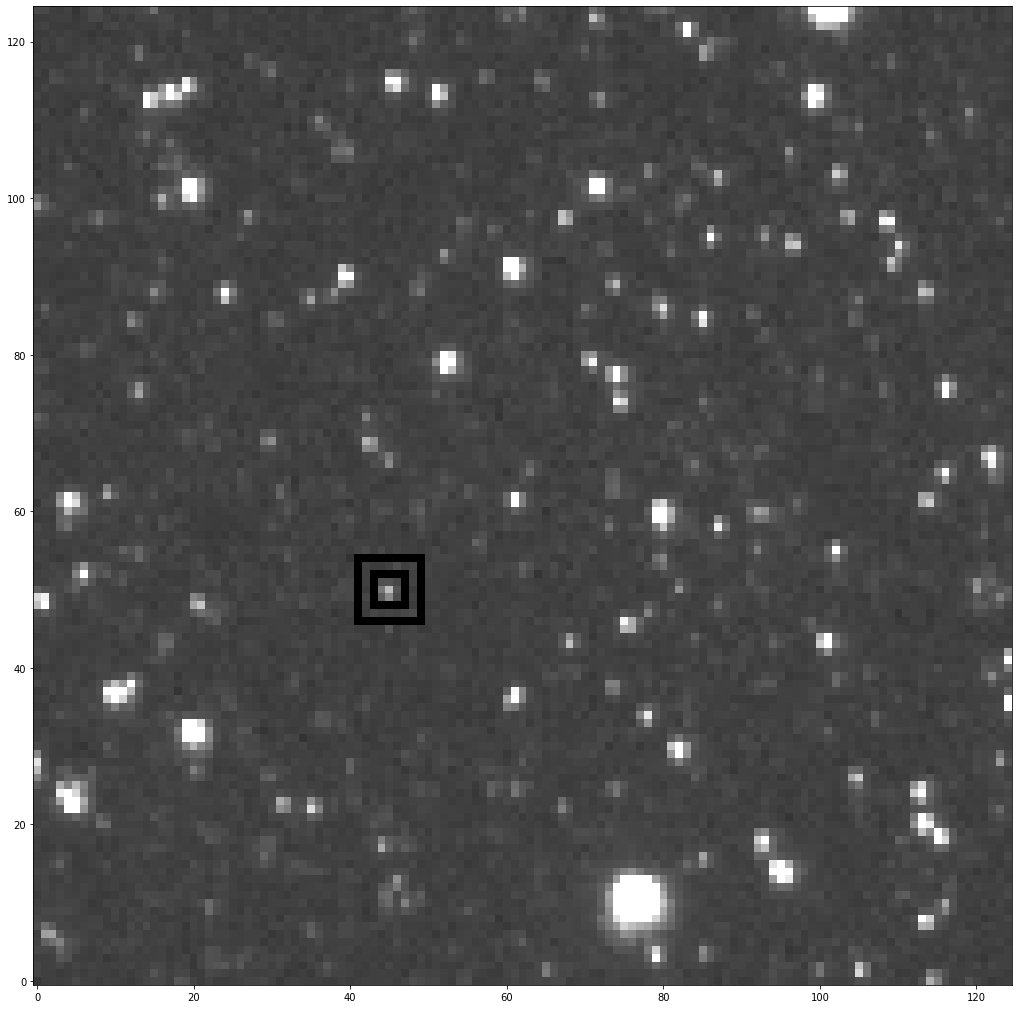

In [561]:
tot_starinew_bin1, fsq9 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=43, pt1_2=52, pt2_1=47, pt2_2=48, dims=125, )

2021-12-01 04:15:23.948 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:15:23.949 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:15:23.989 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:15:23.990 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:15:24.014 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:15:24.015 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:15:24.038 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:15:24.039 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3464.5333333333333, 3462.2, 3485.8, 3464.3333333333335, 3486.733333333333, 3481.3333333333335, 3607.2, 3723.733333333333, 3500.3333333333335, 3492.733333333333, 3491.8, 3698.733333333333, 3847.0, 3497.9333333333334, 3447.4, 3473.733333333333, 3524.5333333333333, 3518.266666666667, 3460.4, 3460.866666666667, 3464.733333333333, 3442.733333333333, 3454.4666666666667, 3461.0666666666666, 3461.8]
Inner List Length: 25
Inner List Median: 3481.3333333333335
Inner List Mean: 3514.9760000000006
Outer List: [3452.8, 3442.0666666666666, 3458.5333333333333, 3441.0666666666666, 3475.733333333333, 3467.0666666666666, 3448.4666666666667, 3447.4, 3477.0666666666666, 3463.3333333333335, 3448.266666666667, 3481.4, 3444.5333333333333, 3465.733333333333, 3432.266666666667, 3475.733333333333, 3486.733333333333, 3453.6, 3440.6666666666665, 3460.6, 3438.0, 3410.733333333333, 3451.6666666666665, 3460.3333333333335, 3449.4, 3455.733333333333, 3458.0, 3429.133333333333, 3447.6, 3423.866666666667, 3

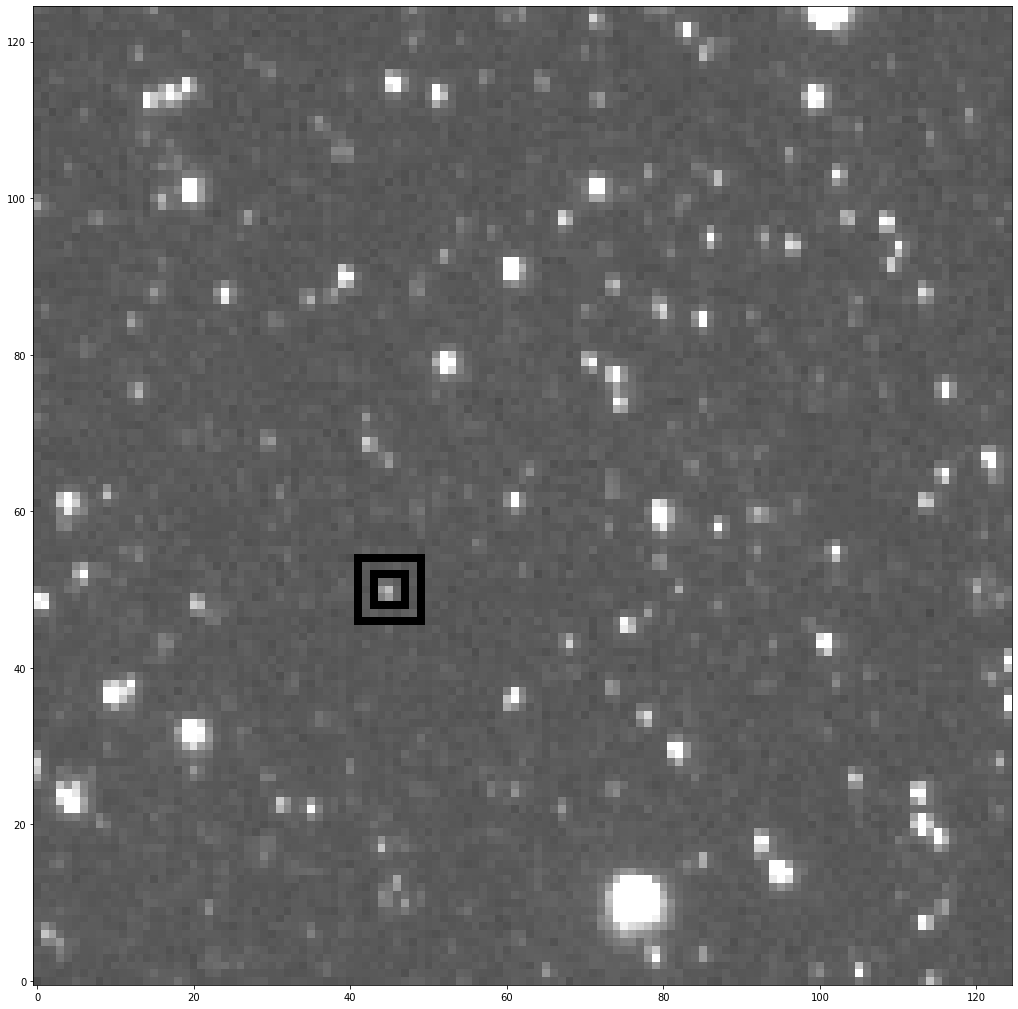

In [562]:
tot_starinew_bin2, fsq9 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=43, pt1_2=52, pt2_1=47, pt2_2=48, dims=125, )

In [563]:
bin1_avg_i = np.mean(tot_starinew_bin1)
bin2_avg_i = np.mean(tot_starinew_bin2)
diff1_i = abs(bin1_avg_i - bin2_avg_i)
rel_change_i = diff1_i / np.mean([bin1_avg_i, bin2_avg_i])
print(bin1_avg_i)
print(bin2_avg_i)
print(rel_change_i)

1564.125
1518.5666666666511
0.029557502507288762


In [98]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq9, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/im_stack_starI_NEW.png')

2021-12-01 04:27:58.152 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:27:58.153 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:27:58.194 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:27:58.195 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:27:58.219 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:27:58.220 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:27:58.245 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:27:58.246 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3372.5625, 3360.375, 3357.8125, 3359.4375, 3335.5625, 3351.5625, 3389.625, 3427.9375, 3374.875, 3378.0, 3363.0, 3448.3125, 3856.5625, 3483.0, 3387.1875, 3356.625, 3435.625, 3679.8125, 3454.0625, 3369.625, 3371.5, 3380.75, 3366.5, 3362.0625, 3372.4375]
Inner List Length: 25
Inner List Median: 3372.5625
Inner List Mean: 3415.7925
Outer List: [3346.125, 3402.625, 3418.0, 3386.0625, 3384.75, 3430.8125, 3349.75, 3321.8125, 3355.3125, 3364.75, 3390.5, 3351.4375, 3394.0625, 3423.625, 3411.6875, 3380.1875, 3350.0, 3354.875, 3366.5625, 3344.0, 3354.5, 3357.625, 3340.8125, 3347.4375, 3337.75, 3372.75, 3367.0, 3361.6875, 3360.6875, 3350.1875, 3361.4375, 3366.4375, 3318.25, 3355.6875, 3348.3125, 3346.0625, 3333.375, 3375.9375, 3383.0, 3362.0, 3375.625, 3380.8125, 3397.75, 3350.8125, 3380.1875, 3339.0, 3345.5, 3338.5, 3339.5, 3367.125, 3348.0, 3334.0625, 3346.9375, 3349.25, 3349.125, 3361.625]
Outer List Length: 56
Outer List Median: 3356.65625
Outer List Mean: 3363.065848214286


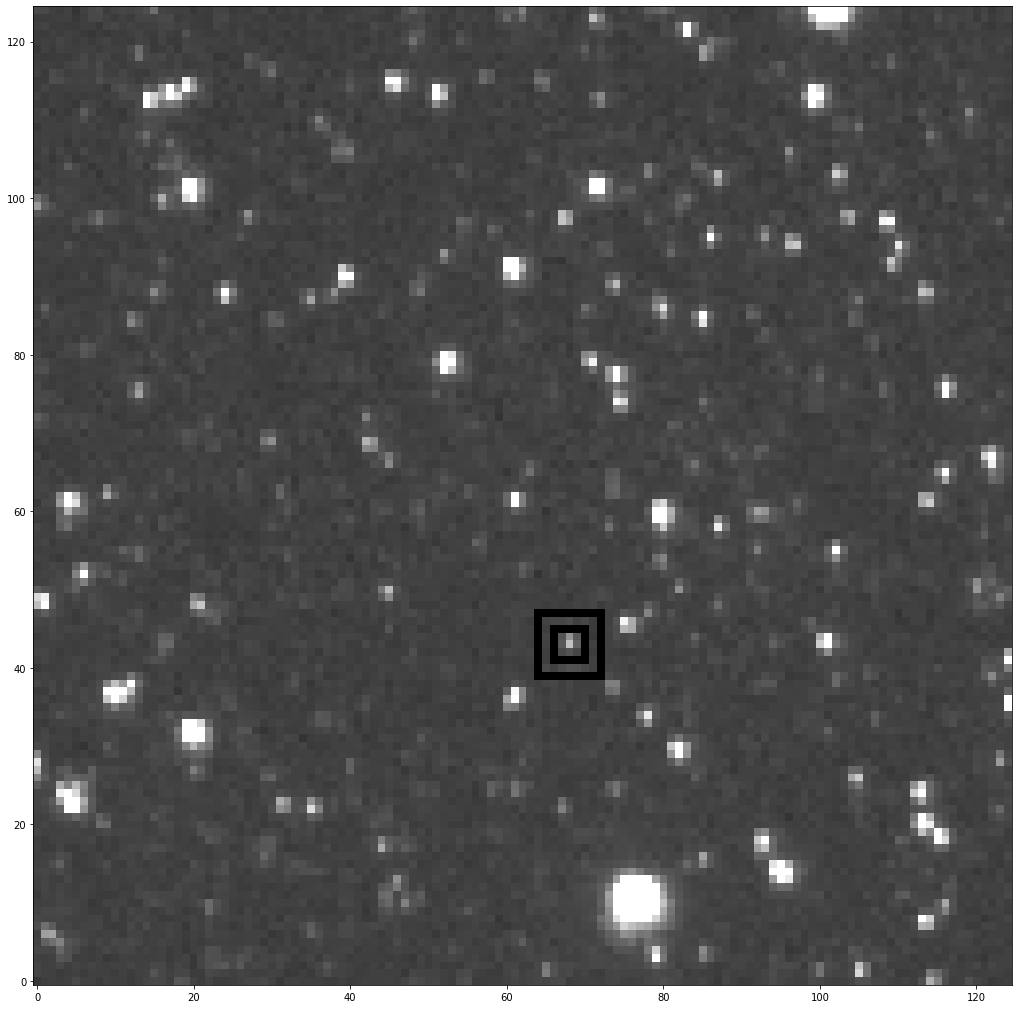

In [564]:
tot_starjnew_bin1, fsq10 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=66, pt1_2=45, pt2_1=70, pt2_2=41, dims=125, )

2021-12-01 04:28:50.138 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:28:50.139 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:28:50.180 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:28:50.181 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:28:50.203 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:28:50.205 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:28:50.227 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:28:50.228 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3473.6, 3468.133333333333, 3451.9333333333334, 3468.4, 3438.6, 3450.4, 3493.866666666667, 3561.133333333333, 3475.8, 3468.133333333333, 3464.6, 3564.133333333333, 3931.266666666667, 3540.866666666667, 3474.4666666666667, 3447.8, 3561.9333333333334, 3716.3333333333335, 3517.4666666666667, 3462.6666666666665, 3468.8, 3479.6666666666665, 3464.266666666667, 3457.8, 3474.2]
Inner List Length: 25
Inner List Median: 3473.6
Inner List Mean: 3511.0506666666665
Outer List: [3447.6666666666665, 3496.266666666667, 3496.5333333333333, 3479.133333333333, 3492.8, 3520.6, 3446.133333333333, 3409.733333333333, 3461.0666666666666, 3466.3333333333335, 3492.733333333333, 3448.4, 3484.9333333333334, 3522.9333333333334, 3505.733333333333, 3476.733333333333, 3447.5333333333333, 3443.6666666666665, 3465.0, 3460.133333333333, 3471.866666666667, 3457.6, 3440.6666666666665, 3423.3333333333335, 3434.5333333333333, 3462.733333333333, 3457.866666666667, 3461.0666666666666, 3460.4666666666667, 3438.4, 3

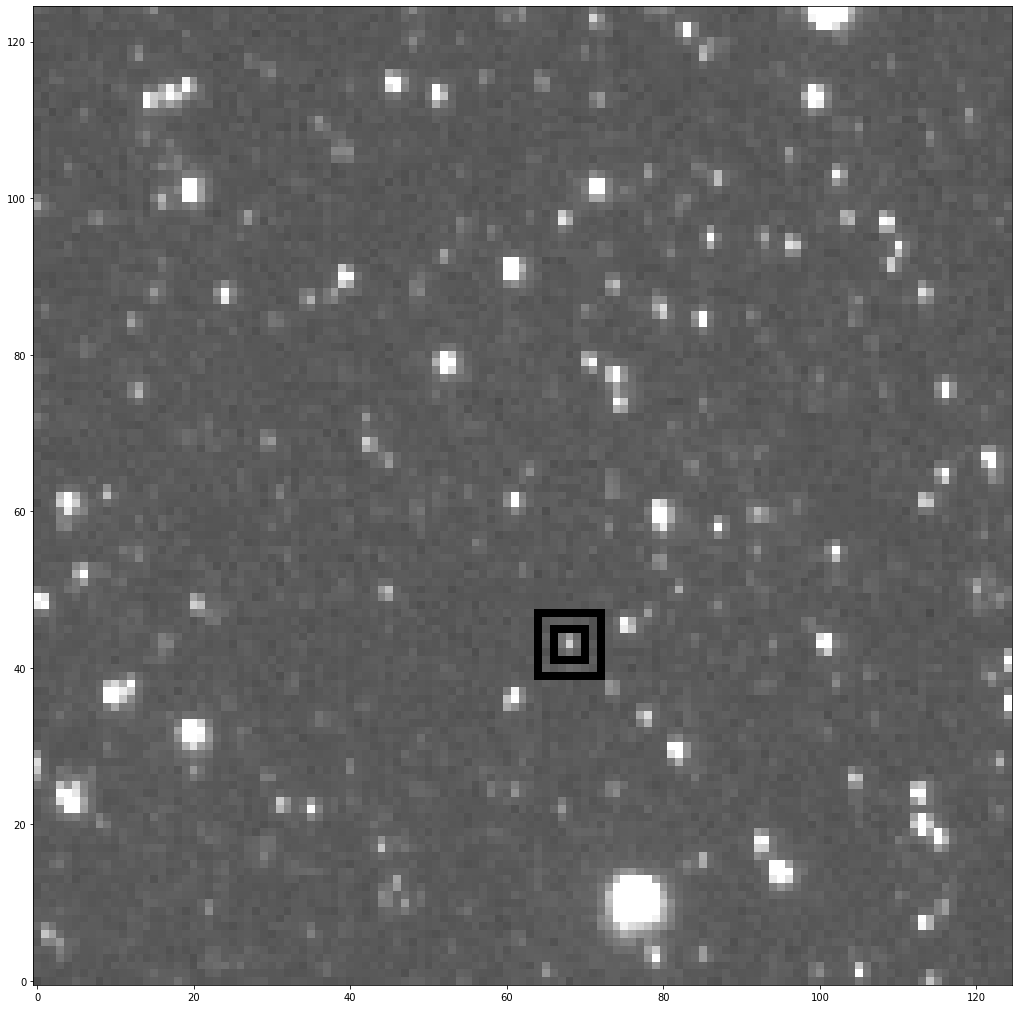

In [565]:
tot_starjnew_bin2, fsq10 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=66, pt1_2=45, pt2_1=70, pt2_2=41, dims=125, )

In [566]:
bin1_avg_j = np.mean(tot_starjnew_bin1)
bin2_avg_j = np.mean(tot_starjnew_bin2)
diff1_j = abs(bin1_avg_j - bin2_avg_j)
rel_change_j = diff1_j / np.mean([bin1_avg_j, bin2_avg_j])
print(bin1_avg_j)
print(bin2_avg_j)
print(rel_change_j)

1478.40625
1301.2666666666773
0.12745354481903903


In [568]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq10, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/im_stack_starJ_NEW.png')

2021-12-01 04:32:02.656 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:32:02.657 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:32:02.696 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:32:02.697 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:32:02.718 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:32:02.719 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:32:02.743 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:32:02.744 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3339.5625, 3368.125, 3417.0625, 3396.0, 3367.5, 3363.0, 3380.25, 3445.3125, 3382.125, 3373.5625, 3388.5, 3463.6875, 3645.9375, 3430.125, 3362.8125, 3380.8125, 3497.0625, 4127.1875, 3508.0, 3368.0, 3345.4375, 3396.6875, 3586.6875, 3394.1875, 3386.0625]
Inner List Length: 25
Inner List Median: 3388.5
Inner List Mean: 3444.5475
Outer List: [3357.125, 3358.5625, 3325.125, 3392.9375, 3350.0625, 3360.0, 3375.3125, 3360.375, 3387.375, 3332.1875, 3353.375, 3366.6875, 3388.1875, 3400.75, 3405.3125, 3360.5, 3353.6875, 3390.5, 3375.25, 3337.625, 3353.9375, 3377.4375, 3369.125, 3371.375, 3375.625, 3360.75, 3363.375, 3403.8125, 3364.6875, 3343.5625, 3384.5, 3381.25, 3383.6875, 3360.0, 3349.25, 3373.0625, 3384.1875, 3380.3125, 3354.8125, 3372.0625, 3347.0625, 3323.375, 3343.25, 3355.8125, 3390.3125, 3365.125, 3351.5, 3369.5625, 3351.4375, 3366.9375, 3362.125, 3368.75, 3346.375, 3341.0625, 3352.8125, 3347.1875]
Outer List Length: 56
Outer List Median: 3362.75
Outer List Mean: 3364.650669

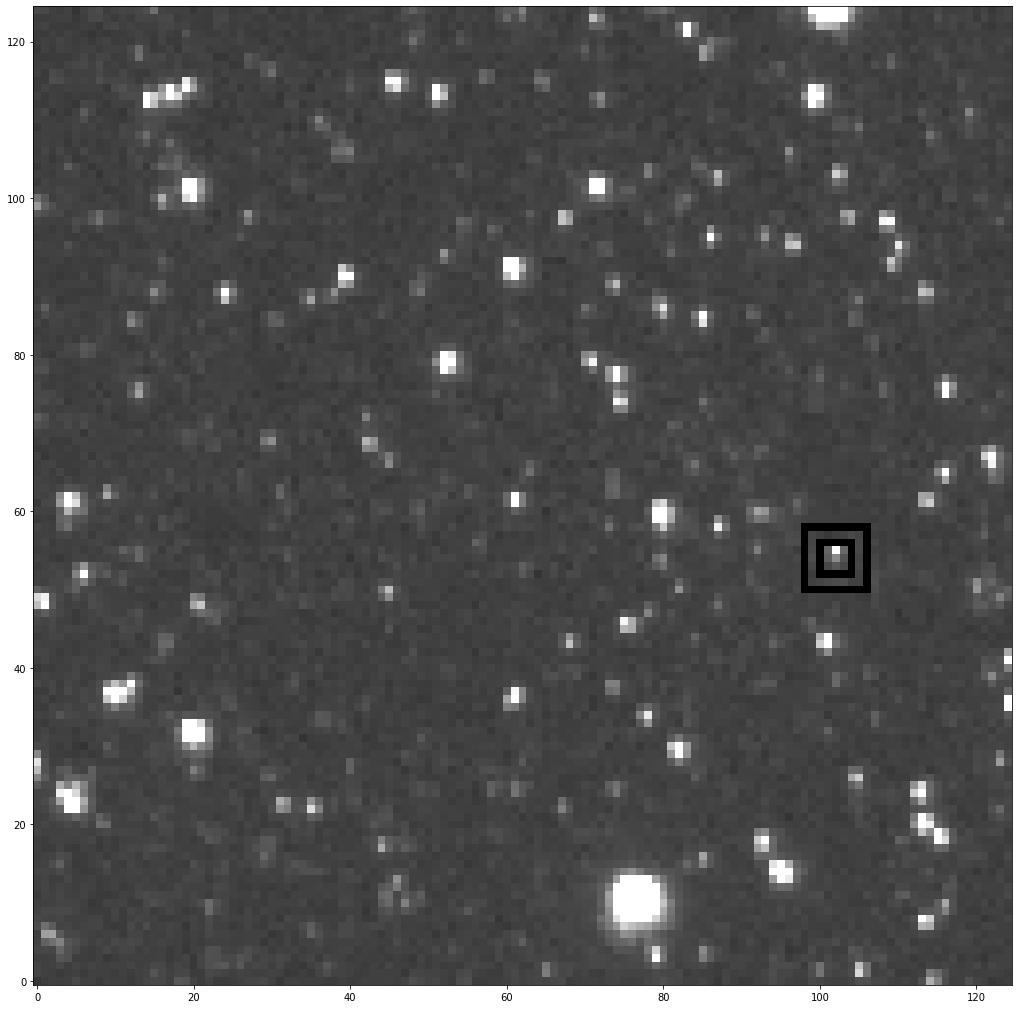

In [573]:
tot_starknew_bin1, fsq11 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=100, pt1_2=56, pt2_1=104, pt2_2=52, dims=125, )

2021-12-01 04:32:03.383 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:32:03.385 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:32:03.425 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:32:03.427 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:32:03.451 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:32:03.452 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:32:03.475 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:32:03.476 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3431.733333333333, 3481.266666666667, 3514.0666666666666, 3486.9333333333334, 3460.3333333333335, 3442.0, 3484.4666666666667, 3527.8, 3474.9333333333334, 3473.0666666666666, 3512.866666666667, 3549.2, 3839.866666666667, 3510.6666666666665, 3470.0666666666666, 3485.266666666667, 3623.266666666667, 4126.6, 3561.8, 3469.4666666666667, 3439.8, 3513.2, 3613.866666666667, 3466.4, 3478.5333333333333]
Inner List Length: 25
Inner List Median: 3485.266666666667
Inner List Mean: 3537.4986666666678
Outer List: [3457.4666666666667, 3458.4666666666667, 3447.3333333333335, 3493.4666666666667, 3440.6, 3461.3333333333335, 3481.4666666666667, 3462.133333333333, 3502.4666666666667, 3415.866666666667, 3448.6666666666665, 3471.3333333333335, 3487.866666666667, 3531.2, 3506.0666666666666, 3450.4666666666667, 3443.3333333333335, 3505.4, 3472.266666666667, 3434.266666666667, 3453.3333333333335, 3468.6666666666665, 3476.4666666666667, 3476.6666666666665, 3453.4, 3456.6666666666665, 3475.8666666666

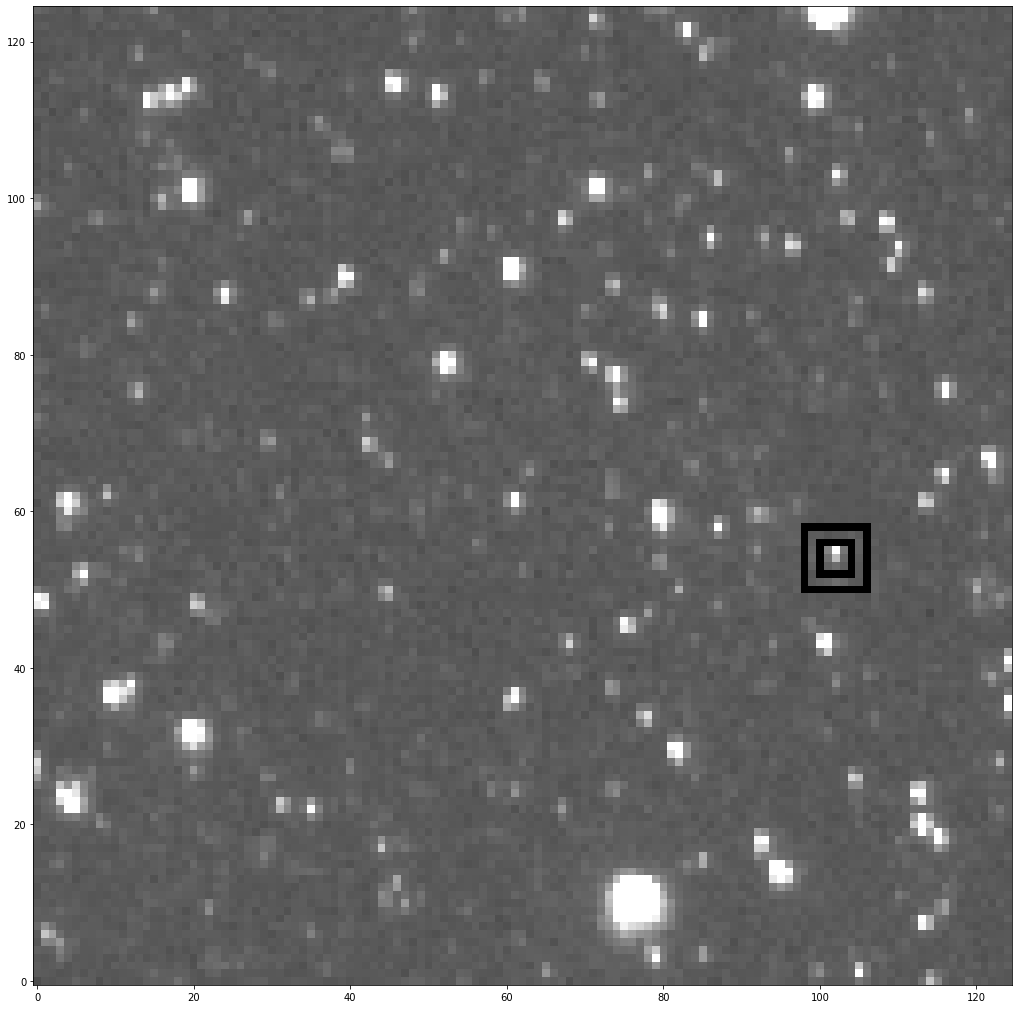

In [574]:
tot_starknew_bin2, fsq11 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=100, pt1_2=56, pt2_1=104, pt2_2=52, dims=125, )

In [575]:
bin1_avg_k = np.mean(tot_starknew_bin1)
bin2_avg_k = np.mean(tot_starknew_bin2)
diff1_k = abs(bin1_avg_k - bin2_avg_k)
rel_change_k = diff1_k / np.mean([bin1_avg_k, bin2_avg_k])
print(bin1_avg_k)
print(bin2_avg_k)
print(rel_change_k)

2044.9375
1954.9666666666599
0.0449864944681001


In [577]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq11, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/im_stack_starK_NEW.png')

2021-12-01 04:32:18.940 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:32:18.941 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:32:18.978 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:32:18.979 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:32:19.002 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:32:19.003 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:32:19.028 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:32:19.029 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3379.625, 3376.375, 3347.875, 3382.5625, 3426.3125, 3347.625, 3374.75, 3447.875, 3526.5625, 3490.75, 3353.9375, 3386.5, 3747.625, 3875.6875, 3432.125, 3345.0, 3353.75, 3621.4375, 3567.0625, 3387.8125, 3370.5625, 3348.875, 3370.25, 3368.1875, 3349.1875]
Inner List Length: 25
Inner List Median: 3379.625
Inner List Mean: 3439.1325
Outer List: [3482.0, 3471.5, 3385.6875, 3338.9375, 3350.6875, 3347.375, 3346.875, 3351.8125, 3378.5, 3394.4375, 3375.5, 3371.875, 3364.5, 3350.5, 3382.9375, 3354.625, 3373.8125, 3367.3125, 3356.25, 3362.6875, 3464.5625, 3353.9375, 3352.875, 3351.125, 3457.5, 3412.1875, 3362.3125, 3347.9375, 3415.9375, 3422.25, 3346.0625, 3346.6875, 3398.375, 3366.5, 3348.5, 3364.9375, 3365.25, 3347.5, 3359.1875, 3344.0, 3336.1875, 3334.5625, 3366.9375, 3378.5625, 3375.5625, 3398.1875, 3335.6875, 3328.5, 3337.5, 3339.8125, 3328.875, 3366.1875, 3356.25, 3400.75, 3397.25, 3352.875]
Outer List Length: 56
Outer List Median: 3362.5
Outer List Mean: 3370.8772321428573


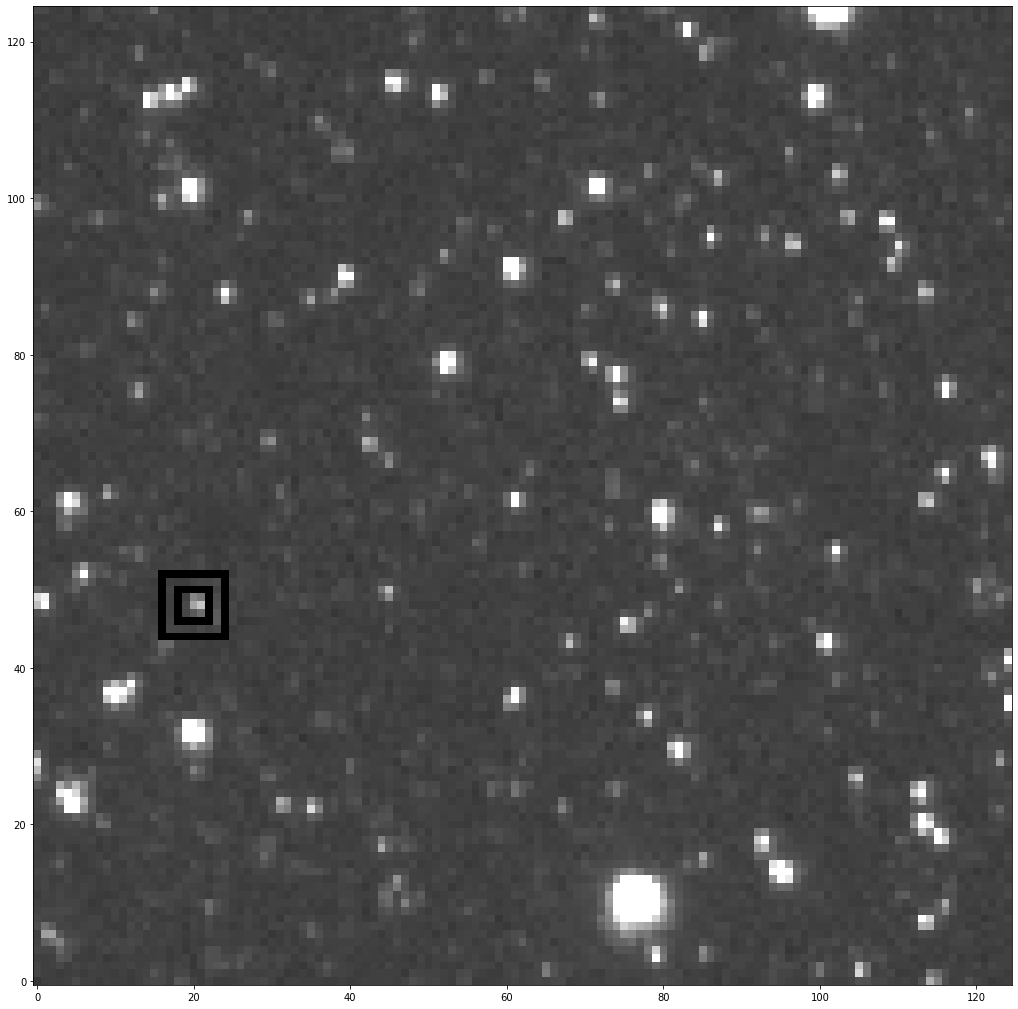

In [578]:
tot_starlnew_bin1, fsq12 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=18, pt1_2=50, pt2_1=22, pt2_2=46, dims=125, )

2021-12-01 04:32:30.822 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:32:30.823 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:32:30.865 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:32:30.867 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:32:30.890 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:32:30.891 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:32:30.915 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:32:30.916 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3469.133333333333, 3468.0, 3428.0666666666666, 3467.0, 3544.4666666666667, 3440.6666666666665, 3472.6666666666665, 3590.3333333333335, 3626.4, 3583.8, 3461.266666666667, 3486.4666666666667, 3916.133333333333, 3844.2, 3514.6666666666665, 3440.9333333333334, 3466.266666666667, 3746.133333333333, 3628.3333333333335, 3486.866666666667, 3477.3333333333335, 3448.266666666667, 3481.2, 3449.6666666666665, 3478.2]
Inner List Length: 25
Inner List Median: 3478.2
Inner List Mean: 3536.6586666666662
Outer List: [3595.4666666666667, 3537.5333333333333, 3503.3333333333335, 3445.133333333333, 3448.0, 3463.6666666666665, 3447.3333333333335, 3447.9333333333334, 3464.4666666666667, 3477.0666666666666, 3475.266666666667, 3454.8, 3467.6666666666665, 3449.2, 3480.8, 3451.6, 3472.0666666666666, 3455.866666666667, 3449.733333333333, 3451.2, 3559.9333333333334, 3453.4666666666667, 3467.5333333333333, 3446.6666666666665, 3540.6, 3518.3333333333335, 3447.9333333333334, 3446.4, 3511.2, 3504.13333333

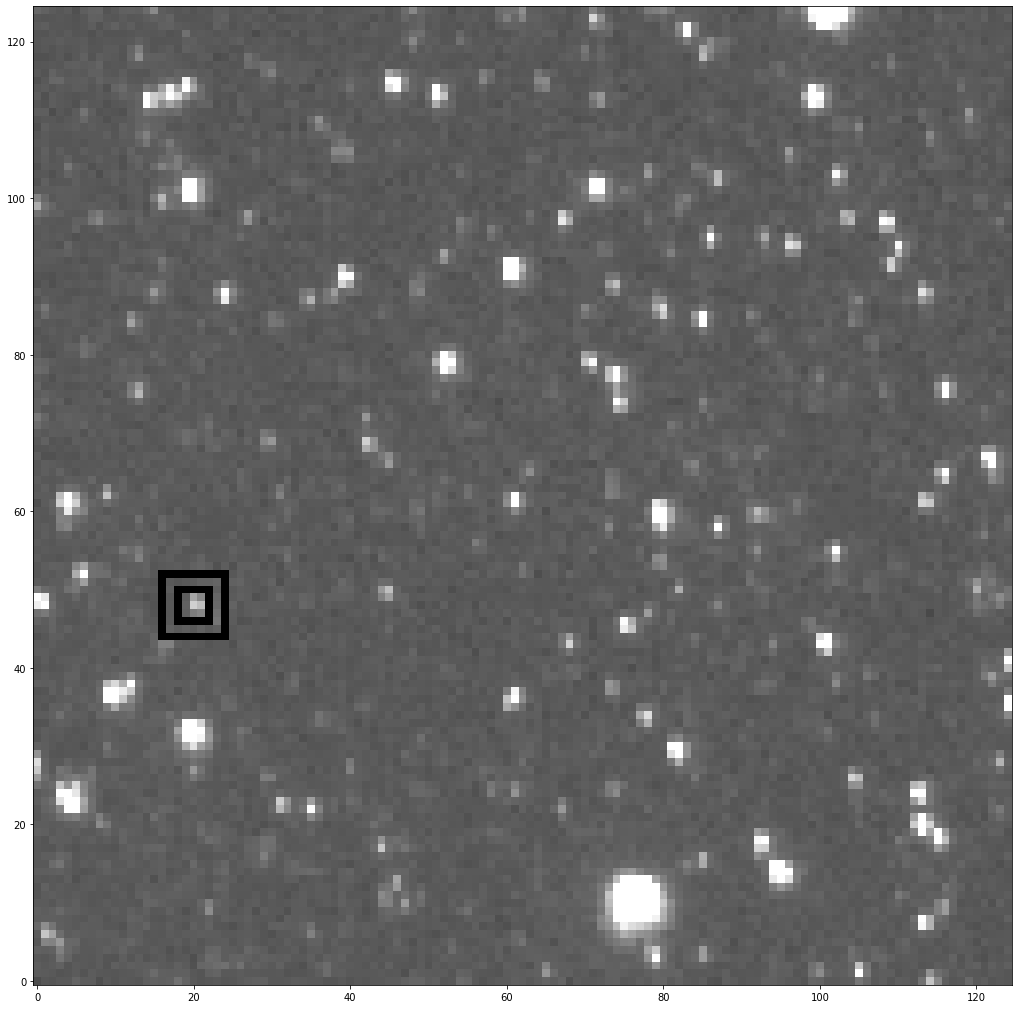

In [579]:
tot_starlnew_bin2, fsq12 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=18, pt1_2=50, pt2_1=22, pt2_2=46, dims=125, )

In [580]:
bin1_avg_l = np.mean(tot_starlnew_bin1)
bin2_avg_l = np.mean(tot_starlnew_bin2)
diff1_l = abs(bin1_avg_l - bin2_avg_l)
rel_change_l = diff1_l / np.mean([bin1_avg_l, bin2_avg_l])
print(bin1_avg_l)
print(bin2_avg_l)
print(rel_change_l)

1915.8125
2023.9666666666599
0.054903669516160304


In [582]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq12, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/im_stack_starL_NEW.png')

2021-12-01 04:33:58.100 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:33:58.101 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:33:58.140 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:33:58.141 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:33:58.162 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:33:58.164 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:33:58.185 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:33:58.186 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3338.375, 3356.875, 3367.9375, 3375.875, 3345.3125, 3353.5, 3379.5, 3424.1875, 3382.625, 3356.375, 3347.4375, 3477.3125, 3729.5, 3430.6875, 3379.8125, 3361.0625, 3442.375, 3653.625, 3443.3125, 3369.0, 3389.625, 3389.1875, 3405.4375, 3388.6875, 3371.5]
Inner List Length: 25
Inner List Median: 3379.8125
Inner List Mean: 3410.365
Outer List: [3365.5, 3357.8125, 3341.5625, 3338.125, 3330.4375, 3336.0625, 3362.125, 3341.875, 3354.875, 3360.75, 3325.375, 3339.5625, 3355.4375, 3351.375, 3349.8125, 3328.3125, 3358.875, 3375.1875, 3364.375, 3349.5, 3328.9375, 3347.9375, 3379.0625, 3352.5, 3360.25, 3330.0625, 3325.5, 3350.3125, 3346.6875, 3339.25, 3361.375, 3358.5625, 3349.8125, 3355.6875, 3342.4375, 3371.5, 3353.125, 3364.125, 3355.5625, 3356.625, 3380.125, 3365.4375, 3348.25, 3322.125, 3344.375, 3371.125, 3355.625, 3337.25, 3359.5, 3374.25, 3373.375, 3385.875, 3357.4375, 3367.8125, 3402.0625, 3362.3125]
Outer List Length: 56
Outer List Median: 3355.5
Outer List Mean: 3353.98549107

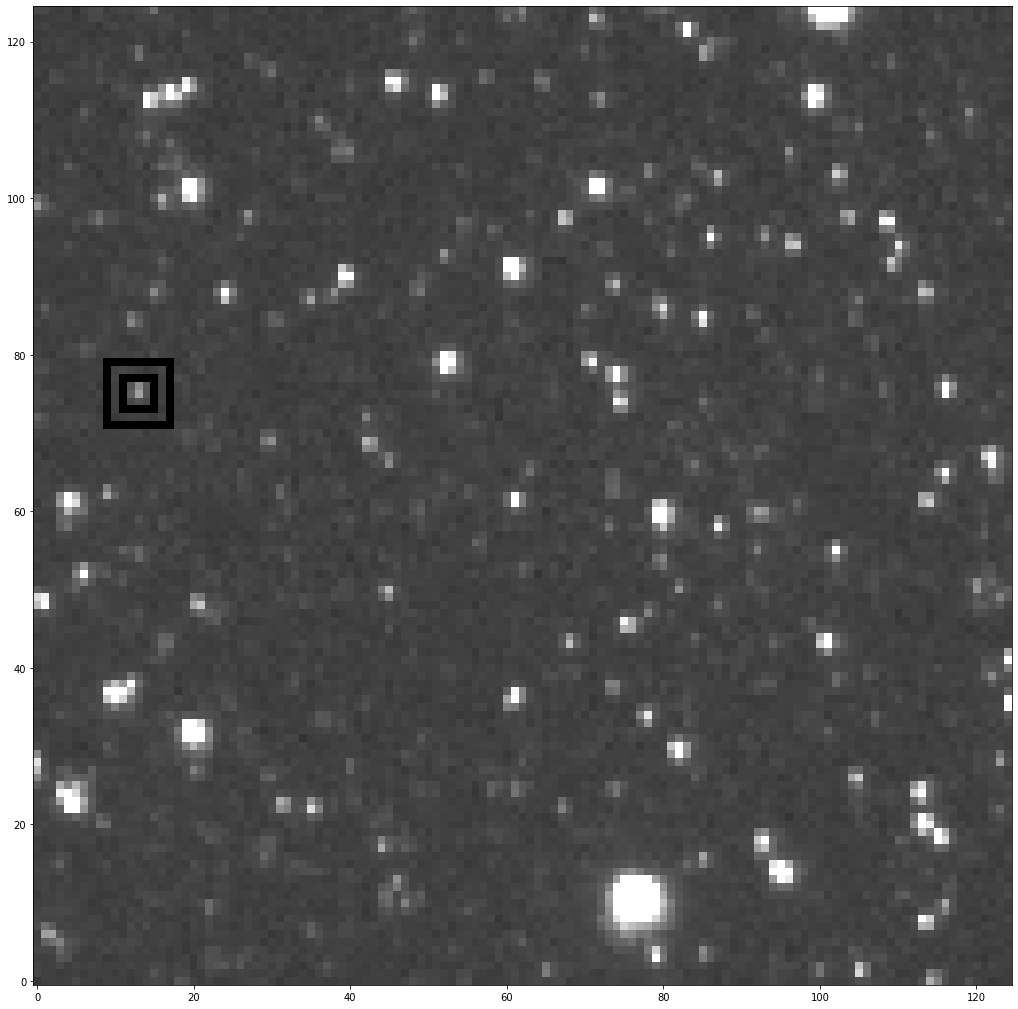

In [583]:
tot_starmnew_bin1, fsq13 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=11, pt1_2=77, pt2_1=15, pt2_2=73, dims=125, )

2021-12-01 04:34:06.206 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:34:06.208 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:34:06.248 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:34:06.249 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:34:06.273 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:34:06.274 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:34:06.296 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:34:06.297 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3450.9333333333334, 3450.4666666666667, 3453.0666666666666, 3459.9333333333334, 3453.8, 3440.266666666667, 3481.266666666667, 3537.8, 3477.6666666666665, 3451.133333333333, 3471.2, 3593.3333333333335, 3814.6666666666665, 3513.0, 3483.8, 3453.266666666667, 3573.133333333333, 3718.9333333333334, 3524.0666666666666, 3463.733333333333, 3486.6666666666665, 3490.8, 3505.866666666667, 3491.866666666667, 3455.0]
Inner List Length: 25
Inner List Median: 3481.266666666667
Inner List Mean: 3507.8266666666664
Outer List: [3458.6, 3446.5333333333333, 3435.4666666666667, 3429.733333333333, 3421.4666666666667, 3443.4666666666667, 3455.6666666666665, 3449.8, 3466.0, 3475.0666666666666, 3434.6666666666665, 3439.3333333333335, 3446.3333333333335, 3469.0, 3461.6666666666665, 3433.9333333333334, 3465.6666666666665, 3473.866666666667, 3451.0, 3450.5333333333333, 3419.5333333333333, 3455.2, 3486.5333333333333, 3452.8, 3461.5333333333333, 3435.2, 3419.0, 3446.4, 3443.9333333333334, 3442.4, 3458.

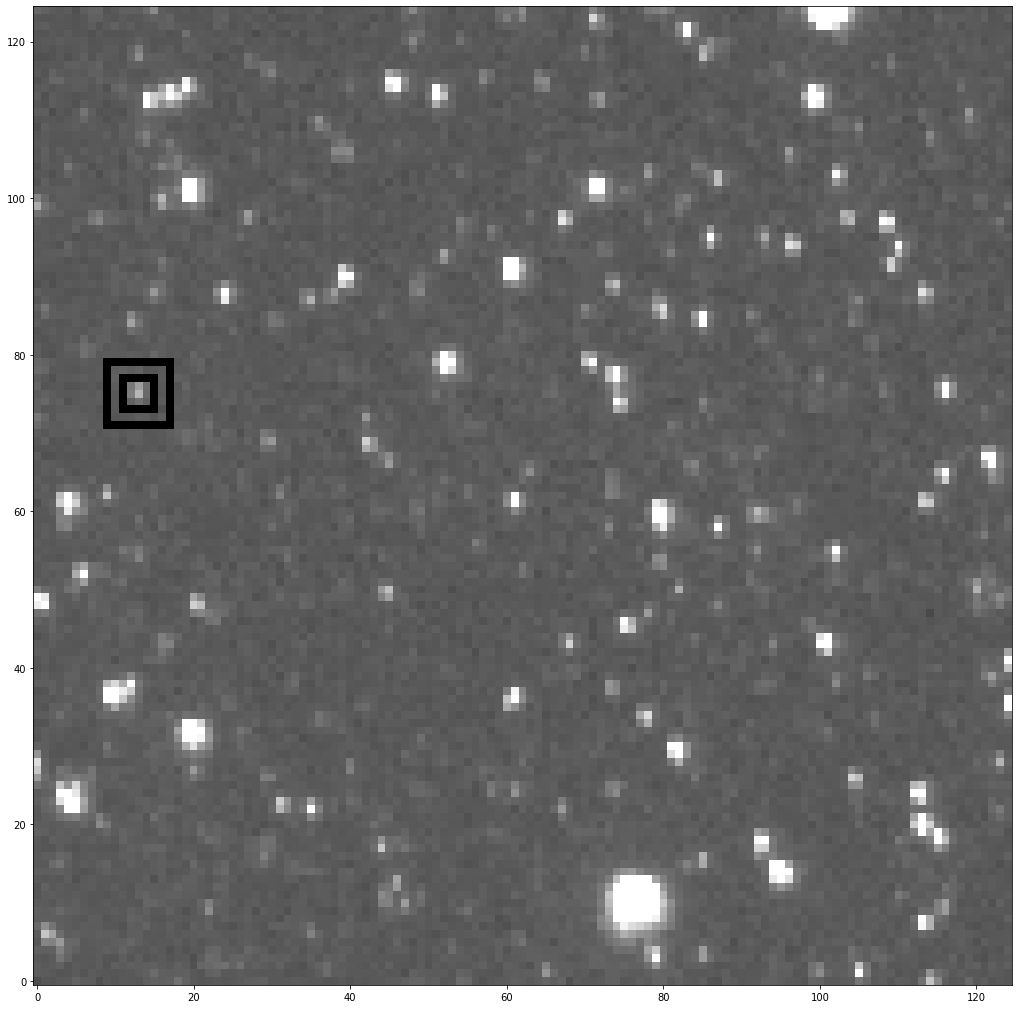

In [584]:
tot_starmnew_bin2, fsq13 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=11, pt1_2=77, pt2_1=15, pt2_2=73, dims=125, )

In [587]:
bin1_avg_m = np.mean(tot_starmnew_bin1)
bin2_avg_m = np.mean(tot_starmnew_bin2)
diff1_m = abs(bin1_avg_m - bin2_avg_m)
rel_change_m = diff1_m / np.mean([bin1_avg_m, bin2_avg_m])
print(bin1_avg_m)
print(bin2_avg_m)
print(rel_change_m)

1371.625
1293.166666666686
0.05888515362362663


In [586]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq13, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/im_stack_starM_NEW.png')

2021-12-01 04:35:49.634 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:35:49.636 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:35:49.677 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:35:49.678 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:35:49.699 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:35:49.700 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:35:49.721 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:35:49.722 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3367.8125, 3379.9375, 3388.1875, 3342.875, 3362.0, 3355.75, 3411.8125, 3593.125, 3408.1875, 3375.25, 3354.6875, 3447.8125, 4126.375, 3529.8125, 3384.1875, 3347.5625, 3376.1875, 3655.75, 3408.0625, 3385.6875, 3387.6875, 3379.125, 3348.0, 3372.4375, 3362.3125]
Inner List Length: 25
Inner List Median: 3379.9375
Inner List Mean: 3434.025
Outer List: [3358.4375, 3340.375, 3368.125, 3361.9375, 3373.1875, 3361.3125, 3343.125, 3346.8125, 3372.25, 3356.5, 3349.375, 3368.375, 3351.9375, 3346.5625, 3372.3125, 3350.0, 3354.0, 3357.375, 3391.0, 3378.3125, 3353.1875, 3346.875, 3380.9375, 3363.25, 3350.3125, 3354.3125, 3367.375, 3345.75, 3368.5, 3396.9375, 3366.25, 3351.125, 3371.0, 3373.25, 3379.5625, 3338.1875, 3341.0625, 3347.125, 3438.6875, 3367.375, 3358.3125, 3371.9375, 3367.125, 3367.8125, 3372.125, 3336.25, 3362.0625, 3485.4375, 3441.5, 3366.0, 3349.0625, 3344.375, 3363.0, 3335.125, 3368.4375, 3362.4375]
Outer List Length: 56
Outer List Median: 3362.25
Outer List Mean: 3365.23883

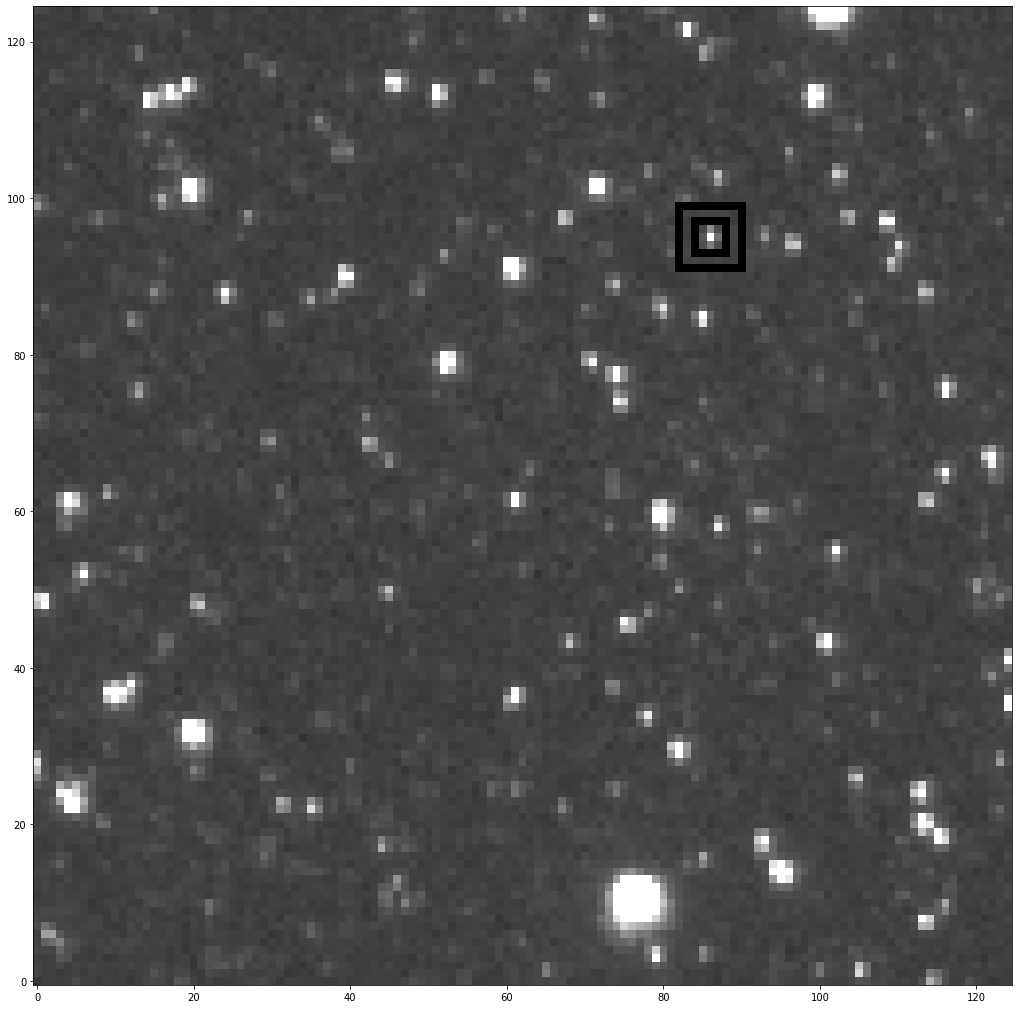

In [588]:
tot_starnnew_bin1, fsq14 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=84, pt1_2=97, pt2_1=88, pt2_2=93, dims=125, )

2021-12-01 04:35:56.429 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:35:56.431 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:35:56.469 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:35:56.470 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:35:56.493 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:35:56.494 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:35:56.517 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:35:56.519 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3463.9333333333334, 3477.266666666667, 3508.133333333333, 3449.866666666667, 3459.8, 3456.3333333333335, 3513.733333333333, 3776.5333333333333, 3516.733333333333, 3472.6666666666665, 3444.4666666666667, 3562.4, 4146.266666666666, 3586.8, 3474.133333333333, 3454.5333333333333, 3494.8, 3703.9333333333334, 3485.4666666666667, 3470.866666666667, 3473.6666666666665, 3473.5333333333333, 3450.6666666666665, 3476.5333333333333, 3459.0]
Inner List Length: 25
Inner List Median: 3474.133333333333
Inner List Mean: 3530.082666666667
Outer List: [3454.5333333333333, 3446.5333333333333, 3473.2, 3475.733333333333, 3471.9333333333334, 3462.3333333333335, 3434.6, 3455.2, 3474.866666666667, 3460.6666666666665, 3444.9333333333334, 3466.4, 3452.6666666666665, 3436.6, 3461.2, 3459.5333333333333, 3453.4666666666667, 3448.866666666667, 3482.733333333333, 3469.733333333333, 3453.8, 3457.2, 3455.4666666666667, 3459.4, 3447.866666666667, 3463.5333333333333, 3437.9333333333334, 3441.4, 3467.066666666

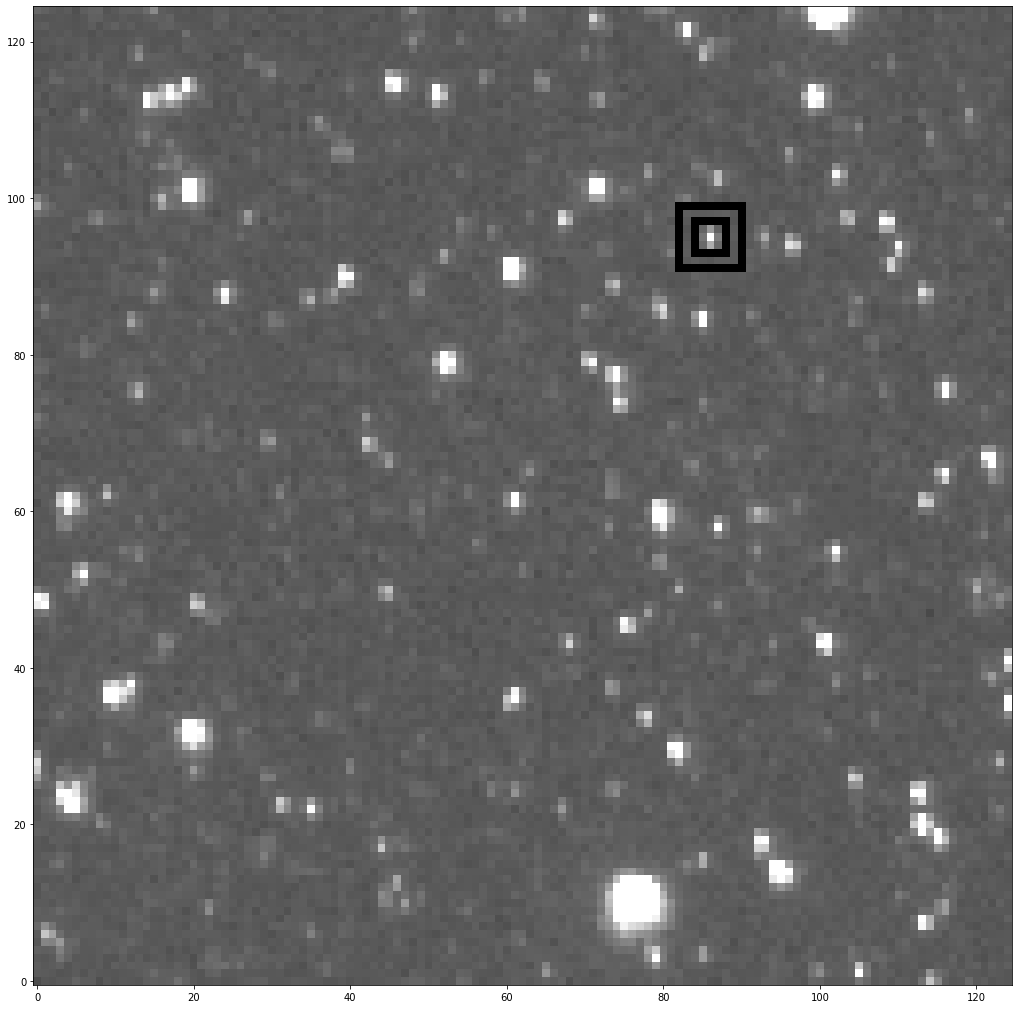

In [589]:
tot_starnnew_bin2, fsq14 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=84, pt1_2=97, pt2_1=88, pt2_2=93, dims=125, )

In [590]:
bin1_avg_n = np.mean(tot_starnnew_bin1)
bin2_avg_n = np.mean(tot_starnnew_bin2)
diff1_n = abs(bin1_avg_n - bin2_avg_n)
rel_change_n = diff1_n / np.mean([bin1_avg_n, bin2_avg_n])
print(bin1_avg_n)
print(bin2_avg_n)
print(rel_change_n)

1794.375
1825.4000000000233
0.017141949430571284


In [592]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq14, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/im_stack_starN_NEW.png')

2021-12-01 04:36:53.357 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:36:53.358 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:36:53.396 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:36:53.397 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:36:53.420 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:36:53.421 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:36:53.443 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:36:53.444 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3371.125, 3356.125, 3381.4375, 3369.25, 3354.375, 3366.625, 3385.875, 3444.75, 3400.3125, 3360.1875, 3369.5625, 3477.75, 3989.0625, 3453.0625, 3371.9375, 3373.6875, 3576.125, 4276.3125, 3517.0, 3389.0, 3376.375, 3395.5, 3493.5, 3392.5625, 3362.75]
Inner List Length: 25
Inner List Median: 3385.875
Inner List Mean: 3464.17
Outer List: [3332.0625, 3365.625, 3338.375, 3344.8125, 3330.3125, 3344.5, 3344.125, 3360.25, 3333.3125, 3370.4375, 3401.25, 3367.75, 3366.875, 3353.875, 3364.125, 3325.375, 3367.625, 3338.8125, 3369.25, 3381.3125, 3366.25, 3342.25, 3380.625, 3366.625, 3367.9375, 3333.875, 3395.125, 3372.875, 3347.8125, 3368.8125, 3448.875, 3379.6875, 3354.375, 3376.5, 3479.0, 3390.8125, 3346.9375, 3372.125, 3402.625, 3379.0, 3349.625, 3358.3125, 3386.875, 3371.9375, 3375.0, 3368.125, 3346.375, 3364.6875, 3357.0, 3372.125, 3373.125, 3382.5, 3352.375, 3333.875, 3333.125, 3341.4375]
Outer List Length: 56
Outer List Median: 3366.4375
Outer List Mean: 3364.9765625


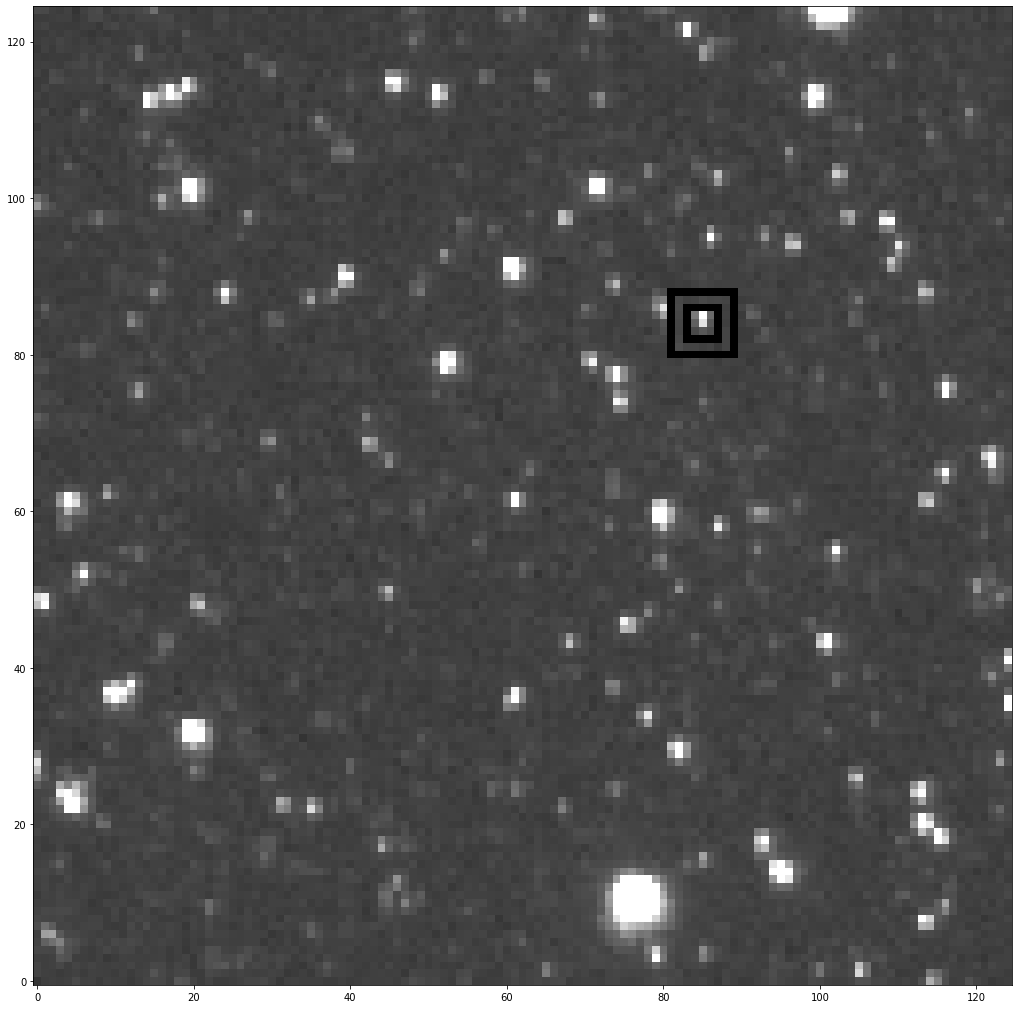

In [593]:
starbneww_bin1, fsq15 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=83, pt1_2=86, pt2_1=87, pt2_2=82, dims=125, )

2021-12-01 04:36:59.986 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:36:59.988 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-12-01 04:37:00.029 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:37:00.030 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:37:00.055 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:37:00.056 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-12-01 04:37:00.079 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-12-01 04:37:00.081 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3450.8, 3454.8, 3479.6666666666665, 3467.5333333333333, 3458.266666666667, 3458.9333333333334, 3482.266666666667, 3565.4666666666667, 3499.3333333333335, 3461.4666666666667, 3469.0, 3627.266666666667, 4137.266666666666, 3540.4, 3463.8, 3464.866666666667, 3700.6666666666665, 4168.866666666667, 3574.5333333333333, 3485.266666666667, 3477.6, 3497.6, 3566.6, 3479.6, 3459.133333333333]
Inner List Length: 25
Inner List Median: 3479.6666666666665
Inner List Mean: 3555.64
Outer List: [3432.2, 3474.133333333333, 3429.3333333333335, 3449.133333333333, 3426.8, 3435.133333333333, 3446.866666666667, 3448.0666666666666, 3436.9333333333334, 3471.266666666667, 3484.866666666667, 3441.3333333333335, 3469.4, 3441.6666666666665, 3477.6666666666665, 3425.266666666667, 3468.3333333333335, 3428.5333333333333, 3471.733333333333, 3474.133333333333, 3466.4666666666667, 3431.3333333333335, 3481.0, 3448.3333333333335, 3462.4, 3430.5333333333333, 3504.0666666666666, 3474.0666666666666, 3446.8, 3475.6

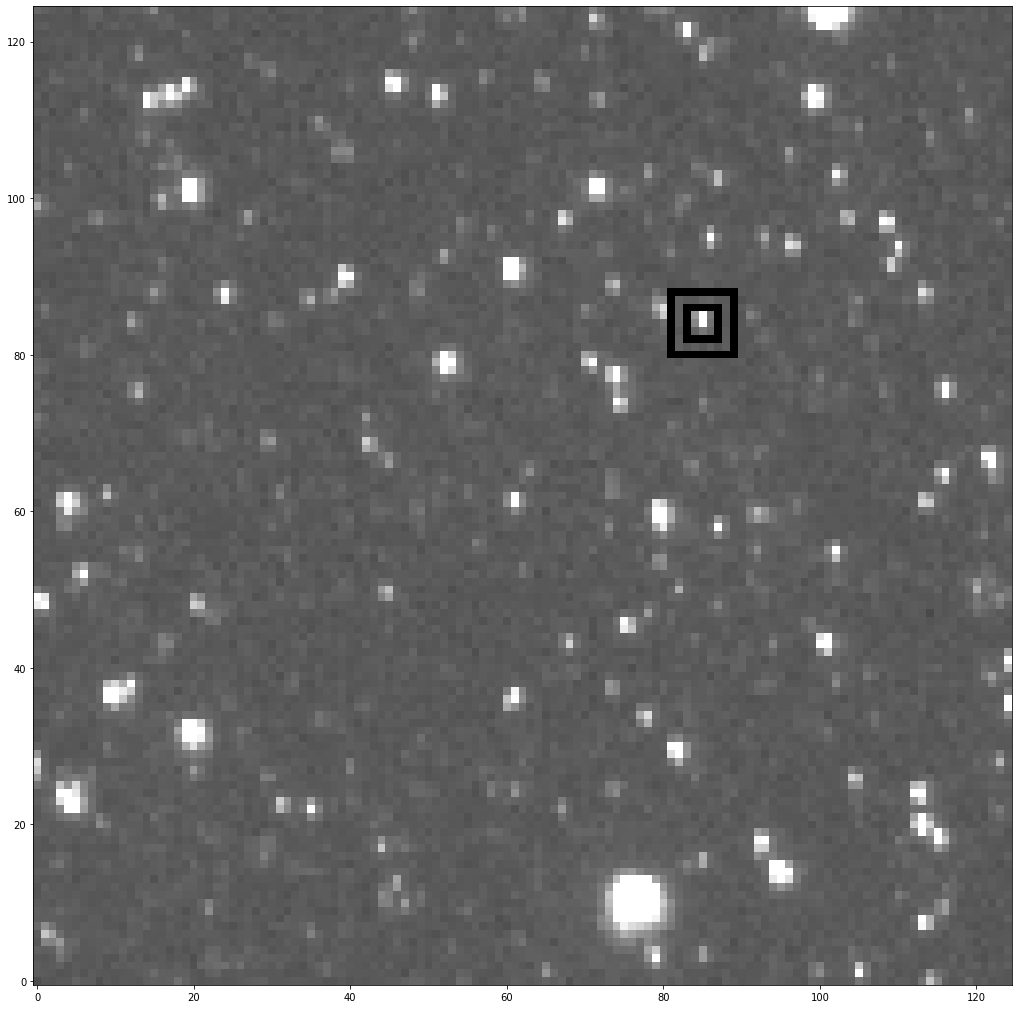

In [594]:
starbneww_bin2, fsq15 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=83, pt1_2=86, pt2_1=87, pt2_2=82, dims=125, )

In [595]:
bin1_avg_b = np.mean(starbneww_bin1)
bin2_avg_b = np.mean(starbneww_bin2)
diff1_b = abs(bin1_avg_b - bin2_avg_b)
rel_change_b = diff1_b / np.mean([bin1_avg_b, bin2_avg_b])
print(bin1_avg_b)
print(bin2_avg_b)
print(rel_change_b)

2443.3125
2480.1666666667006
0.014970782009686727


In [597]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq15, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/im_stack_starB_NEW.png')

2021-11-30 22:13:19.062 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:13:19.063 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-11-30 22:13:19.106 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:13:19.107 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:13:19.130 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:13:19.131 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:13:19.152 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:13:19.153 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3380.5625, 3428.5, 3479.5, 3449.1875, 3433.75, 3383.625, 3477.3125, 4349.5, 3854.1875, 3513.625, 3407.375, 3649.375, 6913.875, 4829.375, 3556.125, 3358.25, 3489.5625, 4975.8125, 4002.0, 3513.875, 3376.375, 3395.125, 3451.8125, 3460.0625, 3392.5625]
Inner List Length: 25
Inner List Median: 3477.3125
Inner List Mean: 3780.8525
Outer List: [3373.25, 3374.1875, 3381.25, 3457.0, 3363.3125, 3397.9375, 3331.375, 3357.5, 3327.4375, 3327.5625, 3360.125, 3357.5625, 3400.5625, 3385.8125, 3392.625, 3364.4375, 3370.5625, 3338.625, 3357.5625, 3351.5625, 3412.4375, 3357.875, 3351.75, 3364.5625, 3429.125, 3370.25, 3376.9375, 3404.125, 3408.75, 3359.125, 3366.1875, 3387.4375, 3403.3125, 3358.4375, 3368.8125, 3355.75, 3359.125, 3380.1875, 3373.3125, 3343.8125, 3380.6875, 3375.9375, 3365.625, 3379.4375, 3366.5625, 3345.875, 3376.75, 3349.75, 3342.125, 3390.125, 3369.5, 3348.4375, 3355.5625, 3369.8125, 3362.0625, 3332.5]
Outer List Length: 56
Outer List Median: 3366.375
Outer List Mean: 3369.

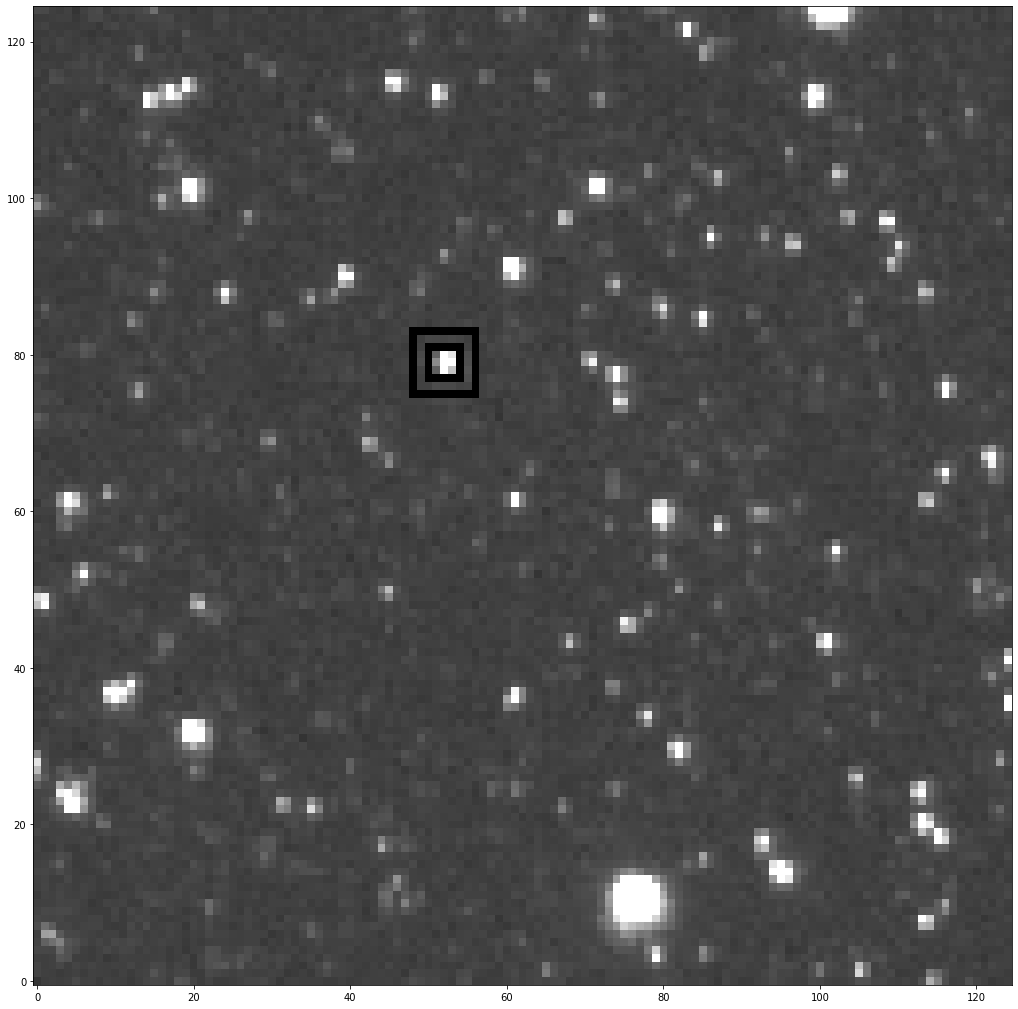

In [470]:
brightstar1_bin1, fsq15 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=50, pt1_2=81, pt2_1=54, pt2_2=77, dims=125, )

2021-11-30 22:13:23.146 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:13:23.148 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-11-30 22:13:23.187 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:13:23.189 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:13:23.211 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:13:23.212 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:13:23.237 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:13:23.238 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3481.4, 3522.0, 3612.0666666666666, 3554.6666666666665, 3537.5333333333333, 3484.8, 3608.8, 4780.933333333333, 3941.733333333333, 3600.4666666666667, 3494.133333333333, 3788.6666666666665, 7145.8, 4500.933333333333, 3613.4, 3457.6, 3627.6, 4765.666666666667, 3895.266666666667, 3568.5333333333333, 3472.266666666667, 3487.0666666666666, 3544.866666666667, 3557.5333333333333, 3497.866666666667]
Inner List Length: 25
Inner List Median: 3568.5333333333333
Inner List Mean: 3861.664
Outer List: [3475.9333333333334, 3462.2, 3485.9333333333334, 3545.2, 3466.2, 3499.0666666666666, 3435.2, 3451.4, 3412.8, 3438.3333333333335, 3460.4666666666667, 3477.0, 3500.0, 3492.8, 3500.4666666666667, 3471.3333333333335, 3461.2, 3445.4666666666667, 3451.3333333333335, 3449.2, 3523.4666666666667, 3464.733333333333, 3456.133333333333, 3473.733333333333, 3511.866666666667, 3465.4, 3479.0, 3498.266666666667, 3488.5333333333333, 3464.3333333333335, 3489.6666666666665, 3499.5333333333333, 3490.333333333

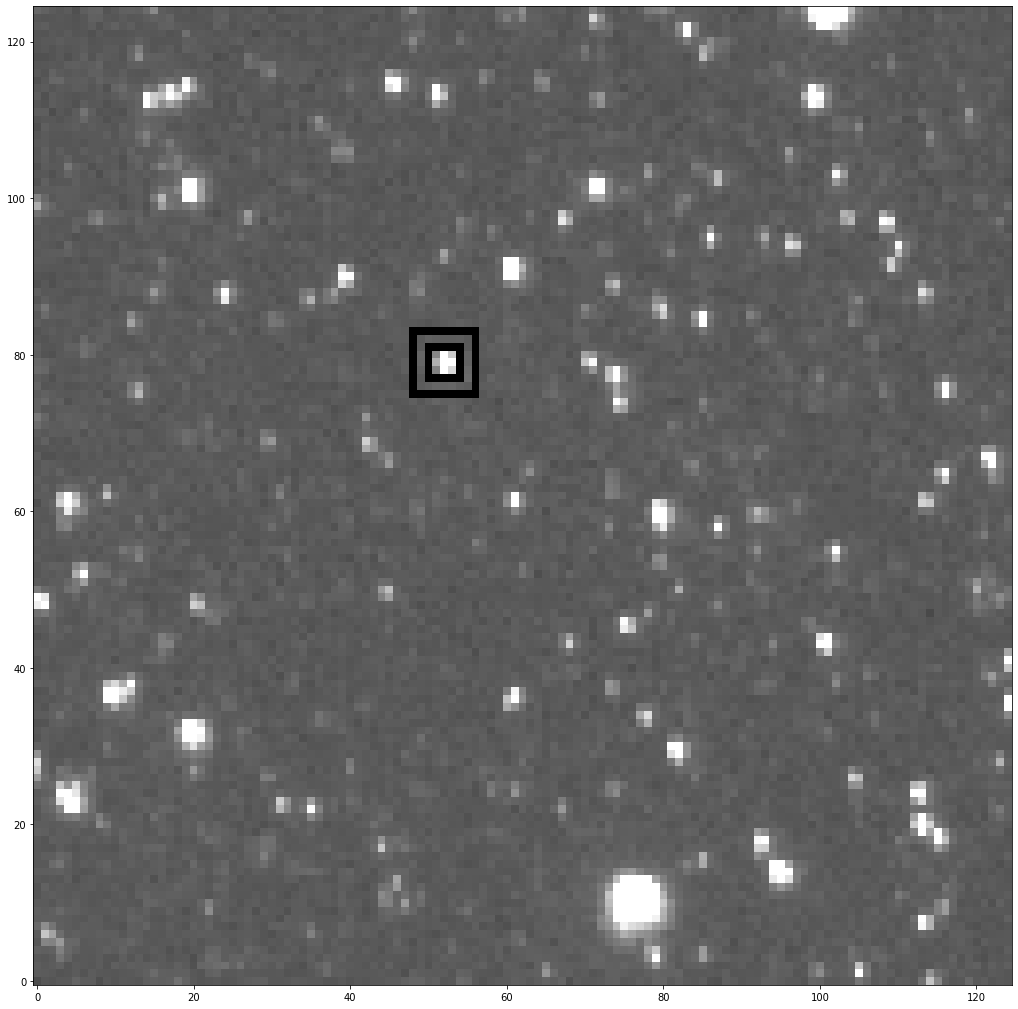

In [471]:
brightstar1_bin2, fsq15 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=50, pt1_2=81, pt2_1=54, pt2_2=77, dims=125, )

In [473]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq15, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/brighstar_1.png')

In [474]:
bin1_bs1 = np.mean(brightstar1_bin1)
bin2_bs1 = np.mean(brightstar1_bin2)
diff1_bs1 = abs(bin1_bs1 - bin2_bs1)
rel_change_bs1 = diff1_bs1 / np.mean([bin1_bs1, bin2_bs1])
print(bin1_bs1)
print(bin2_bs1)
print(rel_change_bs1)

10361.9375
9910.766666666677
0.044510177786262844


2021-11-30 22:15:17.006 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:15:17.008 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-11-30 22:15:17.055 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:15:17.057 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:15:17.079 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:15:17.080 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:15:17.103 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:15:17.104 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3380.1875, 3482.875, 3519.25, 3464.375, 3419.125, 3410.125, 3843.0625, 4777.125, 3593.75, 3442.0625, 3399.75, 5082.6875, 6838.6875, 3799.8125, 3465.125, 3407.5, 4096.25, 4332.9375, 3610.5, 3462.125, 3373.3125, 3419.25, 3410.1875, 3412.5, 3393.75]
Inner List Length: 25
Inner List Median: 3464.375
Inner List Mean: 3793.4525
Outer List: [3358.875, 3342.9375, 3372.9375, 3388.3125, 3364.625, 3332.25, 3335.9375, 3364.375, 3339.3125, 3361.625, 3365.5625, 3360.5, 3382.9375, 3394.5625, 3393.375, 3370.6875, 3359.375, 3343.25, 3360.25, 3354.0, 3364.6875, 3359.25, 3379.0, 3347.9375, 3400.8125, 3320.5625, 3349.0, 3359.4375, 3386.4375, 3361.5625, 3354.5, 3352.4375, 3383.625, 3324.3125, 3387.6875, 3367.0, 3362.25, 3371.1875, 3380.75, 3356.375, 3369.375, 3405.25, 3374.125, 3357.0625, 3383.9375, 3352.8125, 3377.875, 3352.3125, 3409.375, 3383.5, 3351.25, 3359.25, 3375.875, 3365.75, 3349.9375, 3362.4375]
Outer List Length: 56
Outer List Median: 3362.34375
Outer List Mean: 3365.082589285714


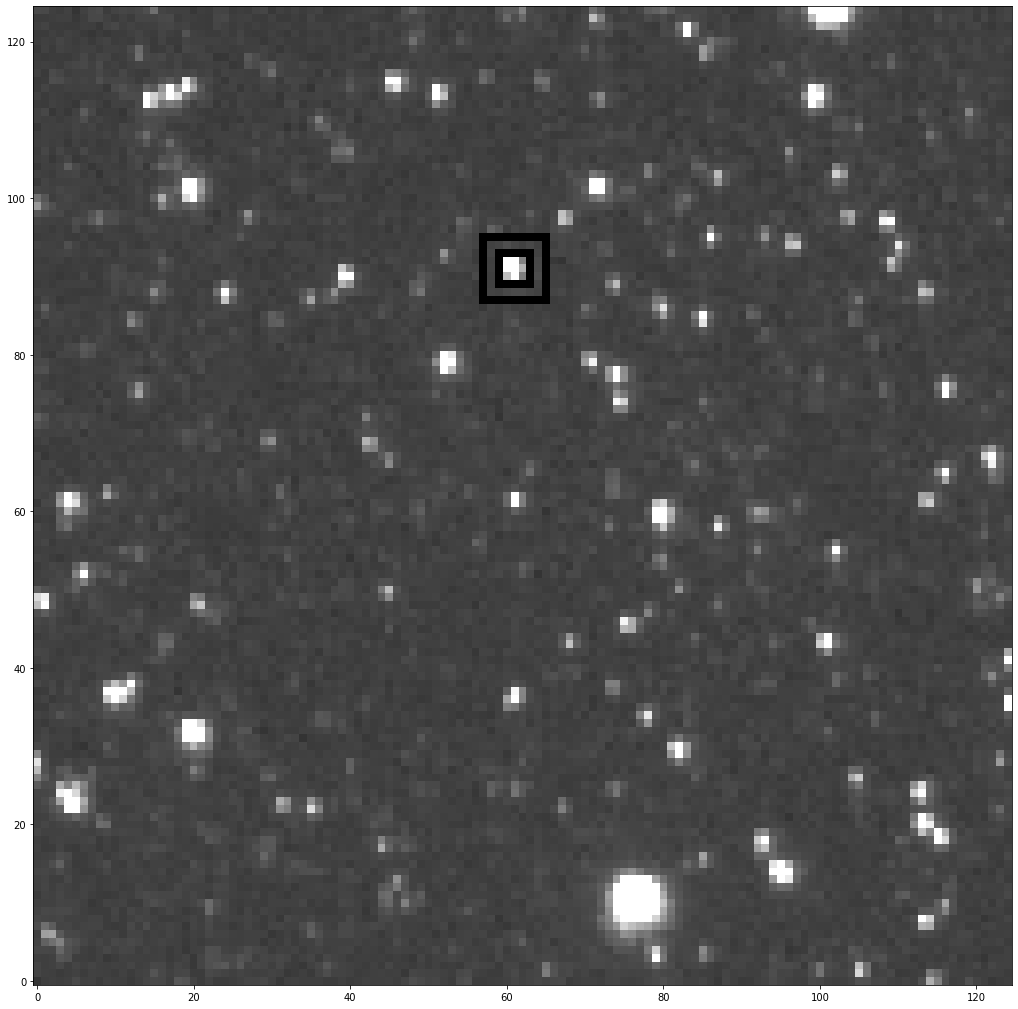

In [475]:
brightstar2_bin1, fsq16 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=59, pt1_2=93, pt2_1=63, pt2_2=89, dims=125, )

2021-11-30 22:15:27.406 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:15:27.408 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-11-30 22:15:27.444 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:15:27.446 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:15:27.469 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:15:27.470 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:15:27.494 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:15:27.495 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3483.4666666666667, 3601.6, 3662.866666666667, 3570.8, 3516.4, 3501.3333333333335, 4130.333333333333, 5002.133333333333, 3683.266666666667, 3535.3333333333335, 3493.866666666667, 5338.6, 6397.133333333333, 3804.8, 3552.733333333333, 3523.0, 4277.4, 4222.666666666667, 3650.4666666666667, 3530.133333333333, 3480.0, 3502.0, 3527.866666666667, 3502.133333333333, 3481.6]
Inner List Length: 25
Inner List Median: 3552.733333333333
Inner List Mean: 3878.877333333334
Outer List: [3475.6666666666665, 3448.733333333333, 3465.9333333333334, 3487.8, 3470.5333333333333, 3431.4666666666667, 3442.9333333333334, 3466.6666666666665, 3421.6666666666665, 3455.6, 3475.8, 3456.133333333333, 3478.4, 3487.0, 3508.266666666667, 3482.8, 3453.4, 3437.2, 3479.5333333333333, 3452.733333333333, 3470.6, 3451.8, 3462.733333333333, 3455.9333333333334, 3500.6, 3432.9333333333334, 3452.2, 3466.0, 3466.733333333333, 3457.4, 3435.6666666666665, 3447.733333333333, 3486.3333333333335, 3409.4, 3489.133333333333,

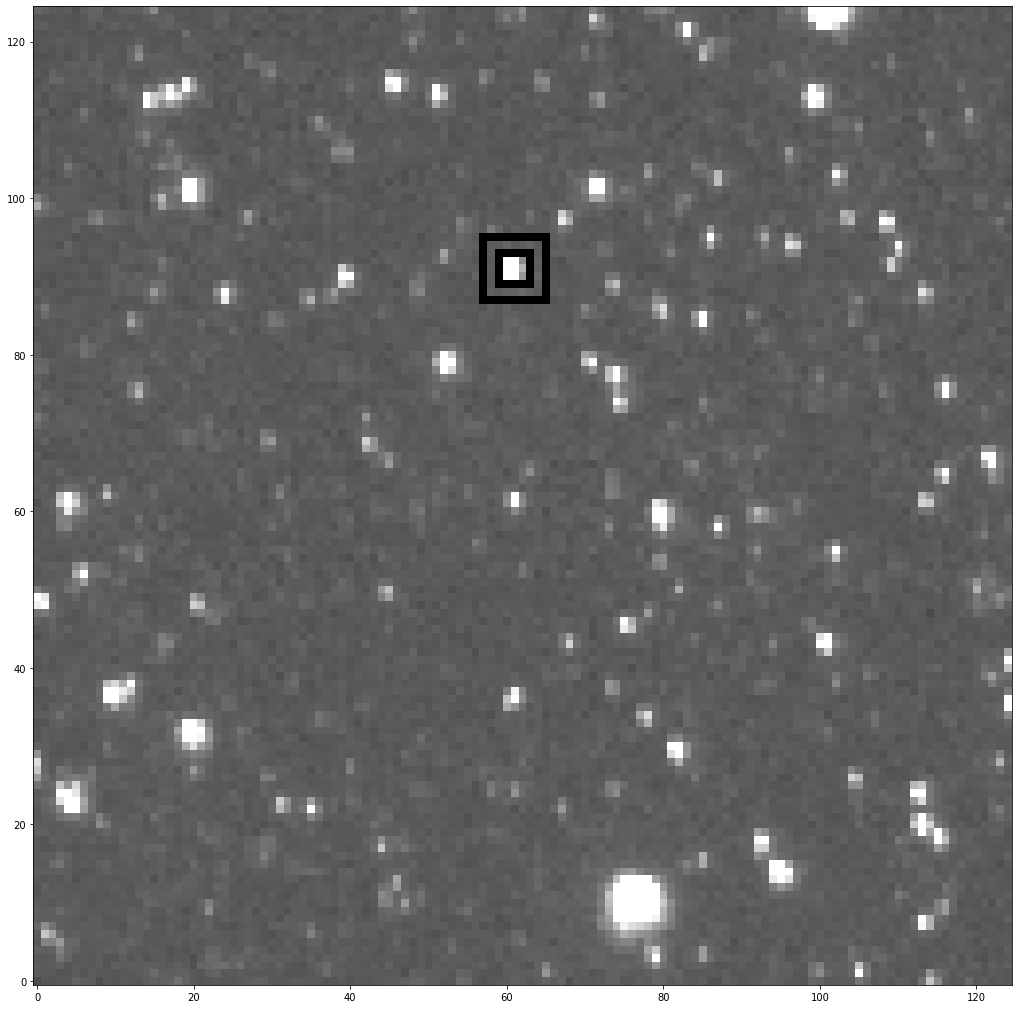

In [476]:
brightstar2_bin2, fsq16 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=59, pt1_2=93, pt2_1=63, pt2_2=89, dims=125, )

In [502]:
bin1_bs2 = np.mean(brightstar2_bin1)
bin2_bs2 = np.mean(brightstar2_bin2)
diff1_bs2 = abs(bin1_bs2 - bin2_bs2)
rel_change_bs2 = diff1_bs2 / np.mean([bin1_bs2, bin2_bs2])
print(bin1_bs2)
print(bin2_bs2)
print(rel_change_bs2)

10777.71875
10450.266666666663
0.030850980618843442


In [479]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq16, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/brighstar_2.png')

2021-11-30 22:16:28.049 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:16:28.051 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-11-30 22:16:28.089 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:16:28.090 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:16:28.112 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:16:28.113 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:16:28.136 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:16:28.137 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3394.875, 3588.625, 3890.0, 3518.6875, 3432.625, 3419.125, 4424.25, 5598.4375, 3749.9375, 3452.875, 3465.5, 5415.9375, 6764.625, 3794.4375, 3471.375, 3392.625, 3846.125, 3950.8125, 3522.6875, 3416.125, 3359.875, 3387.375, 3401.1875, 3411.1875, 3400.9375]
Inner List Length: 25
Inner List Median: 3471.375
Inner List Mean: 3858.81
Outer List: [3328.4375, 3369.375, 3368.8125, 3381.4375, 3402.5, 3381.125, 3398.8125, 3355.1875, 3358.625, 3365.0, 3354.3125, 3375.25, 3434.5, 3501.4375, 3434.375, 3401.1875, 3395.5625, 3420.4375, 3401.5625, 3419.4375, 3422.0, 3410.125, 3365.6875, 3360.1875, 3426.75, 3394.375, 3365.5625, 3356.6875, 3395.125, 3390.5625, 3368.625, 3348.6875, 3345.3125, 3356.625, 3406.125, 3367.9375, 3368.375, 3362.5625, 3394.4375, 3373.25, 3349.5625, 3359.3125, 3362.625, 3361.5, 3362.625, 3377.6875, 3348.875, 3367.8125, 3361.6875, 3358.8125, 3352.8125, 3345.0625, 3352.0625, 3368.25, 3374.3125, 3373.625]
Outer List Length: 56
Outer List Median: 3368.5
Outer List Mean: 3

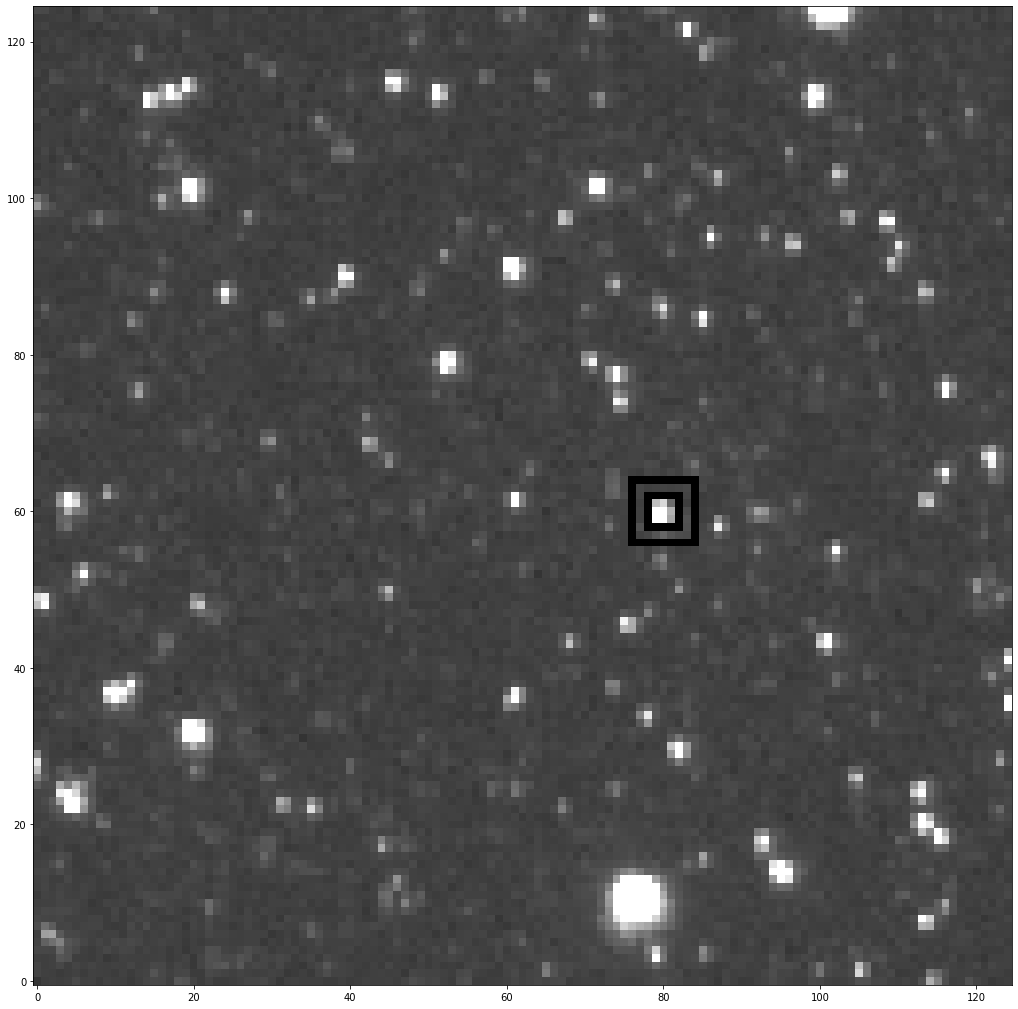

In [480]:
brightstar3_bin1, fsq17 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=78, pt1_2=62, pt2_1=82, pt2_2=58, dims=125, )

2021-11-30 22:16:28.845 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:16:28.846 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-11-30 22:16:28.888 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:16:28.889 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:16:28.913 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:16:28.914 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:16:28.937 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:16:28.938 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3490.266666666667, 3778.6666666666665, 4028.8, 3603.866666666667, 3514.4, 3531.0, 4948.4, 5613.6, 3767.266666666667, 3551.8, 3575.6666666666665, 5724.8, 6022.733333333334, 3760.0666666666666, 3543.0, 3494.5333333333333, 4013.4666666666667, 3899.6, 3585.4666666666667, 3509.733333333333, 3455.0666666666666, 3473.8, 3501.6, 3487.266666666667, 3496.6]
Inner List Length: 25
Inner List Median: 3575.6666666666665
Inner List Mean: 3934.858666666667
Outer List: [3438.4, 3464.5333333333333, 3468.0666666666666, 3483.4, 3493.0666666666666, 3490.0666666666666, 3487.6, 3480.866666666667, 3461.0666666666666, 3456.0, 3450.0666666666666, 3475.4, 3537.0, 3629.6666666666665, 3518.866666666667, 3498.0, 3496.2, 3506.133333333333, 3489.0, 3519.266666666667, 3515.6666666666665, 3506.0666666666666, 3463.133333333333, 3449.866666666667, 3520.4, 3478.0, 3456.2, 3465.6, 3497.133333333333, 3473.4, 3479.6, 3450.266666666667, 3447.0, 3454.133333333333, 3489.133333333333, 3454.9333333333334, 3463.4, 346

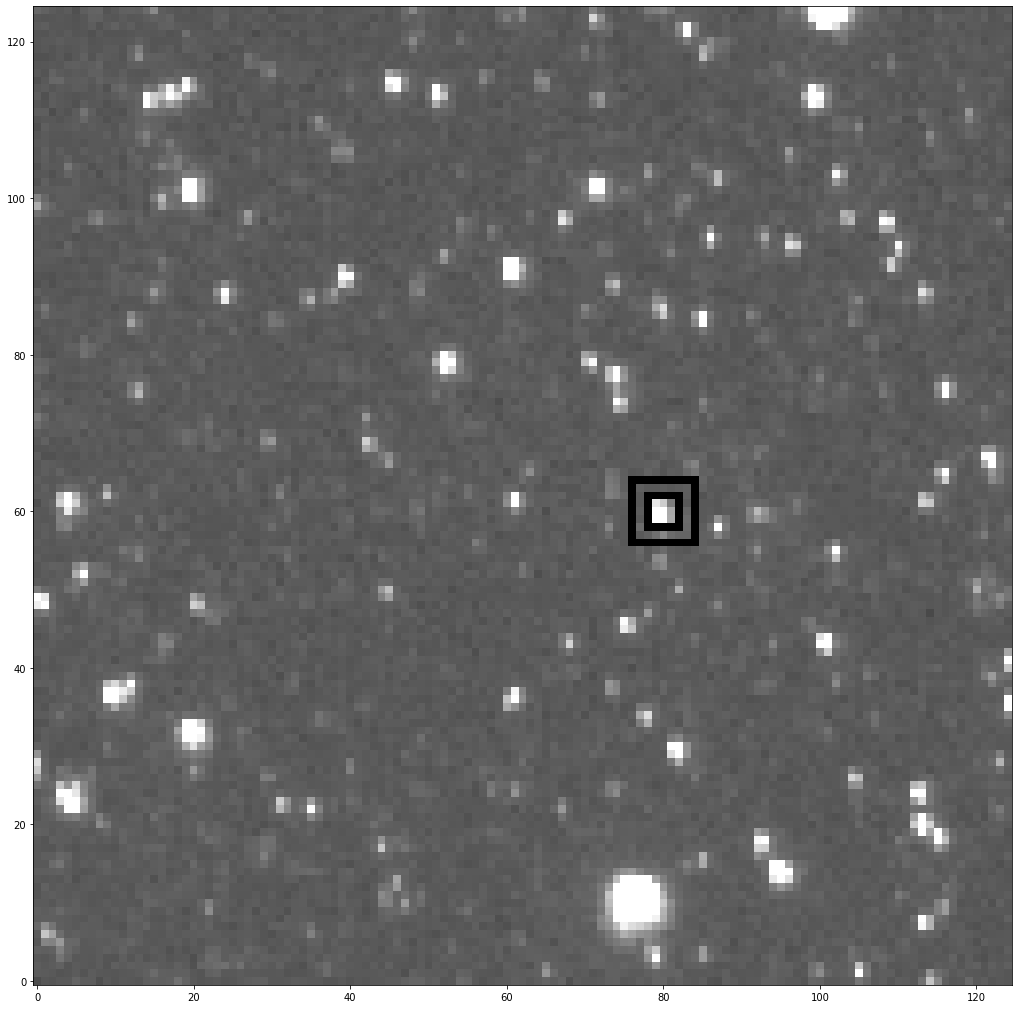

In [481]:
brightstar3_bin2, fsq17 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=78, pt1_2=62, pt2_1=82, pt2_2=58, dims=125, )

In [482]:
bin1_bs3 = np.mean(brightstar3_bin1)
bin2_bs3 = np.mean(brightstar3_bin2)
diff1_bs3 = abs(bin1_bs3 - bin2_bs3)
rel_change_bs3 = diff1_bs3 / np.mean([bin1_bs3, bin2_bs3])
print(bin1_bs3)
print(bin2_bs3)
print(rel_change_bs3)

12257.75
11637.300000000017
0.05193125772910976


In [484]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq17, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/brighstar_3.png')

2021-11-30 22:17:32.917 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:17:32.918 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-11-30 22:17:32.968 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:17:32.969 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:17:32.994 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:17:32.995 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:17:33.017 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:17:33.018 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3430.6875, 3474.875, 3508.0, 3454.9375, 3376.25, 3431.875, 3957.4375, 4123.6875, 3618.9375, 3430.5, 3520.9375, 6219.0, 6218.0625, 3716.375, 3464.0625, 3456.125, 5507.25, 4732.125, 3677.0, 3454.625, 3439.9375, 3497.625, 3443.1875, 3464.625, 3384.0625]
Inner List Length: 25
Inner List Median: 3474.875
Inner List Mean: 3880.0875
Outer List: [3363.5625, 3347.625, 3362.0, 3360.875, 3383.0625, 3386.4375, 3376.5, 3341.875, 3354.625, 3388.25, 3385.5625, 3399.0, 3374.4375, 3405.75, 3399.5625, 3345.4375, 3313.6875, 3365.625, 3610.375, 3459.9375, 3357.5625, 3362.8125, 3782.8125, 3486.0625, 3362.4375, 3349.4375, 3473.6875, 3457.875, 3368.8125, 3367.9375, 3388.6875, 3390.375, 3372.0, 3342.75, 3375.375, 3393.0, 3358.75, 3353.25, 3508.5625, 3470.5625, 3509.8125, 3406.25, 3443.5625, 3396.125, 3374.5625, 3368.0, 3380.5625, 3426.8125, 3425.375, 3488.5, 3419.8125, 3363.375, 3375.0, 3338.1875, 3374.3125, 3346.375]
Outer List Length: 56
Outer List Median: 3375.9375
Outer List Mean: 3401.492187

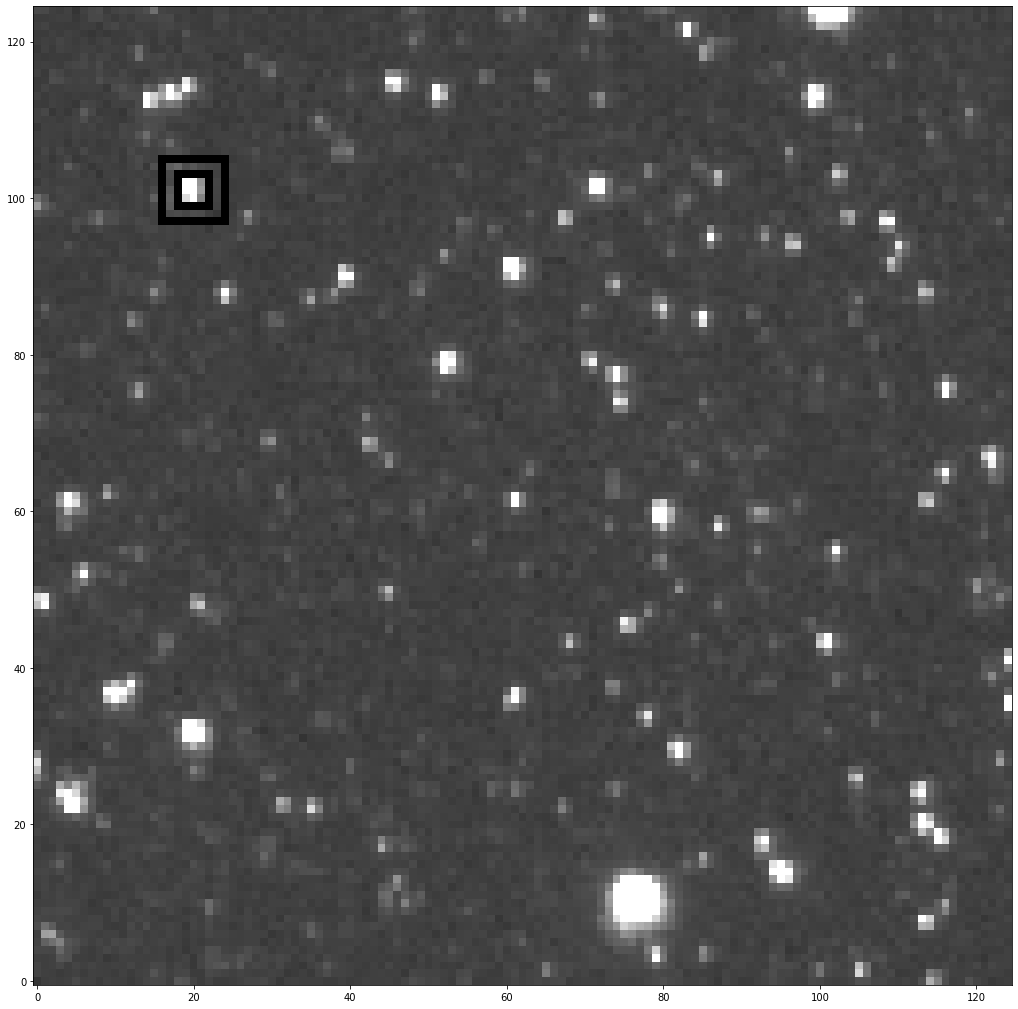

In [485]:
brightstar4_bin1, fsq18 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=18, pt1_2=103, pt2_1=22, pt2_2=99, dims=125, )

2021-11-30 22:17:39.255 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:17:39.257 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-11-30 22:17:39.301 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:17:39.302 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:17:39.326 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:17:39.327 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:17:39.349 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:17:39.350 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3530.6, 3572.4, 3624.0666666666666, 3554.133333333333, 3468.9333333333334, 3535.133333333333, 4221.533333333334, 4282.666666666667, 3725.133333333333, 3539.6666666666665, 3625.6, 6478.8, 5847.733333333334, 3734.733333333333, 3522.3333333333335, 3545.4666666666667, 5501.8, 4517.0, 3706.4, 3539.2, 3527.8, 3592.8, 3572.9333333333334, 3556.733333333333, 3501.5333333333333]
Inner List Length: 25
Inner List Median: 3572.9333333333334
Inner List Mean: 3953.005333333334
Outer List: [3460.733333333333, 3446.2, 3453.0666666666666, 3452.3333333333335, 3481.4, 3484.733333333333, 3473.0666666666666, 3445.3333333333335, 3459.0, 3484.866666666667, 3464.5333333333333, 3473.266666666667, 3476.4, 3509.0, 3493.733333333333, 3436.4666666666667, 3408.2, 3444.866666666667, 3719.0, 3560.0666666666666, 3439.0666666666666, 3460.6, 3815.4666666666667, 3549.133333333333, 3457.4, 3448.866666666667, 3567.4, 3542.733333333333, 3471.2, 3450.266666666667, 3488.4, 3488.3333333333335, 3465.3333333333335, 3

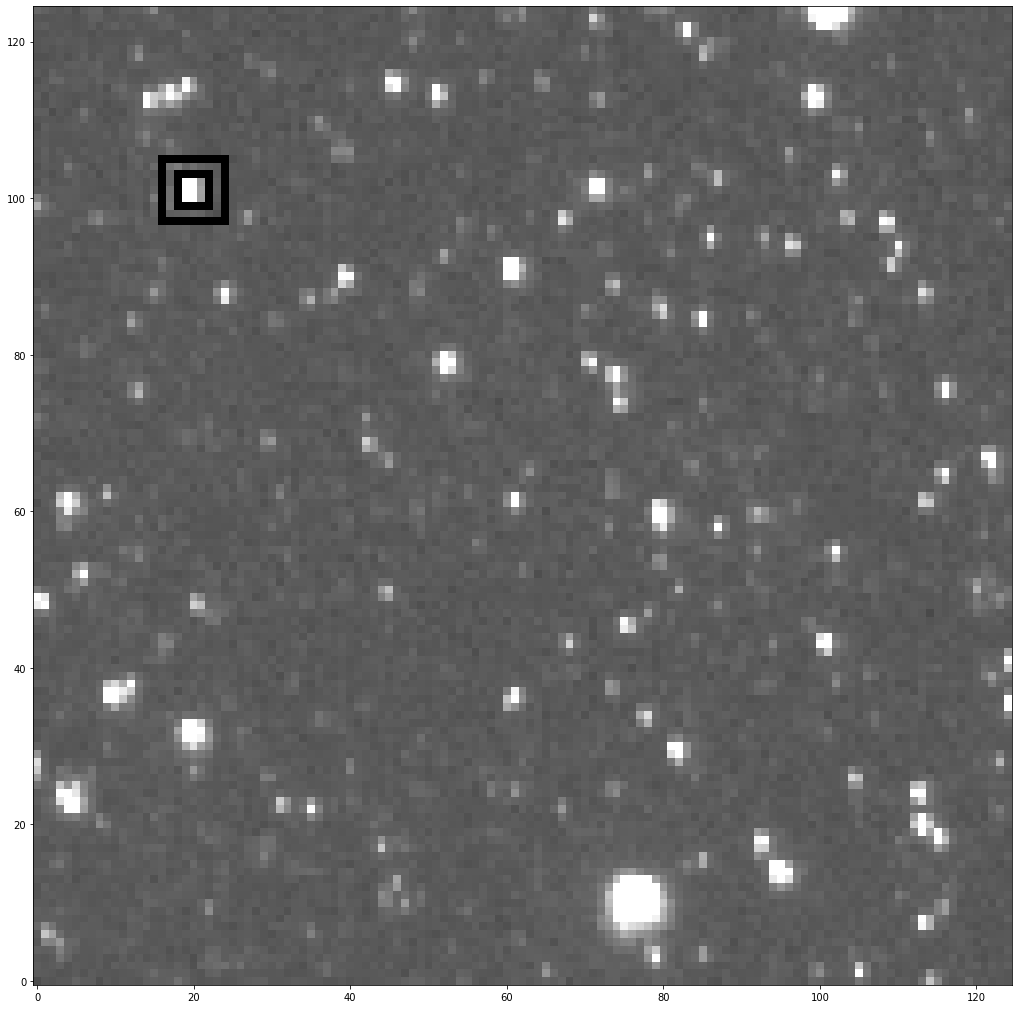

In [486]:
brightstar4_bin2, fsq18 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=18, pt1_2=103, pt2_1=22, pt2_2=99, dims=125, )

In [489]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq18, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/brighstar_4.png')

In [490]:
bin1_bs4 = np.mean(brightstar4_bin1)
bin2_bs4 = np.mean(brightstar4_bin2)
diff1_bs4 = abs(bin1_bs4 - bin2_bs4)
rel_change_bs4 = diff1_bs4 / np.mean([bin1_bs4, bin2_bs4])
print(bin1_bs4)
print(bin2_bs4)
print(rel_change_bs4)

12603.75
11987.633333333331
0.05010833740544638


2021-11-30 22:18:29.694 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:18:29.695 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-11-30 22:18:29.736 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:18:29.737 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:18:29.760 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:18:29.762 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:18:29.785 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:18:29.786 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3409.875, 3506.375, 3456.3125, 3414.3125, 3373.25, 3499.5625, 4383.375, 3861.0625, 3490.4375, 3415.6875, 3685.3125, 7243.25, 4798.3125, 3553.125, 3394.375, 3485.75, 5052.5, 3948.5, 3504.875, 3378.0625, 3405.0625, 3461.8125, 3412.75, 3409.0, 3370.75]
Inner List Length: 25
Inner List Median: 3485.75
Inner List Mean: 3796.5475
Outer List: [3353.125, 3348.375, 3340.6875, 3361.375, 3348.875, 3364.5625, 3431.8125, 3431.1875, 3405.5, 3350.375, 3349.5625, 3364.5625, 3396.25, 3359.6875, 3351.9375, 3411.6875, 3427.4375, 3391.0625, 3344.125, 3360.0625, 3363.875, 3340.5625, 3371.75, 3383.5, 3390.25, 3384.9375, 3408.125, 3367.875, 3361.625, 3353.1875, 3361.4375, 3379.75, 3332.25, 3368.6875, 3395.375, 3368.8125, 3375.5625, 3345.375, 3371.875, 3365.0625, 3368.125, 3400.0, 3354.3125, 3368.9375, 3364.0625, 3341.8125, 3346.5, 3376.25, 3360.875, 3404.5, 3377.8125, 3364.25, 3350.625, 3351.5625, 3351.125, 3370.5]
Outer List Length: 56
Outer List Median: 3364.5625
Outer List Mean: 3370.23883928

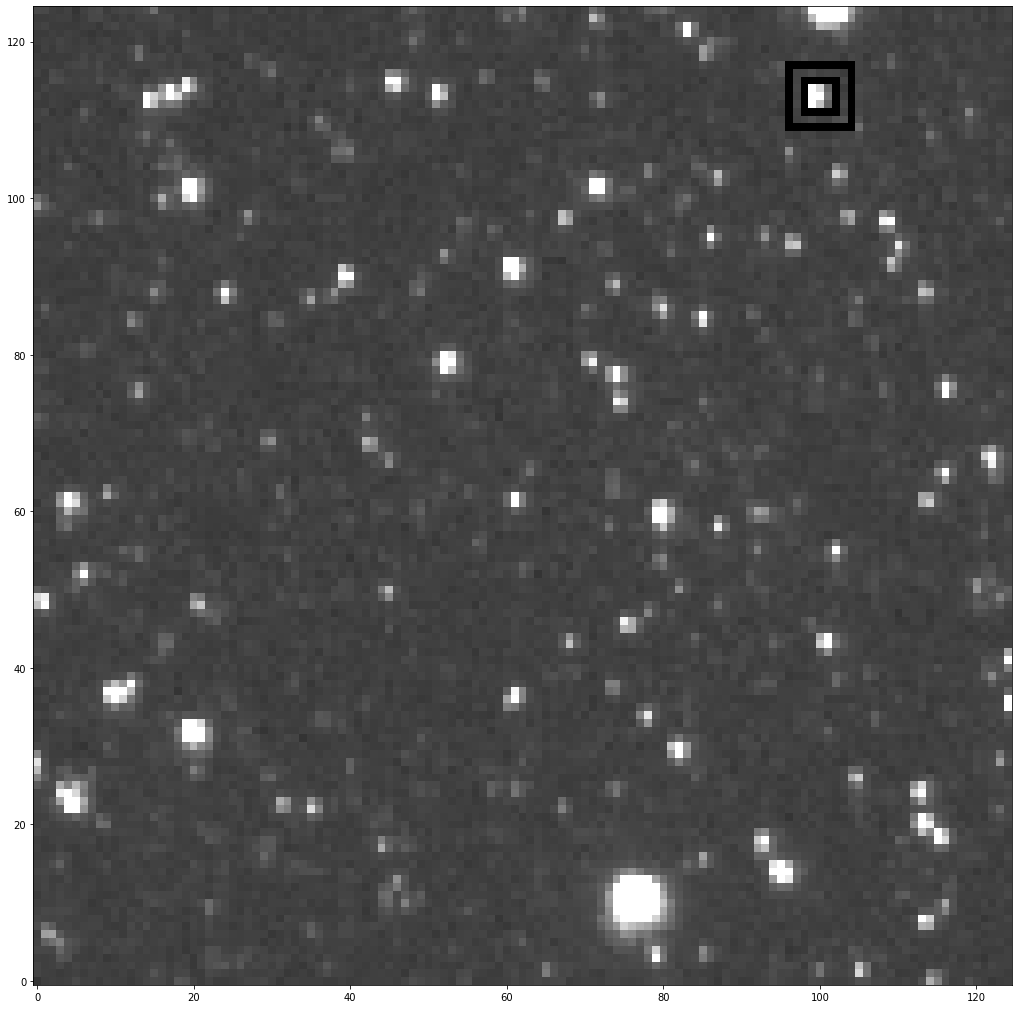

In [491]:
brightstar5_bin1, fsq19 = get_flux_counts_new(bin=1, mode='stacked', pt1_1=98, pt1_2=115, pt2_1=102, pt2_2=111, dims=125, )

2021-11-30 22:18:34.794 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:18:34.795 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792
2021-11-30 22:18:34.835 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:18:34.836 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:18:34.857 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:18:34.858 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1604, y_max=1854
2021-11-30 22:18:34.883 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2021-11-30 22:18:34.884 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2472, x_max=2722, y_min=1

Inner List: [3503.0, 3619.5333333333333, 3555.4, 3514.0, 3469.133333333333, 3634.8, 4964.0, 4025.0666666666666, 3594.0, 3485.4666666666667, 3807.4, 7390.666666666667, 4508.066666666667, 3629.9333333333334, 3493.5333333333333, 3579.133333333333, 4663.6, 3844.133333333333, 3571.2, 3476.6666666666665, 3502.733333333333, 3535.0, 3513.733333333333, 3500.6666666666665, 3468.5333333333333]
Inner List Length: 25
Inner List Median: 3571.2
Inner List Mean: 3873.9760000000006
Outer List: [3462.5333333333333, 3412.6, 3441.9333333333334, 3462.6, 3435.0, 3469.2, 3518.3333333333335, 3511.0666666666666, 3498.4666666666667, 3441.3333333333335, 3468.5333333333333, 3465.866666666667, 3491.4, 3452.0666666666666, 3454.4666666666667, 3506.0, 3512.4666666666667, 3475.0666666666666, 3449.8, 3444.9333333333334, 3454.9333333333334, 3443.266666666667, 3470.0, 3474.0666666666666, 3488.4666666666667, 3484.733333333333, 3479.0, 3459.5333333333333, 3446.3333333333335, 3454.733333333333, 3464.0, 3476.0, 3431.93333333

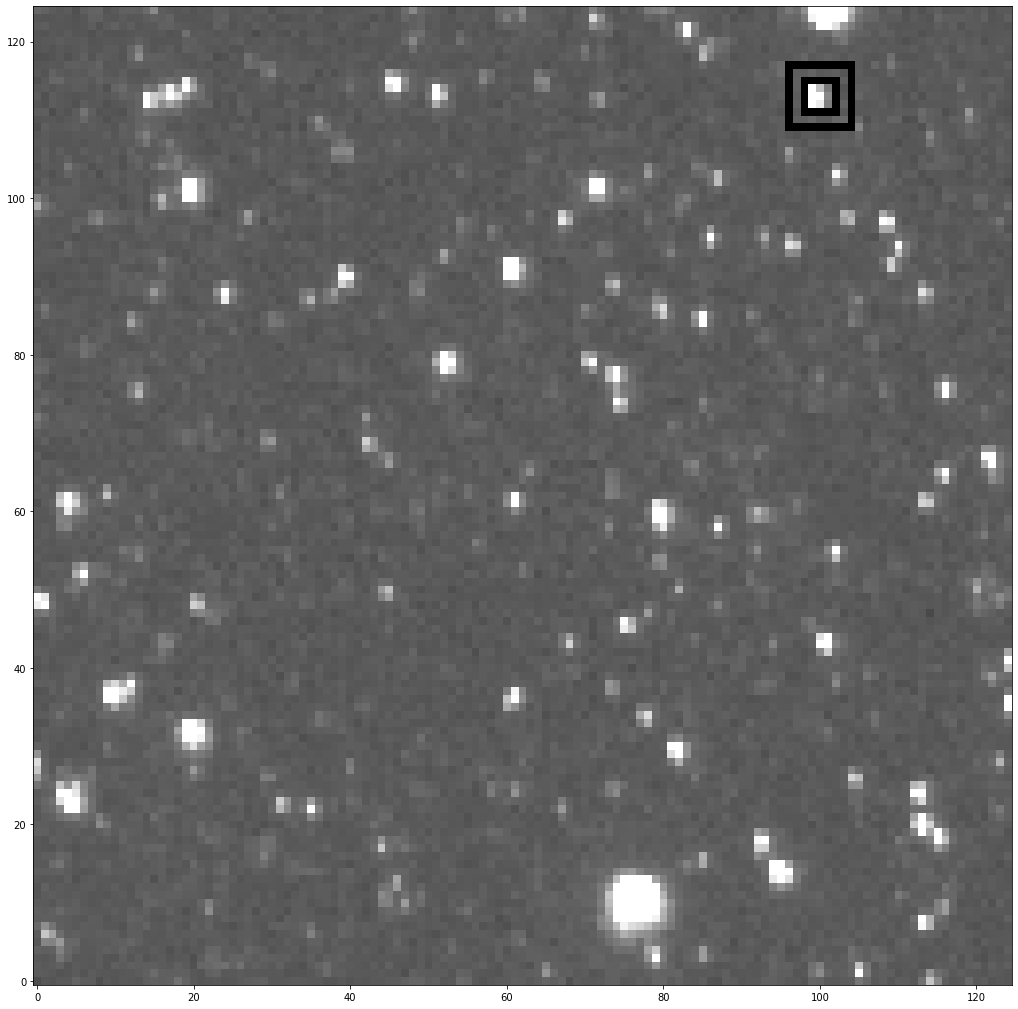

In [492]:
brightstar5_bin2, fsq19 = get_flux_counts_new(bin=2, mode='stacked', pt1_1=98, pt1_2=115, pt2_1=102, pt2_2=111, dims=125, )

Get some basic stats on stellar fluxes:

In [496]:
bin1_bs5 = np.mean(brightstar5_bin1)
bin2_bs5 = np.mean(brightstar5_bin2)
diff1_bs5 = abs(bin1_bs5 - bin2_bs5)
rel_change_bs5 = diff1_bs5 / np.mean([bin1_bs5, bin2_bs5])
print(bin1_bs5)
print(bin2_bs5)
print(rel_change_bs5)

10799.625
10231.900000000023
0.053988001345596774


In [634]:
np.mean([rel_change_h, rel_change_i, rel_change_j, rel_change_k, rel_change_l, rel_change_m, rel_change_n,])

0.05655838306886198

In [635]:
np.std([rel_change_h, rel_change_i, rel_change_j, rel_change_k, rel_change_l, rel_change_m, rel_change_n,])

0.03271550347750843

In [600]:
np.std([rel_change_a, rel_change_b, rel_change_c, rel_change_d, rel_change_e, rel_change_f, rel_change_g])

/opt/conda/envs/python38/lib/python3.8/site-packages/numpy/core/_methods.py:197: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


array([0.01238094])

In [601]:
np.mean([rel_change_a, rel_change_b, rel_change_c, rel_change_d, rel_change_e, rel_change_f, rel_change_g])

array([0.02862735])

In [500]:
# np.mean([rel_change_bs1, rel_change_bs2, rel_change_bs3, rel_change_bs4, rel_change_bs5])

0.04627775097705184

In [501]:
np.std([rel_change_bs1, rel_change_bs2, rel_change_bs3, rel_change_bs4, rel_change_bs5])

0.008332983264069423

In [495]:
# fig=plt.figure(figsize=(32,18))
# ax1 = fig.add_subplot(111)
# ax1.imshow(fsq19, origin='lower', cmap='gray', vmin=3100, vmax=4100)
# plt.savefig('green_channel_images/stacked_images/binned/brighstar_5.png')

Convert fluxes to magnitudes:

In [623]:
# Magnitude measurements for bright stars
bs_bin1_fluxes = [bin1_bs1, bin1_bs2, bin1_bs3, bin1_bs4, bin1_bs5]
bs_bin2_fluxes = [bin2_bs1, bin2_bs2, bin2_bs3, bin2_bs4, bin2_bs5]

# Note the 10.83 value is the measured mag of our comp star: TYC 3697-817-1.
bin1_mags = [float(-2.5*np.log10(i/ref_star_bin1)) + 10.83 for i in bs_bin1_fluxes]
bin2_mags = [float(-2.5*np.log10(j/ref_star_bin2)) + 10.83 for j in bs_bin2_fluxes]

In [636]:
bs_bin1_fluxes

[10361.9375, 10777.71875, 12257.75, 12603.75, 10799.625]

In [631]:
bin1_tot_fluxes = [bin1_avg_a, bin1_avg_b, bin1_avg_c, bin1_avg_d, bin1_avg_e, bin1_avg_f, bin1_avg_g, bin1_avg_h, bin1_avg_i, bin1_avg_j,
bin1_avg_k, bin1_avg_l, bin1_avg_m, bin1_avg_n, bin1_bs1, bin1_bs2, bin1_bs3, bin1_bs4, bin1_bs5]

bin2_tot_fluxes = [bin2_avg_a, bin2_avg_b, bin2_avg_c, bin2_avg_d, bin2_avg_e, bin2_avg_f, bin2_avg_g, bin2_avg_h,
bin2_avg_i, bin2_avg_j, bin2_avg_k, bin2_avg_l, bin2_avg_m, bin2_avg_n, bin2_bs1, bin2_bs2, bin2_bs3, bin2_bs4, bin2_bs5]

bin1_tot_mags = [float(-2.5*np.log10(i/ref_star_bin1)) + 10.83 for i in bin1_tot_fluxes]
bin2_tot_mags = [float(-2.5*np.log10(j/ref_star_bin2)) + 10.83 for j in bin2_tot_fluxes]

bin1_flux1 = [bin1_avg_a, bin1_avg_b, bin1_avg_c, bin1_avg_d, bin1_avg_e, bin1_avg_f, bin1_avg_g, ]
bin2_flux1 = [bin2_avg_a, bin2_avg_b, bin2_avg_c, bin2_avg_d, bin2_avg_e, bin2_avg_f, bin2_avg_g, ]

bin1_flux2 = [bin1_avg_h, bin1_avg_i, bin1_avg_j, bin1_avg_k, bin1_avg_l, bin1_avg_m, bin1_avg_n,]
bin2_flux2 = [bin2_avg_h, bin2_avg_i, bin2_avg_j, bin2_avg_k, bin2_avg_l, bin2_avg_m, bin2_avg_n,]

bin1_mags1 = [float(-2.5*np.log10(i/ref_star_bin1)) + 10.83 for i in bin1_flux1]
bin2_mags1 = [float(-2.5*np.log10(j/ref_star_bin2)) + 10.83 for j in bin2_flux1]

bin1_mags2 = [float(-2.5*np.log10(i/ref_star_bin1)) + 10.83 for i in bin1_flux2]
bin2_mags2 = [float(-2.5*np.log10(i/ref_star_bin2)) + 10.83 for i in bin2_flux2]

In [633]:
bin2_mags2

[11.232626609626115,
 11.482667026435672,
 11.650335920542968,
 11.208403291028233,
 11.170743293832754,
 11.65711542936275,
 11.282856567588546]

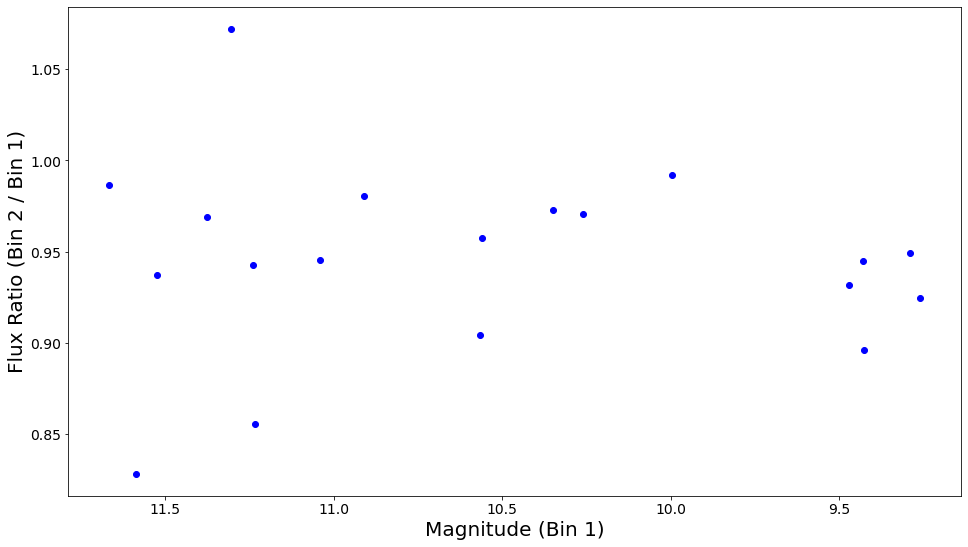

In [630]:

bin_ratios = [i/j for i,j in zip(bin2_fluxes, bin1_fluxes)]
# bin_changes = np.array([rel_change_a, rel_change_b, rel_change_c, rel_change_d,rel_change_e, rel_change_f, rel_change_g]) * 100
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

# # ax.plot(header_times, tot_1,'ro-', label='Simulated Background')
# # ax.plot(header_times, tot_2, 'go-', label='Real Background (bottom left)')
# # ax.plot(header_times, tot_3, 'bo-', label='Real Background (upper left)')
# ax.plot(header_times, outlist_newobj7, 'ro-', label=f"Region 3")
ax.plot(bin1_tot_mags, bin_ratios, 'bo',)
# ax.plot(bin1_mags, bin_changes, 'bo-',)

ax.invert_xaxis()
# # ax.plot(header_times, mean_resid_vals, 'go-', label=f"Residual Background Flux 2")

# # ax.axhline(y=0, color='g')



# # ax.plot(header_times, total_counts3, 'bo-', label='Radius(Inner, Outer): (4,6)')



plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xlabel('Magnitude (Bin 1)', fontsize=20)
# ax.set_ylabel('Flux Ratios (Bin 1 / Bin 2)', fontsize=20)
ax.set_ylabel('Flux Ratio (Bin 2 / Bin 1)', fontsize=20)

# ax.set_title('Counts in "Background" Annulus (G)', fontsize=20)
# ax.legend(fontsize=14)
plt.show()
fig.savefig('green_channel_plots/flux_ratio_plot.png')